In [6]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
#import bigframes.pandas as bpd
from IPython.display import display, HTML
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
#import pyspark.pandas as ps
#from pyspark.sql import SparkSession


def user_details(start_date, end_date,entity_d):

    query = f"""
    WITH listing AS (    
        SELECT   global_entity_id
                ,country
                ,CAST(DATE_TRUNC(injestion_time, MONTH) AS DATE) session_month
                ,CAST(DATE_TRUNC(injestion_time, ISOWEEK) AS DATE) session_week
                ,CAST(DATE_TRUNC(injestion_time, DAY) AS DATE) session_day
                ,EXTRACT(HOUR FROM injestion_time) AS session_hour
                ,session_key 
                ,perseus_session_id
                ,chainId 
                ,shopId
                ,userId
                ,df_impressions 
        FROM (
        SELECT  session_key
                ,COALESCE(pe.global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,userId
                ,ingestion_timestamp injestion_time
                ,country
                ,COALESCE(chainId, JSON_VALUE(eventVariables_json, "$.chainId") ) AS chainId
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY ingestion_timestamp) row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")) df_raw
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'shop_impressions.loaded'
                AND screenType = 'shop_list'
                AND pe.global_entity_id IN (""" + entity_d + """)
                AND locationCity IS NOT NULL
                AND shopType = 'restaurants'
        )
        WHERE row_num = 1
        AND df_raw IS NOT NULL
        ORDER BY global_entity_id, session_key
    ), shop_details AS (
        SELECT  global_entity_id
                ,session_key
                ,perseus_session_id
                ,shopId
                ,df_impressions
        FROM (
        SELECT  session_key
                ,COALESCE(global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY "timestamp") row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'shop_details.loaded'
                AND global_entity_id IN (""" + entity_d + """)
        )
        WHERE row_num = 1
        ORDER BY global_entity_id, session_key
    ), checkout AS (
        SELECT  global_entity_id
                ,session_key
                ,perseus_session_id
                ,shopId
                ,df_impressions
        FROM (
        SELECT  session_key
                ,COALESCE(global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY "timestamp") row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'checkout.loaded'
                AND global_entity_id IN (""" + entity_d + """)
        )
        WHERE row_num = 1
        ORDER BY global_entity_id, session_key
    ), orders AS (
        SELECT  global_entity_id
                ,session_key
                ,perseus_session_id
                ,shopId
                ,df_impressions
        FROM (
        SELECT  session_key
                ,COALESCE(global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY "timestamp") row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction IN ('transaction')
                AND global_entity_id IN (""" + entity_d + """)
        )
        WHERE row_num = 1
        ORDER BY global_entity_id, session_key
    ), rates AS (
        SELECT cu.country_iso
            ,cu.currency_code
            ,tmp.fx_rate_eur
        FROM `fulfillment-dwh-production.cl.countries` cu
        JOIN ( 
            WITH latest_fx_rate AS (
            SELECT 
                currency_code,
                fx_rate_eur,
                calculated_at,
                ROW_NUMBER() OVER (PARTITION BY currency_code ORDER BY calculated_at DESC) AS rn
            FROM `fulfillment-dwh-production.curated_data_shared_coredata.fx_rates`
            )
            SELECT 
                currency_code,
                fx_rate_eur,
                calculated_at AS max_calculated_at
            FROM latest_fx_rate
            WHERE rn = 1
        ) tmp ON tmp.currency_code = cu.currency_code
        GROUP BY 1, 2, 3
        ORDER BY 1
    )
    SELECT      l.global_entity_id
                ,l.userId
                -- Delivery fee listing calculations
                ,AVG(l.df_impressions / r.fx_rate_eur) AS delivery_fee_listing_eur_mean
                ,APPROX_QUANTILES(l.df_impressions / r.fx_rate_eur, 100)[OFFSET(50)] AS delivery_fee_listing_eur_median
                ,MIN(l.df_impressions / r.fx_rate_eur) AS delivery_fee_listing_eur_min
                ,MAX(l.df_impressions / r.fx_rate_eur) AS delivery_fee_listing_eur_max
                ,STDDEV(l.df_impressions / r.fx_rate_eur) AS delivery_fee_listing_eur_stddev
                
                -- Delivery fee details page calculations
                ,AVG(sd.df_impressions / r.fx_rate_eur) AS delivery_fee_details_eur_mean
                ,APPROX_QUANTILES(sd.df_impressions / r.fx_rate_eur, 100)[OFFSET(50)] AS delivery_fee_details_eur_median
                ,MIN(sd.df_impressions / r.fx_rate_eur) AS delivery_fee_details_eur_min
                ,MAX(sd.df_impressions / r.fx_rate_eur) AS delivery_fee_details_eur_max
                ,STDDEV(sd.df_impressions / r.fx_rate_eur) AS delivery_fee_details_eur_stddev
                
                -- Delivery fee checkout calculations
                ,AVG(co.df_impressions / r.fx_rate_eur) AS delivery_fee_checkout_eur_mean
                ,APPROX_QUANTILES(co.df_impressions / r.fx_rate_eur, 100)[OFFSET(50)] AS delivery_fee_checkout_eur_median
                ,MIN(co.df_impressions / r.fx_rate_eur) AS delivery_fee_checkout_eur_min
                ,MAX(co.df_impressions / r.fx_rate_eur) AS delivery_fee_checkout_eur_max
                ,STDDEV(co.df_impressions / r.fx_rate_eur) AS delivery_fee_checkout_eur_stddev
                
                -- Delivery fee order calculations
                ,AVG(o.df_impressions / r.fx_rate_eur) AS delivery_fee_order_eur_mean
                ,APPROX_QUANTILES(o.df_impressions / r.fx_rate_eur, 100)[OFFSET(50)] AS delivery_fee_order_eur_median
                ,MIN(o.df_impressions / r.fx_rate_eur) AS delivery_fee_order_eur_min
                ,MAX(o.df_impressions / r.fx_rate_eur) AS delivery_fee_order_eur_ma
                ,STDDEV(o.df_impressions / r.fx_rate_eur) AS delivery_fee_order_eur_stddev
                ,COUNT(l.shopId) AS total_vendor
                ,SUM(CASE WHEN sd.shopId IS NOT NULL THEN 1 ELSE 0 END) AS converted_details_page
                ,SUM(CASE WHEN co.shopId IS NOT NULL THEN 1 ELSE 0 END) AS converted_checkout
                ,SUM(CASE WHEN o.shopId IS NOT NULL THEN 1 ELSE 0 END) AS converted_order
    FROM listing l
    LEFT JOIN shop_details sd ON sd.global_entity_id = l.global_entity_id AND sd.session_key = l.session_key AND sd.shopId = l.shopId
    LEFT JOIN checkout co ON co.global_entity_id = l.global_entity_id AND co.session_key = l.session_key AND co.shopId = l.shopId
    LEFT JOIN orders o ON o.global_entity_id = l.global_entity_id AND o.session_key = l.session_key AND o.shopId = l.shopId
    LEFT JOIN rates r ON l.country = r.country_iso
    GROUP BY 1, 2
    """

    return query



def user_conversion(start_date, end_date,entity_d):

    query = f"""
    WITH listing AS (    
        SELECT   global_entity_id
                ,country
                ,CAST(DATE_TRUNC(injestion_time, MONTH) AS DATE) session_month
                ,CAST(DATE_TRUNC(injestion_time, ISOWEEK) AS DATE) session_week
                ,CAST(DATE_TRUNC(injestion_time, DAY) AS DATE) session_day
                ,EXTRACT(HOUR FROM injestion_time) AS session_hour
                ,session_key 
                ,perseus_session_id
                ,chainId 
                ,shopId
                ,userId
                ,df_impressions 
        FROM (
        SELECT  session_key
                ,COALESCE(pe.global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,userId
                ,ingestion_timestamp injestion_time
                ,country
                ,COALESCE(chainId, JSON_VALUE(eventVariables_json, "$.chainId") ) AS chainId
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY ingestion_timestamp) row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")) df_raw
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'shop_impressions.loaded'
                AND screenType = 'shop_list'
                AND pe.global_entity_id IN (""" + entity_d + """)
                AND locationCity IS NOT NULL
                AND shopType = 'restaurants'
        )
        WHERE row_num = 1
        AND df_raw IS NOT NULL
        ORDER BY global_entity_id, session_key
    ), shop_details AS (
        SELECT  global_entity_id
                ,session_key
                ,perseus_session_id
                ,shopId
                ,df_impressions
        FROM (
        SELECT  session_key
                ,COALESCE(global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY "timestamp") row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'shop_details.loaded'
                AND global_entity_id IN (""" + entity_d + """)
        )
        WHERE row_num = 1
        ORDER BY global_entity_id, session_key
    ), checkout AS (
        SELECT  global_entity_id
                ,session_key
                ,perseus_session_id
                ,shopId
                ,df_impressions
        FROM (
        SELECT  session_key
                ,COALESCE(global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY "timestamp") row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'checkout.loaded'
                AND global_entity_id IN (""" + entity_d + """)
        )
        WHERE row_num = 1
        ORDER BY global_entity_id, session_key
    ), orders AS (
        SELECT  global_entity_id
                ,session_key
                ,perseus_session_id
                ,shopId
                ,df_impressions
        FROM (
        SELECT  session_key
                ,COALESCE(global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY "timestamp") row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction IN ('transaction')
                AND global_entity_id IN (""" + entity_d + """)
        )
        WHERE row_num = 1
        ORDER BY global_entity_id, session_key
    ), rates AS (
        SELECT cu.country_iso
            ,cu.currency_code
            ,tmp.fx_rate_eur
        FROM `fulfillment-dwh-production.cl.countries` cu
        JOIN ( 
            WITH latest_fx_rate AS (
            SELECT 
                currency_code,
                fx_rate_eur,
                calculated_at,
                ROW_NUMBER() OVER (PARTITION BY currency_code ORDER BY calculated_at DESC) AS rn
            FROM `fulfillment-dwh-production.curated_data_shared_coredata.fx_rates`
            )
            SELECT 
                currency_code,
                fx_rate_eur,
                calculated_at AS max_calculated_at
            FROM latest_fx_rate
            WHERE rn = 1
        ) tmp ON tmp.currency_code = cu.currency_code
        GROUP BY 1, 2, 3
        ORDER BY 1
    ), impression as (
    SELECT       l.global_entity_id
                ,l.country
                ,l.userId
                ,ROUND((l.df_impressions / r.fx_rate_eur) * 5) / 5 AS delivery_fee_listing
                ,ROUND((sd.df_impressions / r.fx_rate_eur) * 5) / 5 AS delivery_fee_details
                ,ROUND((co.df_impressions / r.fx_rate_eur) * 5) / 5 AS delivery_fee_checkout
                ,COUNT(l.shopId) AS total_vendor
                ,SUM(CASE WHEN sd.shopId IS NOT NULL THEN 1 ELSE 0 END) AS converted_details_page
                ,SUM(CASE WHEN co.shopId IS NOT NULL THEN 1 ELSE 0 END) AS converted_checkout
                ,SUM(CASE WHEN o.shopId IS NOT NULL THEN 1 ELSE 0 END) AS converted_order
                ,SUM(CASE WHEN sd.shopId IS NOT NULL THEN 1 ELSE 0 END) / COUNT(l.shopId) conversion_details
                ,SUM(CASE WHEN co.shopId IS NOT NULL THEN 1 ELSE 0 END) / COUNT(l.shopId) conversion_checkout
                ,SUM(CASE WHEN o.shopId IS NOT NULL THEN 1 ELSE 0 END) / COUNT(l.shopId) conversion_order
    FROM listing l
    LEFT JOIN shop_details sd ON sd.global_entity_id = l.global_entity_id AND sd.session_key = l.session_key AND sd.shopId = l.shopId
    LEFT JOIN checkout co ON co.global_entity_id = l.global_entity_id AND co.session_key = l.session_key AND co.shopId = l.shopId
    LEFT JOIN orders o ON o.global_entity_id = l.global_entity_id AND o.session_key = l.session_key AND o.shopId = l.shopId
    LEFT JOIN rates r ON l.country = r.country_iso
    GROUP BY 1, 2, 3, 4, 5, 6
    )
    select * 
    from (
    select  global_entity_id
        ,delivery_fee_listing
        ,delivery_fee_details
        ,delivery_fee_checkout
        ,avg(conversion_details) avg_conversion_details
        ,avg(conversion_checkout) avg_conversion_checkout
        ,avg(conversion_order) avg_conversion_order
        ,sum(total_vendor) vendors
        ,count(distinct userId) total_users
        ,count(distinct case when converted_details_page > 0 then userId end) converted_user_count_details
        ,count(distinct case when converted_checkout > 0 then userId end) converted_user_count_checkout
        ,count(distinct case when converted_order > 0 then userId end) converted_user_count_order
    FROM impression
    group by 1,2,3,4
    order by 1,2
    )
    
    where vendors > 100
    """

    return query


# def user_conversion_funnel(df):
    
#     for i in df['global_entity_id'].unique():

#         df_tmp = df[df['global_entity_id'] == i]

#         # Groupby and aggregate data for conversion counts
#         user_conversion = df_tmp.groupby(['global_entity_id']).agg(
#             converted_user_count_order=('userId', lambda x: x[df_tmp['converted_order'] > 0].nunique()),
#             converted_user_count_details=('userId', lambda x: x[df_tmp['converted_details_page'] > 0].nunique()),
#             converted_user_count_checkout=('userId', lambda x: x[df_tmp['converted_checkout'] > 0].nunique()),
#             total_user_count=('userId', 'nunique')
#         ).reset_index()

#         # Calculate funnel metrics
#         user_conversion['user_listing'] = user_conversion['total_user_count'] / user_conversion['total_user_count']
#         user_conversion['user_listing_to_details'] = user_conversion['converted_user_count_details'] / user_conversion['total_user_count']
#         user_conversion['user_listing_to_checkout'] = user_conversion['converted_user_count_checkout'] / user_conversion['total_user_count']
#         user_conversion['user_listing_to_transaction'] = user_conversion['converted_user_count_order'] / user_conversion['total_user_count']

    
#         # List of conversion stages
#         lst = [
#         round(user_conversion['user_listing'][0] * 100, 0),  # Convert to percentage and round
#         round(user_conversion['user_listing_to_details'][0] * 100, 0),
#         round(user_conversion['user_listing_to_checkout'][0] * 100, 0),
#         round(user_conversion['user_listing_to_transaction'][0] * 100, 0)
#         ]

#         # Data for funnel plot
#         funnel_data = dict(
#             number=lst,
#             stage=["Listing", "Listing_to_details", "Listing_to_checkout", "Listing_to_transaction"]
#         )

#         # Create funnel plot using plotly
#         fig = px.funnel(funnel_data, x='number', y='stage')
#         fig.update_layout(title='User conversion ' + i, width=750,height=400)
#         fig.show()

def user_conversion_funnel(df):
    
    # Create a list to store data for all entities
    funnel_data_list = []
    
    for i in df['global_entity_id'].unique():

        df_tmp = df[df['global_entity_id'] == i]

        # Groupby and aggregate data for conversion counts
        user_conversion = df_tmp.groupby(['global_entity_id']).agg(
            converted_user_count_order=('userId', lambda x: x[df_tmp['converted_order'] > 0].nunique()),
            converted_user_count_details=('userId', lambda x: x[df_tmp['converted_details_page'] > 0].nunique()),
            converted_user_count_checkout=('userId', lambda x: x[df_tmp['converted_checkout'] > 0].nunique()),
            total_user_count=('userId', 'nunique')
        ).reset_index()

        # Calculate funnel metrics
        user_conversion['user_listing'] = user_conversion['total_user_count'] / user_conversion['total_user_count']
        user_conversion['user_listing_to_details'] = user_conversion['converted_user_count_details'] / user_conversion['total_user_count']
        user_conversion['user_listing_to_checkout'] = user_conversion['converted_user_count_checkout'] / user_conversion['total_user_count']
        user_conversion['user_listing_to_transaction'] = user_conversion['converted_user_count_order'] / user_conversion['total_user_count']

        # Append the conversion stages for the current entity to the list
        funnel_data_list.append({
            'global_entity_id': i,
            'stage': 'Listing',
            'conversion_rate': round(user_conversion['user_listing'][0] * 100, 0)
        })
        funnel_data_list.append({
            'global_entity_id': i,
            'stage': 'Listing_to_details',
            'conversion_rate': round(user_conversion['user_listing_to_details'][0] * 100, 0)
        })
        funnel_data_list.append({
            'global_entity_id': i,
            'stage': 'Listing_to_checkout',
            'conversion_rate': round(user_conversion['user_listing_to_checkout'][0] * 100, 0)
        })
        funnel_data_list.append({
            'global_entity_id': i,
            'stage': 'Listing_to_transaction',
            'conversion_rate': round(user_conversion['user_listing_to_transaction'][0] * 100, 0)
        })

    # Create a DataFrame from the list
    funnel_data_df = pd.DataFrame(funnel_data_list)

    # Create a funnel plot for all entities
    fig = px.funnel(funnel_data_df, x='conversion_rate', y='stage', color='global_entity_id')
    fig.update_layout(title='User Conversion Funnel Across Entities', width=800, height=600)
    fig.show()


def plot_delivery_fee_boxplot(df, column_list):
    
    for i in df['global_entity_id'].unique():
        
        df_tmp = df[df['global_entity_id'] == i]
        
        if not all(col in df_tmp.columns for col in column_list):
            raise ValueError(f"Some columns in {column_list} do not exist in the DataFrame for entity {i}")
        
        stage_mapping = {col: col.split('_')[2].capitalize() if len(col.split('_')) > 2 else col for col in column_list}
        
        delivery_fee_mean = df_tmp[column_list]
        
        df_melted = delivery_fee_mean.melt(var_name='Stage', value_name='Delivery Fee (EUR)')
        
        df_melted['Stage'] = df_melted['Stage'].replace(stage_mapping)
        
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df_melted, x='Stage', y='Delivery Fee (EUR)')
        
        plt.title(f'{i} Delivery Fees Across Different Stages', fontsize=16)
        
        plt.show()

def descriptive_stats(df):
    # Group the data by 'global_entity_id'
    grouped = df.groupby('global_entity_id') 

    # Create an empty dictionary to store the descriptive statistics
    grouped_descriptive_stats = {}

    # Define the manual order for sorting
    manual_order = [
        'delivery_fee_listing_eur_mean', 'delivery_fee_details_eur_mean', 'delivery_fee_checkout_eur_mean', 'delivery_fee_order_eur_mean',
        'delivery_fee_listing_eur_median', 'delivery_fee_details_eur_median', 'delivery_fee_checkout_eur_median', 'delivery_fee_order_eur_median',
        'delivery_fee_listing_eur_min', 'delivery_fee_details_eur_min', 'delivery_fee_checkout_eur_min', 'delivery_fee_order_eur_min',
        'delivery_fee_listing_eur_max', 'delivery_fee_details_eur_max', 'delivery_fee_checkout_eur_max', 'delivery_fee_order_eur_ma',
        'delivery_fee_listing_eur_stddev', 'delivery_fee_details_eur_stddev', 'delivery_fee_checkout_eur_stddev', 'delivery_fee_order_eur_stddev',
        'total_vendor', 'converted_details_page', 'converted_checkout', 'converted_order'
    ]

    # Loop through each group and calculate descriptive statistics
    for name, group in grouped:
        descriptive_stats = group.describe().transpose()

        # Reorder the DataFrame based on the manual order
        descriptive_stats = descriptive_stats.reindex(manual_order)

        # Style the descriptive statistics for better readability
        styled = descriptive_stats.style \
                        .format(precision=2, thousands=",", decimal=".") \
                        .format_index(str.upper, axis=1)
        
        grouped_descriptive_stats[name] = styled

    # Display each sorted group's styled descriptive statistics
    for name, styled_df in grouped_descriptive_stats.items():
        print(f"Group: {name}")
        display(styled_df)


def plot_entity_kde(df, delivery_fee_column, threshold=10, num_cols=4):
    """
    Plots a grid of KDE plots for each unique entity in the dataset filtered by a delivery fee threshold.
    
    Parameters:
    user_summary_df (pd.DataFrame): The DataFrame containing the data.
    delivery_fee_column (str): The column name for delivery fee to plot the KDE.
    threshold (float, optional): The threshold for filtering the delivery fees. Default is 10.
    num_cols (int, optional): Number of columns in the grid. Default is 4.
    
    Returns:
    None: Displays the KDE plots for each entity.
    """
    # Filter the dataset where the delivery fee is less than the specified threshold
    filtered_df = df[df[delivery_fee_column] < threshold]

    # Get the unique entity IDs
    entities = filtered_df['global_entity_id'].unique()

    # Define the number of rows for the grid based on the number of entities and columns
    num_entities = len(entities)
    num_rows = math.ceil(num_entities / num_cols)

    # Create a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each entity and plot a KDE for its values
    for i, entity in enumerate(entities):
        subset = filtered_df[filtered_df['global_entity_id'] == entity]  # Filter data for each entity
        
        # Plot KDE for the entity on the corresponding subplot
        sns.kdeplot(subset[delivery_fee_column], label=f'Entity {entity}', fill=True, ax=axes[i])
        
        # Set title and legend
        axes[i].set_title(f'Entity {entity}')
        axes[i].legend()

    # Remove any unused subplots if the number of entities is less than the grid size
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()


def plot_conversion(df):
        
    for i in df['global_entity_id'].unique():

            df_tmp = df[df['global_entity_id'] == i]
    
            # Create a figure with four subplots (2x2 layout)
            fig, axes = plt.subplots(2, 3, figsize=(14, 10))

            # Plot user_conversion_details as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee', y='user_conversion_details', ax=axes[0, 0], label='Details Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee', y='user_conversion_details', scatter=False, ax=axes[0, 0], color='blue')
            axes[0, 0].set_title('Details Conversion vs. Delivery Fee')
            axes[0, 0].set_xlabel('Delivery Fee (€)')
            axes[0, 0].set_ylabel('Details Conversion Rate')

            # Plot user_conversion_checkout as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee', y='user_conversion_checkout', ax=axes[0, 1], label='Checkout Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee', y='user_conversion_checkout', scatter=False, ax=axes[0, 1], color='blue')
            axes[0, 1].set_title('Checkout Conversion vs. Delivery Fee')
            axes[0, 1].set_xlabel('Delivery Fee (€)')
            axes[0, 1].set_ylabel('Checkout Conversion Rate')

            # Plot user_conversion_order as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee', y='user_conversion_order', ax=axes[0, 2], label='Order Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee', y='user_conversion_order', scatter=False, ax=axes[0, 2], color='blue')
            axes[0, 2].set_title('Order Conversion vs. Delivery Fee')
            axes[0, 2].set_xlabel('Delivery Fee (€)')
            axes[0, 2].set_ylabel('Order Conversion Rate')

            # Plot avg_conversion_details as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee', y='avg_conversion_details', ax=axes[1, 0], label='Avg Details Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee', y='avg_conversion_details', scatter=False, ax=axes[1, 0], color='orange')
            axes[1, 0].set_title('Avg Details Conversion vs. Delivery Fee')
            axes[1, 0].set_xlabel('Delivery Fee (€)')
            axes[1, 0].set_ylabel('Avg Details Conversion Rate')

            # Plot avg_conversion_checkout as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee', y='avg_conversion_checkout', ax=axes[1, 1], label='Avg Checkout Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee', y='avg_conversion_checkout', scatter=False, ax=axes[1, 1], color='orange')
            axes[1, 1].set_title('Avg Checkout Conversion vs. Delivery Fee')
            axes[1, 1].set_xlabel('Delivery Fee (€)')
            axes[1, 1].set_ylabel('Avg Checkout Conversion Rate')

            # Plot avg_conversion_order as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee', y='avg_conversion_order', ax=axes[1, 2], label='Avg Order Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee', y='avg_conversion_order', scatter=False, ax=axes[1, 2], color='orange')
            axes[1, 2].set_title('Avg Order Conversion vs. Delivery Fee')
            axes[1, 2].set_xlabel('Delivery Fee (€)')
            axes[1, 2].set_ylabel('Avg Order Conversion Rate')

            # Adjust layout and show plot
            plt.tight_layout()
            plt.show()

def plot_ch(df, column_list, num_cols=4):
    """
    Plots a grid of boxplots for delivery fees across different stages for each entity,
    keeping only data below the 95th percentile for each column.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_list (list): The list of columns representing delivery fees at different stages.
    num_cols (int, optional): Number of columns in the grid. Default is 4.
    
    Returns:
    None: Displays the boxplots for each entity.
    """
    # Get unique entity IDs
    entities = df['global_entity_id'].unique()

    # Define the number of rows for the grid based on the number of entities and columns
    num_entities = len(entities)
    num_rows = math.ceil(num_entities / num_cols)

    # Create a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, entity in enumerate(entities):
        df_tmp = df[df['global_entity_id'] == entity]
        
        # Check if all columns exist
        if not all(col in df_tmp.columns for col in column_list):
            raise ValueError(f"Some columns in {column_list} do not exist in the DataFrame for entity {entity}")

        # Filter values below the 95th percentile for each column
        df_filtered = df_tmp[column_list].apply(lambda x: x[x < x.quantile(0.95)])

        # Create a mapping for the stages
        stage_mapping = {col: col.split('_')[2].capitalize() if len(col.split('_')) > 2 else col for col in column_list}
        
        # Melt the filtered data for plotting
        df_melted = df_filtered.melt(var_name='Stage', value_name='Delivery Fee (EUR)')
        
        # Replace the stage names with the mapped values
        df_melted['Stage'] = df_melted['Stage'].replace(stage_mapping)

        # Plot the boxplot for the entity on the corresponding subplot
        sns.boxplot(data=df_melted, x='Stage', y='Delivery Fee (EUR)', ax=axes[i])
        
        # Set title
        axes[i].set_title(f'Entity {entity}')
    
    # Remove any unused subplots if the number of entities is less than the grid size
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()


def plot_conversion(df):
        
    for i in df['global_entity_id'].unique():

            df_tmp = df[df['global_entity_id'] == i]

            # Create a figure with four subplots (2x2 layout)
            fig, axes = plt.subplots(2, 3, figsize=(14, 10))

            # Plot user_conversion_details as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee_listing', y='user_conversion_details', ax=axes[0, 0], label='Details Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee_listing', y='user_conversion_details', scatter=False, ax=axes[0, 0], color='blue')
            axes[0, 0].set_title('Details Conversion vs. Delivery Fee ' + i )
            axes[0, 0].set_xlabel('Delivery Fee (€)')
            axes[0, 0].set_ylabel('Details Conversion Rate')

            # Plot user_conversion_checkout as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee_listing', y='user_conversion_checkout', ax=axes[0, 1], label='Checkout Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee_listing', y='user_conversion_checkout', scatter=False, ax=axes[0, 1], color='blue')
            axes[0, 1].set_title('Checkout Conversion vs. Delivery Fee ' + i )
            axes[0, 1].set_xlabel('Delivery Fee (€)')
            axes[0, 1].set_ylabel('Checkout Conversion Rate')

            # Plot user_conversion_order as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee_listing', y='user_conversion_order', ax=axes[0, 2], label='Order Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee_listing', y='user_conversion_order', scatter=False, ax=axes[0, 2], color='blue')
            axes[0, 2].set_title('Order Conversion vs. Delivery Fee ' + i )
            axes[0, 2].set_xlabel('Delivery Fee (€)')
            axes[0, 2].set_ylabel('Order Conversion Rate')

            # Plot avg_conversion_details as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee_listing', y='avg_conversion_details', ax=axes[1, 0], label='Avg Details Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee_listing', y='avg_conversion_details', scatter=False, ax=axes[1, 0], color='orange')
            axes[1, 0].set_title('Avg Details Conversion vs. Delivery Fee ' + i )
            axes[1, 0].set_xlabel('Delivery Fee (€)')
            axes[1, 0].set_ylabel('Avg Details Conversion Rate')

            # Plot avg_conversion_checkout as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee_listing', y='avg_conversion_checkout', ax=axes[1, 1], label='Avg Checkout Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee_listing', y='avg_conversion_checkout', scatter=False, ax=axes[1, 1], color='orange')
            axes[1, 1].set_title('Avg Checkout Conversion vs. Delivery Fee ' + i )
            axes[1, 1].set_xlabel('Delivery Fee (€)')
            axes[1, 1].set_ylabel('Avg Checkout Conversion Rate')

            # Plot avg_conversion_order as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee_listing', y='avg_conversion_order', ax=axes[1, 2], label='Avg Order Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee_listing', y='avg_conversion_order', scatter=False, ax=axes[1, 2], color='orange')
            axes[1, 2].set_title('Avg Order Conversion vs. Delivery Fee ' + i )
            axes[1, 2].set_xlabel('Delivery Fee (€)')
            axes[1, 2].set_ylabel('Avg Order Conversion Rate')

            # Adjust layout and show plot
            plt.tight_layout()
            plt.show()


<>:50: SyntaxWarning: invalid escape sequence '\.'
<>:53: SyntaxWarning: invalid escape sequence '\.'
<>:77: SyntaxWarning: invalid escape sequence '\.'
<>:98: SyntaxWarning: invalid escape sequence '\.'
<>:222: SyntaxWarning: invalid escape sequence '\.'
<>:225: SyntaxWarning: invalid escape sequence '\.'
<>:249: SyntaxWarning: invalid escape sequence '\.'
<>:270: SyntaxWarning: invalid escape sequence '\.'
<>:50: SyntaxWarning: invalid escape sequence '\.'
<>:53: SyntaxWarning: invalid escape sequence '\.'
<>:77: SyntaxWarning: invalid escape sequence '\.'
<>:98: SyntaxWarning: invalid escape sequence '\.'
<>:222: SyntaxWarning: invalid escape sequence '\.'
<>:225: SyntaxWarning: invalid escape sequence '\.'
<>:249: SyntaxWarning: invalid escape sequence '\.'
<>:270: SyntaxWarning: invalid escape sequence '\.'
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_71103/3413620262.py:50: SyntaxWarning: invalid escape sequence '\.'
  WHERE partition_date BETWEEN \"""" + start_date

In [41]:
start_date = '2025-02-15'
end_date = '2025-02-28'

#entity_id = 'DJ_CZ','FO_NO','MJM_AT','NP_HU','OP_SE','PO_FI','YS_TR','EF_GR','FY_CY','FP_BD','FP_HK','FP_KH','FP_LA','FP_MM','FP_MY','FP_PH','FP_PK','FP_SG','FP_TH','FP_TW','HS_SA','AP_PA','PY_AR','PY_BO','PY_CL','PY_CR','PY_DO','PY_EC','PY_GT','PY_HN','PY_NI','PY_PE','PY_PY','PY_SV','PY_UY','PY_VE','HF_EG','TB_AE','TB_BH','TB_IQ','TB_JO','TB_KW','TB_OM','TB_QA'

entity_id = "FP_DE","FP_PK","FP_KH","FP_HK","HS_SA","AP_PA", "PY_AR", "PY_BO", "PY_CL", "PY_CR", "PY_DO", "PY_EC", "PY_GT", "PY_HN", "PY_NI", "PY_PE", "PY_PY", "PY_SV", "PY_UY", "PY_VE", "EF_GR", "FY_CY", "GV_MD", "GV_RO", "GV_BG", "GV_RS", "GV_HR", "GV_KE", "GV_NG", "GV_BA", "GV_CI", "GV_ME", "GV_UG", "YS_TR", "DJ_CZ", "FO_NO", "MJM_AT", "NP_HU", "OP_SE", "PO_FI", "FP_BD", "FP_LA", "FP_MM", "FP_MY", "FP_PH", "FP_SG", "FP_TH", "FP_TW", "HF_EG", "TB_AE", "TB_BH", "TB_IQ", "TB_JO", "TB_KW", "TB_OM", "TB_QA"

#entity_id = ('TB_OM','DJ_CZ')
entity_id_str = ",".join([f"'{entity}'" for entity in entity_id])

# PROJECT_ID = "logistics-customer-staging"
# bpd.options.bigquery.project = PROJECT_ID

# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

user_conversion_df = client.query(user_conversion(start_date, end_date,entity_id_str)).to_dataframe()
#user_summary_df = client.query(user_details(start_date, end_date,entity_id_str)).to_dataframe()

# user_conversion_df = bpd.read_gbq(user_conversion(start_date, end_date,entity_id_str))
# user_summary_df = bpd.read_gbq(user_details(start_date, end_date,entity_id_str))

user_conversion_df['user_conversion_details'] = user_conversion_df['converted_user_count_details'] / user_conversion_df['total_users']
user_conversion_df['user_conversion_checkout'] = user_conversion_df['converted_user_count_checkout'] / user_conversion_df['total_users']
user_conversion_df['user_conversion_order'] = user_conversion_df['converted_user_count_order'] / user_conversion_df['total_users']

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [42]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Assuming user_conversion_df is already defined in your environment
# and contains the columns: 'global_entity_id', 
# 'delivery_fee_details', 'delivery_fee_checkout', 'delivery_fee_order',
# 'avg_conversion_details', 'avg_conversion_checkout', 'avg_conversion_order'

# Initialize a DataFrame to store the elasticity coefficients for each y variable
elasticity_df = pd.DataFrame(columns=[
    'global_entity_id', 
    'avg_conversion_details', 
    'avg_conversion_checkout', 
    'avg_conversion_order'
])

# List of dependent variables (y variables)
dependent_vars = ['avg_conversion_details', 'avg_conversion_checkout', 'avg_conversion_order']

# Mapping from dependent variable to its corresponding stage-specific delivery fee column
fee_column_mapping = {
    'avg_conversion_details': 'delivery_fee_listing',
    'avg_conversion_checkout': 'delivery_fee_details',
    'avg_conversion_order': 'delivery_fee_checkout'
}

# Loop through each unique global_entity_id
for i in user_conversion_df['global_entity_id'].unique():
    
    # Filter data for the current entity and make a copy to avoid warnings
    user_df_clean = user_conversion_df[user_conversion_df['global_entity_id'] == i].copy()
    
    # Initialize a dictionary to store the entity ID and elasticity coefficients
    elasticity_row = {'global_entity_id': i}
    
    # Loop through each dependent variable
    for dep_var in dependent_vars:
        # Determine the corresponding fee column for the current stage
        fee_col = fee_column_mapping[dep_var]
        
        # Compute the stage-specific log delivery fee (avoiding log(0) by adding 1)
        user_df_clean['log_delivery_fee'] = np.log(user_df_clean[fee_col] + 1)
        
        # Apply log transformation to the dependent variable (avoid log(0) by adding 1)
        user_df_clean[dep_var] = np.log(user_df_clean[dep_var] + 1)
        
        # Add a constant column (intercept) for the regression
        user_df_clean['constant'] = 1.0

        # Ensure that the relevant columns are numeric
        user_df_clean[['log_delivery_fee', dep_var]] = user_df_clean[['log_delivery_fee', dep_var]].astype(float)
        
        # Replace infinite values with NaN and drop rows with NaNs in the key columns
        cleaned_data = user_df_clean.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_delivery_fee', dep_var])
        
        # Check if there is enough data to run the regression
        if cleaned_data.shape[0] == 0:
            elasticity_row[dep_var] = np.nan
            continue
        
        # Set up the regression model with the constant and log_delivery_fee as predictors
        X_log = cleaned_data[['constant', 'log_delivery_fee']]
        y = cleaned_data[dep_var]
        
        # Fit the log-linear regression model
        model_log = sm.OLS(y, X_log).fit()
        
        # Store the elasticity coefficient (slope corresponding to log_delivery_fee)
        elasticity_row[dep_var] = model_log.params['log_delivery_fee']
    
    # Add the current entity's results to the elasticity DataFrame
    elasticity_df = pd.concat([elasticity_df, pd.DataFrame([elasticity_row])], ignore_index=True)

# Display the resulting DataFrame with elasticity coefficients
print(elasticity_df)


   global_entity_id  avg_conversion_details  avg_conversion_checkout  \
0             DJ_CZ               -0.164986                -0.067360   
1             EF_GR               -0.357137                 0.000000   
2             FO_NO               -0.089611                -0.109567   
3             FP_BD               -0.412253                -0.315583   
4             FP_DE               -0.200806                -0.569124   
5             FP_HK               -0.098844                -0.043877   
6             FP_KH               -0.244750                -0.296380   
7             FP_LA               -0.242189                -0.207426   
8             FP_MM               -0.253920                 0.050165   
9             FP_MY               -0.156446                -0.185381   
10            FP_PH               -0.195444                -0.238479   
11            FP_PK               -0.271608                -0.266019   
12            FP_SG               -0.197738                -0.18

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_22421/2841536060.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  elasticity_df = pd.concat([elasticity_df, pd.DataFrame([elasticity_row])], ignore_index=True)


In [43]:
elasticity_df

global_entity_id  avg_conversion_details  avg_conversion_checkout  \
0             DJ_CZ               -0.164986                -0.067360   
1             EF_GR               -0.357137                 0.000000   
2             FO_NO               -0.089611                -0.109567   
3             FP_BD               -0.412253                -0.315583   
4             FP_DE               -0.200806                -0.569124   
5             FP_HK               -0.098844                -0.043877   
6             FP_KH               -0.244750                -0.296380   
7             FP_LA               -0.242189                -0.207426   
8             FP_MM               -0.253920                 0.050165   
9             FP_MY               -0.156446                -0.185381   
10            FP_PH               -0.195444                -0.238479   
11            FP_PK               -0.271608                -0.266019   
12            FP_SG               -0.197738                -0.186600   
13            FP_TH               -0.275609                -0.134112   
14            FP_TW               -0.039246                -0.027504   
15            HF_EG               -0.162212                -0.058679   
16            HS_SA               -0.058979                -0.037084   
17           MJM_AT               -0.056468                 0.088513   
18            NP_HU               -0.202244                -0.146687   
19            OP_SE               -0.057333                -0.027713   
20            PO_FI               -0.130184                -0.040838   
21            TB_AE               -0.164952                -0.091075   
22            TB_BH               -0.172292                -0.227331   
23            TB_IQ               -0.056311                -0.263095   
24            TB_JO               -0.141907                -0.167105   
25            TB_KW               -0.122124                -0.101291   
26            TB_OM               -0.133112                -0.172848   
27            TB_QA               -0.247302                -0.028401   
28            YS_TR               -0.141401                -0.282735   

    avg_conversion_order  
0              -0.040942  
1                    NaN  
2              -0.032204  
3              -0.006774  
4               0.000000  
5              -0.044798  
6              -0.016292  
7               0.047090  
8               0.207312  
9              -0.049438  
10             -0.061167  
11              0.184860  
12             -0.014599  
13             -0.053354  
14             -0.008968  
15             -0.007705  
16             -0.172868  
17             -0.032019  
18             -0.043774  
19             -0.037800  
20             -0.048225  
21             -0.016381  
22              0.036114  
23             -0.037684  
24             -0.016242  
25             -0.012172  
26              0.010131  
27             -0.028562  
28             -0.001001

In [45]:
elasticity_df.to_csv('elasticity_df.csv', index=False)

In [359]:
import numpy as np
import pandas as pd
import pyarrow
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
#import bigframes.pandas as bpd
from IPython.display import display, HTML
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
#import pyspark.pandas as ps
#from pyspark.sql import SparkSession



# listings_data = """

# WITH listings_agg AS (
#   SELECT
#     dh_platform,
#     global_entity_id, 
#     platform,
#     session_key,
#     shopId,
#     eventTimestamp,
#     ARRAY_AGG(CASE WHEN ev.name = 'promisedDeliveryTimeRangeUpper' THEN ev.value END IGNORE NULLS) AS promised_upper_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'promisedDeliveryTimeRangeLower' THEN ev.value END IGNORE NULLS) AS promised_lower_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'locationCountry' THEN ev.value END IGNORE NULLS) AS location_country,
#     ARRAY_AGG(CASE WHEN ev.name = 'locationCity' THEN ev.value END IGNORE NULLS) AS location_city,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopDeliveryFee' THEN ev.value END IGNORE NULLS) AS delivery_fee_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'serviceFee' THEN ev.value END IGNORE NULLS) AS service_fee_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopMinimumOrderValue' THEN ev.value END IGNORE NULLS) AS mov_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'verticalType' THEN ev.value END IGNORE NULLS) AS verticaltype_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopSponsoring' THEN ev.value END IGNORE NULLS) AS sponsor_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopListType' THEN ev.value END IGNORE NULLS) AS shoplisttype_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopType' THEN ev.value END IGNORE NULLS) AS shoptype_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopName' THEN ev.value END IGNORE NULLS) AS shopname_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopCuisine' THEN ev.value END IGNORE NULLS) AS cuisine_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopRank' THEN ev.value END IGNORE NULLS) AS rank_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopPosition' THEN ev.value END IGNORE NULLS) AS position_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'perseusClientIdNew' THEN ev.value END IGNORE NULLS) AS id_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopCategorySelected' THEN ev.value END IGNORE NULLS) AS category_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'pageType' THEN ev.value END IGNORE NULLS) AS pageType_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'userId' THEN ev.value END IGNORE NULLS) AS user_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'eventAction' THEN ev.value END IGNORE NULLS) AS event_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'hour-of-the-day' THEN ev.value END IGNORE NULLS) AS hotd_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopRatingQuality' THEN ev.value END IGNORE NULLS) AS shopRatingQuality_array
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe, 
#     UNNEST(pe.eventVariables) AS ev
#   WHERE partition_date > '2025-02-02' and partition_date < '2025-02-15'
#     AND eventAction = 'shop_impressions.loaded'
#     AND pe.global_entity_id = 'PO_FI'
#   GROUP BY dh_platform,global_entity_id,platform, session_key, shopId, eventTimestamp
# ), 
# listings_raw as (
# SELECT 
#   dh_platform,
#   global_entity_id,
#   platform,
#   session_key,
#   shopId,
#   eventTimestamp,
#   promised_value AS promisedDeliveryTimeRangeUpper,
#   IF(pos < ARRAY_LENGTH(promised_lower_array), promised_lower_array[OFFSET(pos)], NULL) AS promisedDeliveryTimeRangeLower,
#   IF(pos < ARRAY_LENGTH(location_country), location_country[OFFSET(pos)], NULL) AS locationCountry,
#   IF(pos < ARRAY_LENGTH(location_city), location_city[OFFSET(pos)], NULL) AS locationCity,
#   IF(pos < ARRAY_LENGTH(delivery_fee_array), delivery_fee_array[OFFSET(pos)], NULL) AS shopDeliveryFee,
#   IF(pos < ARRAY_LENGTH(service_fee_array), service_fee_array[OFFSET(pos)], NULL) AS serviceFee,
#   IF(pos < ARRAY_LENGTH(mov_array), mov_array[OFFSET(pos)], NULL) AS shopMinimumOrderValue,
#   IF(pos < ARRAY_LENGTH(verticaltype_array), verticaltype_array[OFFSET(pos)], NULL) AS verticalType,
#   IF(pos < ARRAY_LENGTH(shoplisttype_array), shoplisttype_array[OFFSET(pos)], NULL) AS shopListType,
#   IF(pos < ARRAY_LENGTH(sponsor_array), sponsor_array[OFFSET(pos)], NULL) AS shopSponsoring,
#   IF(pos < ARRAY_LENGTH(shoptype_array), shoptype_array[OFFSET(pos)], NULL) AS shopType,
#   IF(pos < ARRAY_LENGTH(shopname_array), shopname_array[OFFSET(pos)], NULL) AS shopName,
#   IF(pos < ARRAY_LENGTH(cuisine_array), cuisine_array[OFFSET(pos)], NULL) AS shopCuisine,
#   IF(pos < ARRAY_LENGTH(rank_array), rank_array[OFFSET(pos)], NULL) AS shopRank,
#   IF(pos < ARRAY_LENGTH(position_array), position_array[OFFSET(pos)], NULL) AS shopPosition,
#   IF(pos < ARRAY_LENGTH(id_array), id_array[OFFSET(pos)], NULL) AS perseusClientId,
#   IF(pos < ARRAY_LENGTH(category_array), category_array[OFFSET(pos)], NULL) AS shopCategorySelected,
#   IF(pos < ARRAY_LENGTH(pageType_array), pageType_array[OFFSET(pos)], NULL) AS pageType,
#   IF(pos < ARRAY_LENGTH(user_array), user_array[OFFSET(pos)], NULL) AS userId,
#   IF(pos < ARRAY_LENGTH(event_array), event_array[OFFSET(pos)], NULL) AS eventAction,
#   IF(pos < ARRAY_LENGTH(hotd_array), hotd_array[OFFSET(pos)], NULL) AS hour_of_the_day,
#   IF(pos < ARRAY_LENGTH(shopRatingQuality_array), shopRatingQuality_array[OFFSET(pos)], NULL) AS shopRatingQuality,
#   row_number() over (partition by session_key, shopId order by eventTimestamp asc) as rn
# FROM listings_agg,
# UNNEST(promised_upper_array) AS promised_value WITH OFFSET AS pos
# ORDER BY dh_platform, global_entity_id, platform, session_key, shopId,eventTimestamp, pos
# ), listings_final as (
# select *
# from listings_raw
# where rn = 1
# ),
# details_agg AS (
#   SELECT 
#     session_key session_key_details,
#     shopId shopId_details,
#     eventTimestamp timestamp_details,
#     row_number() over (partition by session_key, shopId order by eventTimestamp) as rn_details
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe, 
#     UNNEST(pe.eventVariables) AS ev
#   WHERE partition_date > '2025-02-02' and partition_date < '2025-02-15'
#     AND eventAction = 'shop_details.loaded'
#     AND pe.global_entity_id = 'PO_FI'
#   GROUP BY session_key, shopId, eventTimestamp
# ),
# details_final as (
# select *
# from details_agg
# where rn_details = 1
# )
# select *
# from listings_final lf
# left join details_final df on df.session_key_details = lf.session_key and df.shopId_details = lf.shopId

# """ 


# listings_data = """

# WITH listings_agg AS (
#   SELECT
#     dh_platform,
#     global_entity_id, 
#     platform,
#     session_key,
#     shopId,
#     eventTimestamp,
#     locationLat,
#     locationLon,
#     ARRAY_AGG(CASE WHEN ev.name = 'promisedDeliveryTimeRangeUpper' THEN ev.value END IGNORE NULLS) AS promised_upper_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'promisedDeliveryTimeRangeLower' THEN ev.value END IGNORE NULLS) AS promised_lower_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'locationCountry' THEN ev.value END IGNORE NULLS) AS location_country,
#     ARRAY_AGG(CASE WHEN ev.name = 'locationCity' THEN ev.value END IGNORE NULLS) AS location_city,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopDeliveryFee' THEN ev.value END IGNORE NULLS) AS delivery_fee_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'serviceFee' THEN ev.value END IGNORE NULLS) AS service_fee_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopMinimumOrderValue' THEN ev.value END IGNORE NULLS) AS mov_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopSponsoring' THEN ev.value END IGNORE NULLS) AS sponsor_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopPosition' THEN ev.value END IGNORE NULLS) AS position_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'perseusClientIdNew' THEN ev.value END IGNORE NULLS) AS id_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'pageType' THEN ev.value END IGNORE NULLS) AS pageType_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'userId' THEN ev.value END IGNORE NULLS) AS user_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'eventAction' THEN ev.value END IGNORE NULLS) AS event_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopRatingQuality' THEN ev.value END IGNORE NULLS) AS shopRatingQuality_array
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe, 
#     UNNEST(pe.eventVariables) AS ev
#   WHERE partition_date > '2025-02-02' and partition_date < '2025-02-16'
#     AND eventAction = 'shop_impressions.loaded'
#     AND pe.global_entity_id = 'PO_FI'
#   GROUP BY dh_platform,global_entity_id,platform, session_key, shopId, eventTimestamp, locationLat, locationLon
# ), 
# listings_raw as (
# SELECT 
#   dh_platform,
#   global_entity_id,
#   platform,
#   session_key,
#   shopId,
#   eventTimestamp,
#   locationLat,
#   locationLon,
#   promised_value AS promisedDeliveryTimeRangeUpper,
#   IF(pos < ARRAY_LENGTH(promised_lower_array), promised_lower_array[OFFSET(pos)], NULL) AS promisedDeliveryTimeRangeLower,
#   IF(pos < ARRAY_LENGTH(location_country), location_country[OFFSET(pos)], NULL) AS locationCountry,
#   IF(pos < ARRAY_LENGTH(location_city), location_city[OFFSET(pos)], NULL) AS locationCity,
#   IF(pos < ARRAY_LENGTH(delivery_fee_array), delivery_fee_array[OFFSET(pos)], NULL) AS shopDeliveryFee,
#   IF(pos < ARRAY_LENGTH(service_fee_array), service_fee_array[OFFSET(pos)], NULL) AS serviceFee,
#   IF(pos < ARRAY_LENGTH(mov_array), mov_array[OFFSET(pos)], NULL) AS shopMinimumOrderValue,
#   IF(pos < ARRAY_LENGTH(sponsor_array), sponsor_array[OFFSET(pos)], NULL) AS shopSponsoring,
#   IF(pos < ARRAY_LENGTH(position_array), position_array[OFFSET(pos)], NULL) AS shopPosition,
#   IF(pos < ARRAY_LENGTH(id_array), id_array[OFFSET(pos)], NULL) AS perseusClientId,
#   IF(pos < ARRAY_LENGTH(pageType_array), pageType_array[OFFSET(pos)], NULL) AS pageType,
#   IF(pos < ARRAY_LENGTH(user_array), user_array[OFFSET(pos)], NULL) AS userId,
#   IF(pos < ARRAY_LENGTH(event_array), event_array[OFFSET(pos)], NULL) AS eventAction,
#   IF(pos < ARRAY_LENGTH(shopRatingQuality_array), shopRatingQuality_array[OFFSET(pos)], NULL) AS shopRatingQuality,
#   row_number() over (partition by session_key, shopId order by eventTimestamp asc) as rn
# FROM listings_agg,
# UNNEST(promised_upper_array) AS promised_value WITH OFFSET AS pos
# ORDER BY dh_platform, global_entity_id, platform, session_key, shopId,eventTimestamp, pos
# ), 
# listings_final as (
# select lr.*
#       ,gv.vertical_type
#       ,gv.chain_id
#       ,gv.chain_name
#       ,gv.vendor_name
#       ,gv.location.latitude
#       ,gv.location.longitude
# from listings_raw lr
# left join `fulfillment-dwh-production.curated_data_shared_gfs.vendors` gv
#     on gv.vendor_id = lr.shopId 
#     and gv.global_entity_id = lr.global_entity_id
# where rn = 1
#   and ('platform_delivery' IN UNNEST(gv.delivery_types)
#   OR 'partner_delivery' IN UNNEST(gv.delivery_types)) 
#   and gv.vertical_type = 'restaurants'
# ),
# details_agg AS (
#   SELECT 
#     session_key session_key_details,
#     shopId shopId_details,
#     eventTimestamp timestamp_details,
#     row_number() over (partition by session_key, shopId order by eventTimestamp) as rn_details
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe, 
#     UNNEST(pe.eventVariables) AS ev
#   WHERE partition_date > '2025-02-02' and partition_date < '2025-02-16'
#     AND eventAction = 'shop_details.loaded'
#     AND pe.global_entity_id = 'PO_FI'
#   GROUP BY session_key, shopId, eventTimestamp
# ),
# details_final as (
# select *
# from details_agg
# where rn_details = 1
# )
# select *
# from listings_final lf
# left join details_final df on df.session_key_details = lf.session_key and df.shopId_details = lf.shopId

# """


# listings_data = """

# WITH listings_agg AS (
#   SELECT
#     dh_platform,
#     global_entity_id, 
#     platform,
#     session_key,
#     shopId,
#     eventTimestamp,
#     locationLat,
#     locationLon,
#     ARRAY_AGG(CASE WHEN ev.name = 'promisedDeliveryTimeRangeUpper' THEN ev.value END IGNORE NULLS) AS promised_upper_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'promisedDeliveryTimeRangeLower' THEN ev.value END IGNORE NULLS) AS promised_lower_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'locationCountry' THEN ev.value END IGNORE NULLS) AS location_country,
#     ARRAY_AGG(CASE WHEN ev.name = 'locationCity' THEN ev.value END IGNORE NULLS) AS location_city,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopDeliveryFee' THEN ev.value END IGNORE NULLS) AS delivery_fee_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'serviceFee' THEN ev.value END IGNORE NULLS) AS service_fee_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopMinimumOrderValue' THEN ev.value END IGNORE NULLS) AS mov_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopSponsoring' THEN ev.value END IGNORE NULLS) AS sponsor_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopPosition' THEN ev.value END IGNORE NULLS) AS position_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'perseusClientIdNew' THEN ev.value END IGNORE NULLS) AS id_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'pageType' THEN ev.value END IGNORE NULLS) AS pageType_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'userId' THEN ev.value END IGNORE NULLS) AS user_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'eventAction' THEN ev.value END IGNORE NULLS) AS event_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopRatingQuality' THEN ev.value END IGNORE NULLS) AS shopRatingQuality_array
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe, 
#     UNNEST(pe.eventVariables) AS ev
#   WHERE partition_date > '2025-02-01' and partition_date < '2025-02-07'
#     AND eventAction = 'shop_impressions.loaded'
#     AND pe.global_entity_id = 'FP_PK'
#   GROUP BY dh_platform,global_entity_id,platform, session_key, shopId, eventTimestamp, locationLat, locationLon
# ), 
# listings_raw as (
# SELECT 
#   dh_platform,
#   global_entity_id,
#   platform,
#   session_key,
#   shopId,
#   eventTimestamp,
#   locationLat,
#   locationLon,
#   promised_value AS promisedDeliveryTimeRangeUpper,
#   IF(pos < ARRAY_LENGTH(promised_lower_array), promised_lower_array[OFFSET(pos)], NULL) AS promisedDeliveryTimeRangeLower,
#   IF(pos < ARRAY_LENGTH(location_country), location_country[OFFSET(pos)], NULL) AS locationCountry,
#   IF(pos < ARRAY_LENGTH(location_city), location_city[OFFSET(pos)], NULL) AS locationCity,
#   IF(pos < ARRAY_LENGTH(delivery_fee_array), delivery_fee_array[OFFSET(pos)], NULL) AS shopDeliveryFee,
#   IF(pos < ARRAY_LENGTH(service_fee_array), service_fee_array[OFFSET(pos)], NULL) AS serviceFee,
#   IF(pos < ARRAY_LENGTH(mov_array), mov_array[OFFSET(pos)], NULL) AS shopMinimumOrderValue,
#   IF(pos < ARRAY_LENGTH(sponsor_array), sponsor_array[OFFSET(pos)], NULL) AS shopSponsoring,
#   IF(pos < ARRAY_LENGTH(position_array), position_array[OFFSET(pos)], NULL) AS shopPosition,
#   IF(pos < ARRAY_LENGTH(id_array), id_array[OFFSET(pos)], NULL) AS perseusClientId,
#   IF(pos < ARRAY_LENGTH(pageType_array), pageType_array[OFFSET(pos)], NULL) AS pageType,
#   IF(pos < ARRAY_LENGTH(user_array), user_array[OFFSET(pos)], NULL) AS userId,
#   IF(pos < ARRAY_LENGTH(event_array), event_array[OFFSET(pos)], NULL) AS eventAction,
#   IF(pos < ARRAY_LENGTH(shopRatingQuality_array), shopRatingQuality_array[OFFSET(pos)], NULL) AS shopRatingQuality,
#   row_number() over (partition by session_key, shopId order by eventTimestamp asc) as rn
# FROM listings_agg,
# UNNEST(promised_upper_array) AS promised_value WITH OFFSET AS pos
# ORDER BY dh_platform, global_entity_id, platform, session_key, shopId,eventTimestamp, pos
# ),
# vendor as (
# select DISTINCT
#        v.global_entity_id
#       ,v.vendor_id
#       ,v.vendor_name
#       ,v.vertical_parent
#       ,v.vertical_type
#       ,v.chain_id
#       ,v.chain_name
#       ,v.location.latitude
#       ,v.location.longitude
#       ,ARRAY_AGG(c.category_parent_id LIMIT 1)[OFFSET(0)] AS category_parent_id
#       ,ARRAY_AGG(c.category_id LIMIT 1)[OFFSET(0)] AS category_id
#       ,ARRAY_AGG(c.global_category_id LIMIT 1)[OFFSET(0)] AS global_category_id
#       ,ARRAY_AGG(c.category_name LIMIT 1)[OFFSET(0)] AS category_name
#       ,ARRAY_AGG(c.is_main_category LIMIT 1)[OFFSET(0)] AS is_main_category
# FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.vendors` v, 
# UNNEST(v.categories) AS c
# WHERE global_entity_id = 'FP_PK'
# AND ('platform_delivery' IN UNNEST(v.delivery_types)
#   OR 'partner_delivery' IN UNNEST(v.delivery_types))
# GROUP BY v.global_entity_id, v.vendor_id, v.vendor_name, v.vertical_parent, v.vertical_type, 
#          v.chain_id, v.chain_name, v.location.latitude, v.location.longitude
# ), 
# listings_final as (
# select lr.*
#       ,v.vendor_id
#       ,v.vendor_name
#       ,v.vertical_parent
#       ,v.vertical_type
#       ,v.chain_id
#       ,v.chain_name
#       ,v.latitude
#       ,v.longitude
#       ,v.category_parent_id
#       ,v.category_id
#       ,v.global_category_id
#       ,v.category_name
#       ,v.is_main_category
# from listings_raw lr
# left join vendor v
#     on v.vendor_id = lr.shopId 
#     and v.global_entity_id = lr.global_entity_id
# where rn = 1
#   and v.vertical_type = 'restaurants'
# ), details_agg AS (
#    SELECT 
#      session_key session_key_details,
#      shopId shopId_details,
#      eventTimestamp timestamp_details,
#      row_number() over (partition by session_key, shopId order by eventTimestamp) as rn_details
#    FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe, 
#      UNNEST(pe.eventVariables) AS ev
#    WHERE partition_date > '2025-02-01' and partition_date < '2025-02-07'
#      AND eventAction = 'shop_details.loaded'
#      AND pe.global_entity_id = 'FP_PK'
#    GROUP BY session_key, shopId, eventTimestamp
#  ),
#  details_final as (
#  select *
#  from details_agg
#  where rn_details = 1
#  )
#  select *
#  from listings_final lf
#  left join details_final df on df.session_key_details = lf.session_key and df.shopId_details = lf.shopId

# """



listings_data = """

WITH listings_agg AS (
  SELECT
    dh_platform,
    global_entity_id, 
    country,
    platform,
    session_key,
    shopId,
    eventTimestamp,
    locationLat,
    locationLon,
    ARRAY_AGG(CASE WHEN ev.name = 'promisedDeliveryTimeRangeUpper' THEN ev.value END IGNORE NULLS) AS promised_upper_array,
    ARRAY_AGG(CASE WHEN ev.name = 'promisedDeliveryTimeRangeLower' THEN ev.value END IGNORE NULLS) AS promised_lower_array,
    ARRAY_AGG(CASE WHEN ev.name = 'locationCountry' THEN ev.value END IGNORE NULLS) AS location_country,
    ARRAY_AGG(CASE WHEN ev.name = 'locationCity' THEN ev.value END IGNORE NULLS) AS location_city,
    ARRAY_AGG(CASE WHEN ev.name = 'shopDeliveryFee' THEN ev.value END IGNORE NULLS) AS delivery_fee_array,
    ARRAY_AGG(CASE WHEN ev.name = 'serviceFee' THEN ev.value END IGNORE NULLS) AS service_fee_array,
    ARRAY_AGG(CASE WHEN ev.name = 'shopMinimumOrderValue' THEN ev.value END IGNORE NULLS) AS mov_array,
    ARRAY_AGG(CASE WHEN ev.name = 'shopSponsoring' THEN ev.value END IGNORE NULLS) AS sponsor_array,
    ARRAY_AGG(CASE WHEN ev.name = 'shopPosition' THEN ev.value END IGNORE NULLS) AS position_array,
    ARRAY_AGG(CASE WHEN ev.name = 'perseusClientIdNew' THEN ev.value END IGNORE NULLS) AS id_array,
    ARRAY_AGG(CASE WHEN ev.name = 'pageType' THEN ev.value END IGNORE NULLS) AS pageType_array,
    ARRAY_AGG(CASE WHEN ev.name = 'userId' THEN ev.value END IGNORE NULLS) AS user_array,
    ARRAY_AGG(CASE WHEN ev.name = 'eventAction' THEN ev.value END IGNORE NULLS) AS event_array,
    ARRAY_AGG(CASE WHEN ev.name = 'shopRatingQuality' THEN ev.value END IGNORE NULLS) AS shopRatingQuality_array
  FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe, 
    UNNEST(pe.eventVariables) AS ev
  WHERE partition_date > '2025-01-01' and partition_date < '2025-03-01'
    AND eventAction = 'shop_impressions.loaded'
    AND pe.global_entity_id = 'PO_FI'
  GROUP BY dh_platform,global_entity_id, country,platform, session_key, shopId, eventTimestamp, locationLat, locationLon
), 
listings_raw as (
SELECT 
  dh_platform,
  global_entity_id,
  country,
  platform,
  session_key,
  shopId,
  eventTimestamp,
  locationLat,
  locationLon,
  promised_value AS promisedDeliveryTimeRangeUpper,
  IF(pos < ARRAY_LENGTH(promised_lower_array), promised_lower_array[OFFSET(pos)], NULL) AS promisedDeliveryTimeRangeLower,
  IF(pos < ARRAY_LENGTH(location_country), location_country[OFFSET(pos)], NULL) AS locationCountry,
  IF(pos < ARRAY_LENGTH(location_city), location_city[OFFSET(pos)], NULL) AS locationCity,
  IF(pos < ARRAY_LENGTH(delivery_fee_array), delivery_fee_array[OFFSET(pos)], NULL) AS shopDeliveryFee,
  IF(pos < ARRAY_LENGTH(service_fee_array), service_fee_array[OFFSET(pos)], NULL) AS serviceFee,
  IF(pos < ARRAY_LENGTH(mov_array), mov_array[OFFSET(pos)], NULL) AS shopMinimumOrderValue,
  IF(pos < ARRAY_LENGTH(sponsor_array), sponsor_array[OFFSET(pos)], NULL) AS shopSponsoring,
  IF(pos < ARRAY_LENGTH(position_array), position_array[OFFSET(pos)], NULL) AS shopPosition,
  IF(pos < ARRAY_LENGTH(id_array), id_array[OFFSET(pos)], NULL) AS perseusClientId,
  IF(pos < ARRAY_LENGTH(pageType_array), pageType_array[OFFSET(pos)], NULL) AS pageType,
  IF(pos < ARRAY_LENGTH(user_array), user_array[OFFSET(pos)], NULL) AS userId,
  IF(pos < ARRAY_LENGTH(event_array), event_array[OFFSET(pos)], NULL) AS eventAction,
  IF(pos < ARRAY_LENGTH(shopRatingQuality_array), shopRatingQuality_array[OFFSET(pos)], NULL) AS shopRatingQuality,
  row_number() over (partition by session_key, shopId order by eventTimestamp asc) as rn
FROM listings_agg,
UNNEST(promised_upper_array) AS promised_value WITH OFFSET AS pos
ORDER BY dh_platform, global_entity_id,country, platform, session_key, shopId,eventTimestamp, pos
),
vendor as (
select DISTINCT
       v.global_entity_id
      ,v.vendor_id
      ,v.vendor_name
      ,v.vertical_parent
      ,v.vertical_type
      ,v.chain_id
      ,v.chain_name
      ,v.location.latitude
      ,v.location.longitude
      ,ARRAY_AGG(c.category_parent_id LIMIT 1)[OFFSET(0)] AS category_parent_id
      ,ARRAY_AGG(c.category_id LIMIT 1)[OFFSET(0)] AS category_id
      ,ARRAY_AGG(c.global_category_id LIMIT 1)[OFFSET(0)] AS global_category_id
      ,ARRAY_AGG(c.category_name LIMIT 1)[OFFSET(0)] AS category_name
      ,ARRAY_AGG(c.is_main_category LIMIT 1)[OFFSET(0)] AS is_main_category
FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.vendors` v, 
UNNEST(v.categories) AS c
WHERE global_entity_id = 'PO_FI'
AND ('platform_delivery' IN UNNEST(v.delivery_types)
  OR 'partner_delivery' IN UNNEST(v.delivery_types))
GROUP BY v.global_entity_id, v.vendor_id, v.vendor_name, v.vertical_parent, v.vertical_type, 
         v.chain_id, v.chain_name, v.location.latitude, v.location.longitude
), 
fx_rates as (
    SELECT cu.country_iso
      ,cu.currency_code
      ,tmp.fx_rate_eur
  FROM `fulfillment-dwh-production.cl.countries` cu
  JOIN ( 
      WITH latest_fx_rate AS (
      SELECT 
          currency_code,
          fx_rate_eur,
          calculated_at,
          ROW_NUMBER() OVER (PARTITION BY currency_code ORDER BY calculated_at DESC) AS rn
      FROM `fulfillment-dwh-production.curated_data_shared_coredata.fx_rates`
      )
      SELECT 
          currency_code,
          fx_rate_eur,
          calculated_at AS max_calculated_at
      FROM latest_fx_rate
      WHERE rn = 1
  ) tmp ON tmp.currency_code = cu.currency_code
  GROUP BY 1, 2, 3
  ORDER BY 1
),
listings_final as (
select lr.*
      ,v.vendor_id
      ,v.vendor_name
      ,v.vertical_parent
      ,v.vertical_type
      ,v.chain_id
      ,v.chain_name
      ,v.latitude
      ,v.longitude
      ,v.category_parent_id
      ,v.category_id
      ,v.global_category_id
      ,v.category_name
      ,v.is_main_category
      ,fxr.fx_rate_eur
      ,ST_DISTANCE(
        ST_GEOGPOINT(CAST(locationLon AS FLOAT64), CAST(locationLat AS FLOAT64)),
        ST_GEOGPOINT(CAST(longitude AS FLOAT64), CAST(latitude AS FLOAT64))
      ) / 1000 AS distance_km
      ,CAST(lr.shopDeliveryFee AS FLOAT64) / fxr.fx_rate_eur shopDeliveryFee_eur
      ,round((CAST(lr.promisedDeliveryTimeRangeUpper as INT64) + CAST(lr.promisedDeliveryTimeRangeLower as INT64)) / 2,0) average_delivery_time
from listings_raw lr
left join vendor v
    on v.vendor_id = lr.shopId 
    and v.global_entity_id = lr.global_entity_id
left join fx_rates fxr
    on fxr.country_iso = lr.country
where rn = 1
  and v.vertical_type = 'restaurants'
), 
listings_rounded as (
select lf.*
      ,ROUND(shopDeliveryFee_eur * 2) / 2 AS delivery_fee_rounded
      ,(CASE
        WHEN distance_km < 1 THEN '0–1 km'
        WHEN distance_km < 3 THEN '1–3 km'
        WHEN distance_km < 5 THEN '3–5 km'
        WHEN distance_km < 10 THEN '5–10 km'
        ELSE '10+ km'
      END) AS distance_bucket
      ,(CASE 
        WHEN CAST(promisedDeliveryTimeRangeLower AS INT64) <= 20 AND CAST(promisedDeliveryTimeRangeUpper AS INT64) <= 20 THEN '0-20 minutes'
        WHEN CAST(promisedDeliveryTimeRangeLower AS INT64) > 20 AND CAST(promisedDeliveryTimeRangeUpper AS INT64) <= 40 THEN '20-40 minutes'
        WHEN CAST(promisedDeliveryTimeRangeLower AS INT64) > 40 AND CAST(promisedDeliveryTimeRangeUpper AS INT64) <= 60 THEN '40-60 minutes'
        ELSE '60+ minutes'
      END) AS delivery_time_bucket
from listings_final lf
),
details_agg AS (
   SELECT 
     session_key session_key_details,
     shopId shopId_details,
     eventTimestamp timestamp_details,
     row_number() over (partition by session_key, shopId order by eventTimestamp) as rn_details
   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe, 
     UNNEST(pe.eventVariables) AS ev
   WHERE partition_date > '2025-01-01' and partition_date < '2025-03-01'
     AND eventAction = 'shop_details.loaded'
     AND pe.global_entity_id = 'PO_FI'
   GROUP BY session_key, shopId, eventTimestamp
 ),
 details_final as (
 select *
 from details_agg
 where rn_details = 1
 ), combined as ( 
 select *
 from listings_rounded lr
 left join details_final df on df.session_key_details = lr.session_key and df.shopId_details = lr.shopId
 )
select dh_platform
      ,global_entity_id
      ,country
      ,EXTRACT(HOUR FROM eventTimestamp) AS hour_of_day
      ,EXTRACT(DAYOFWEEK FROM eventTimestamp) AS day_of_week
      ,category_name
      ,average_delivery_time
      ,delivery_fee_rounded
      ,distance_bucket
      ,COUNT(shopId) all_shops
      ,COUNT(shopId_details) converted_shops
      ,round(COUNT(shopId_details) / COUNT(shopId),2) conversion_rate
      ,count(session_key) total_demand
from combined
where delivery_fee_rounded is not null
group by 1,2,3,4,5,6,7,8,9


"""


# select dh_platform
#       ,global_entity_id
#       ,country
#       ,locationCity
#       ,category_name
#       ,EXTRACT(HOUR FROM eventTimestamp) AS hour_of_day
#       ,EXTRACT(DAYOFWEEK FROM eventTimestamp) AS day_of_week
#       ,average_delivery_time
#       ,delivery_fee_rounded
#       ,distance_bucket
#       ,COUNT(shopId) all_shops
#       ,COUNT(shopId_details) converted_shops
#       ,round(COUNT(shopId_details) / COUNT(shopId),2) conversion_rate
#       ,count(session_key) total_demand
# from combined
# where delivery_fee_rounded is not null
# group by 1,2,3,4,5,6,7,8,9,10


In [360]:
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

listings_df = client.query(listings_data).to_dataframe()

/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [361]:
# import numpy as np
# import statsmodels.formula.api as smf

# df = listings_df.copy()

# df['hour_of_day'] = df['hour_of_day'].astype(int)
# df['day_of_week'] = df['day_of_week'].astype(int)

# # Log-transform the variables
# df['log_fee'] = np.log1p(df['delivery_fee_rounded'])
# df['log_time'] = np.log1p(df['average_delivery_time'])
# df['log_conversion'] = np.log1p(df['conversion_rate'])

# # Fit log-log linear regression
# model_loglog = smf.ols(formula='log_conversion ~ log_fee + log_time + C(distance_bucket) + C(hour_of_day) + C(day_of_week) + C(category_name)', data=df)
# results_loglog = model_loglog.fit()

# print(results_loglog.summary())


In [362]:
# print("Intercept:", intercept)
# print("log_fee coefficient:", beta_fee)
# print("log_time coefficient:", beta_time)


In [363]:
# example_fee = np.log(df['delivery_fee_rounded'].mean())
# example_time = np.log(df['average_delivery_time'].mean())
# log_pred_example = intercept + beta_fee * example_fee + beta_time * example_time
# print("Log-Conversion Prediction:", log_pred_example)
# print("Conversion Prediction:", np.exp(log_pred_example))

In [384]:
df.columns

Index(['dh_platform', 'global_entity_id', 'country', 'hour_of_day',
       'day_of_week', 'category_name', 'average_delivery_time',
       'delivery_fee_rounded', 'distance_bucket', 'all_shops',
       'converted_shops', 'conversion_rate', 'total_demand', 'failures',
       'log_fee', 'log_time'],
      dtype='object')

In [385]:
import lightgbm as lgb

# Ensure categorical types
for col in ['distance_bucket', 'hour_of_day', 'day_of_week', 'category_name']:
    df[col] = df[col].astype('category')

# Features + target
features = ['delivery_fee_rounded', 'average_delivery_time', 'distance_bucket', 'hour_of_day', 'day_of_week', 'category_name']
X = df[features]
y = df['conversion_rate']

# Train data
train_data = lgb.Dataset(X, label=y, weight=df['all_shops'], categorical_feature=['distance_bucket', 'hour_of_day', 'day_of_week', 'category_name'])

# Monotonic constraints: fee ↓ (-1), time ↓ (-1)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'monotone_constraints': [-1, -1] + [0]*(len(features)-2),
    'verbose': -1
}

# Train
bst = lgb.train(params, train_data, num_boost_round=100)

# Predict
preds = bst.predict(X)


In [392]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# 1️⃣ Predict on training data
preds = bst.predict(X)
rmse = np.sqrt(mean_squared_error(y, preds))
r2 = r2_score(y, preds)

# Weighted total revenue (predicted)
predicted_revenue_total = np.sum(df['delivery_fee_rounded'] * preds * df['total_demand'])
actual_revenue_total = np.sum(df['delivery_fee_rounded'] * df['conversion_rate'] * df['total_demand'])

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Predicted Revenue: €{predicted_revenue_total:,.2f}")
print(f"Actual Revenue: €{actual_revenue_total:,.2f}")


RMSE: 0.1985
R² Score: 0.0514
Predicted Revenue: €5,979,959.34
Actual Revenue: €6,030,479.50


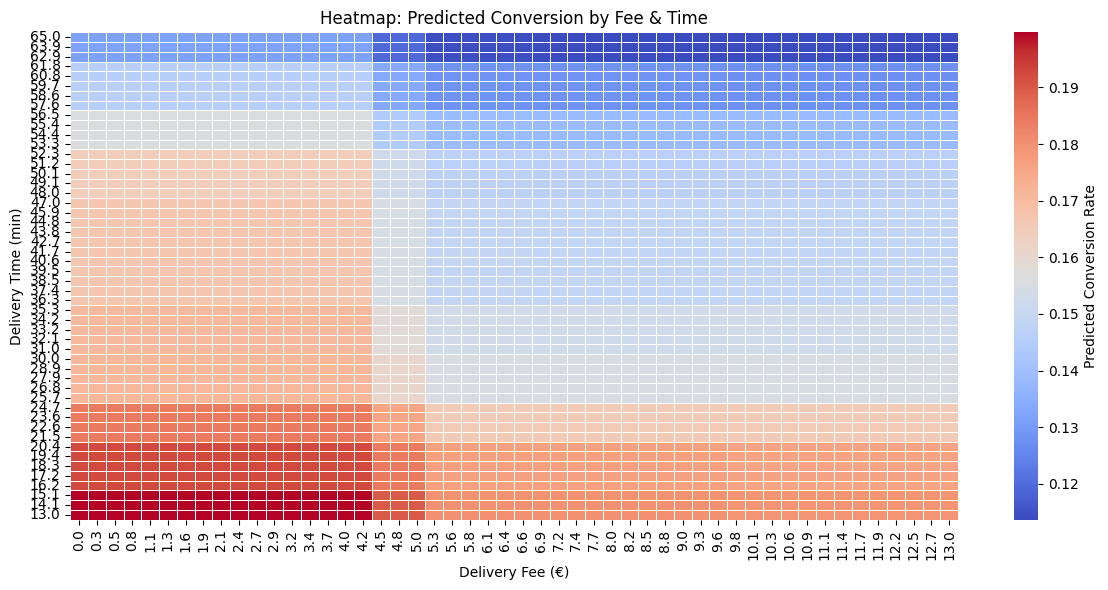

In [390]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Grid setup
fee_vals = np.linspace(df['delivery_fee_rounded'].quantile(0.01),
                       df['delivery_fee_rounded'].quantile(0.99), 50)
time_vals = np.linspace(df['average_delivery_time'].quantile(0.01),
                        df['average_delivery_time'].quantile(0.99), 50)

# Use modal values for categorical features
categorical_cols = ['distance_bucket', 'hour_of_day', 'day_of_week', 'category_name']
fixed_data = {
    'distance_bucket': df['distance_bucket'].mode()[0],
    'hour_of_day': df['hour_of_day'].mode()[0],
    'day_of_week': df['day_of_week'].mode()[0],
    'category_name': df['category_name'].mode()[0]
}

# Create a template row from X used in training (with correct dtypes/categories)
row_template = X.iloc[0].copy()

# Prepare a list to batch predict instead of row-by-row
rows = []

for t in time_vals:
    for f in fee_vals:
        row = row_template.copy()
        row['delivery_fee_rounded'] = f
        row['average_delivery_time'] = t
        for col in categorical_cols:
            row[col] = fixed_data[col]
        rows.append(row)

# Create full DataFrame for batch prediction
batch_df = pd.DataFrame(rows)

# Ensure categorical columns match training data
for col in categorical_cols:
    batch_df[col] = batch_df[col].astype('category')
    batch_df[col] = batch_df[col].cat.set_categories(X[col].cat.categories)

# Predict all at once (faster and avoids per-row errors)
preds = bst.predict(batch_df)
heatmap_data = preds.reshape(len(time_vals), len(fee_vals))

# Reverse the heatmap data along rows (time axis) for descending time
heatmap_data_sorted = np.flipud(heatmap_data)
time_vals_sorted = np.round(time_vals[::-1], 1)  # Reverse y-tick labels

# Plot sorted heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data_sorted, cmap='coolwarm', annot=False,
            xticklabels=np.round(fee_vals, 1),
            yticklabels=time_vals_sorted,
            linewidths=0.5, cbar_kws={'label': 'Predicted Conversion Rate'})

plt.xlabel('Delivery Fee (€)')
plt.ylabel('Delivery Time (min)')
plt.title('Heatmap: Predicted Conversion by Fee & Time')
plt.tight_layout()
plt.show()



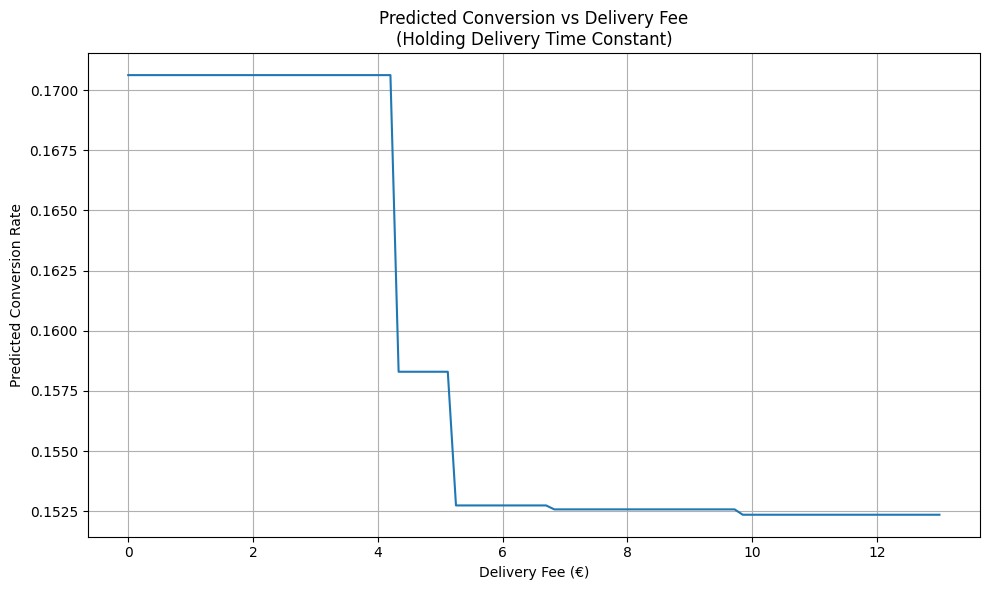

In [394]:
# --- Setup ---
avg_time = df['average_delivery_time'].mean()
fee_vals = np.linspace(df['delivery_fee_rounded'].quantile(0.01),
                       df['delivery_fee_rounded'].quantile(0.99), 100)

conversion_fee = []

for f in fee_vals:
    row = row_template.copy()
    row['delivery_fee_rounded'] = f
    row['average_delivery_time'] = avg_time
    for col in categorical_cols:
        row[col] = fixed_data[col]
    row_df = pd.DataFrame([row])
    for col in categorical_cols:
        row_df[col] = row_df[col].astype('category')
        row_df[col] = row_df[col].cat.set_categories(X[col].cat.categories)
    pred = bst.predict(row_df)[0]
    conversion_fee.append(pred)

# --- Plot Conversion vs Fee ---
plt.figure(figsize=(10, 6))
plt.plot(fee_vals, conversion_fee, label='Predicted Conversion vs Fee')
plt.xlabel('Delivery Fee (€)')
plt.ylabel('Predicted Conversion Rate')
plt.title('Predicted Conversion vs Delivery Fee\n(Holding Delivery Time Constant)')
plt.grid(True)
plt.tight_layout()
plt.show()


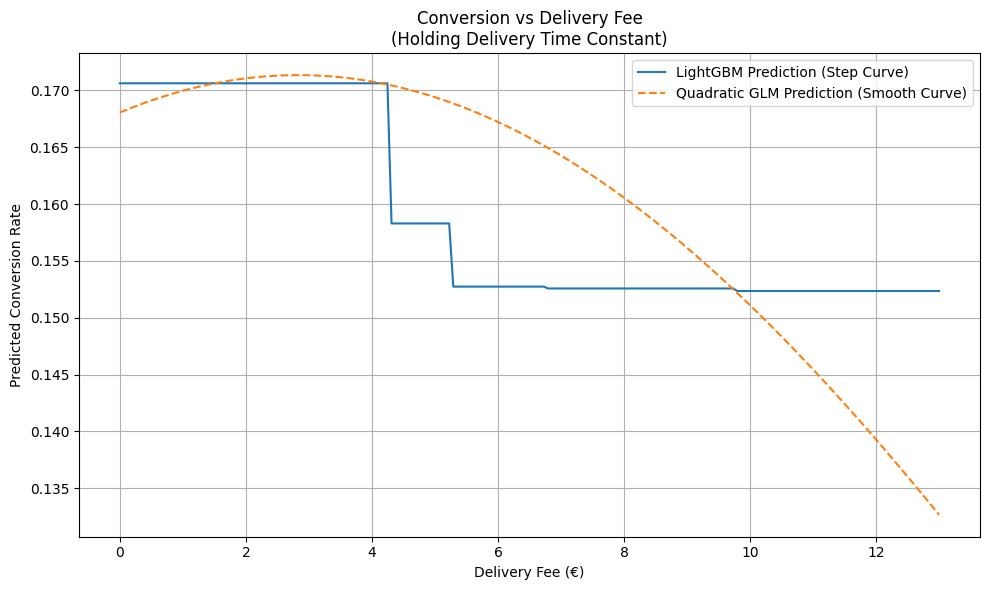

In [395]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fee sweep range
fee_vals = np.linspace(df['delivery_fee_rounded'].quantile(0.01),
                       df['delivery_fee_rounded'].quantile(0.99), 200)
avg_time = df['average_delivery_time'].mean()

# --- Predict with LightGBM ---
categorical_cols = ['distance_bucket', 'hour_of_day', 'day_of_week', 'category_name']
fixed_data = {col: df[col].mode()[0] for col in categorical_cols}
row_template = X.iloc[0].copy()

lgb_rows = []
for f in fee_vals:
    row = row_template.copy()
    row['delivery_fee_rounded'] = f
    row['average_delivery_time'] = avg_time
    for col in categorical_cols:
        row[col] = fixed_data[col]
    lgb_rows.append(row)

lgb_df = pd.DataFrame(lgb_rows)
for col in categorical_cols:
    lgb_df[col] = lgb_df[col].astype('category')
    lgb_df[col] = lgb_df[col].cat.set_categories(X[col].cat.categories)

preds_lgb = bst.predict(lgb_df)

# --- Predict with Quadratic Model ---
log_odds_quad = (intercept + coef_fee * fee_vals + coef_fee_sq * fee_vals**2 +
                 coef_time * avg_time + coef_time_sq * avg_time**2)
preds_quad = 1 / (1 + np.exp(-log_odds_quad))  # Sigmoid

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(fee_vals, preds_lgb, label='LightGBM Prediction (Step Curve)')
plt.plot(fee_vals, preds_quad, label='Quadratic GLM Prediction (Smooth Curve)', linestyle='--')
plt.xlabel('Delivery Fee (€)')
plt.ylabel('Predicted Conversion Rate')
plt.title('Conversion vs Delivery Fee\n(Holding Delivery Time Constant)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


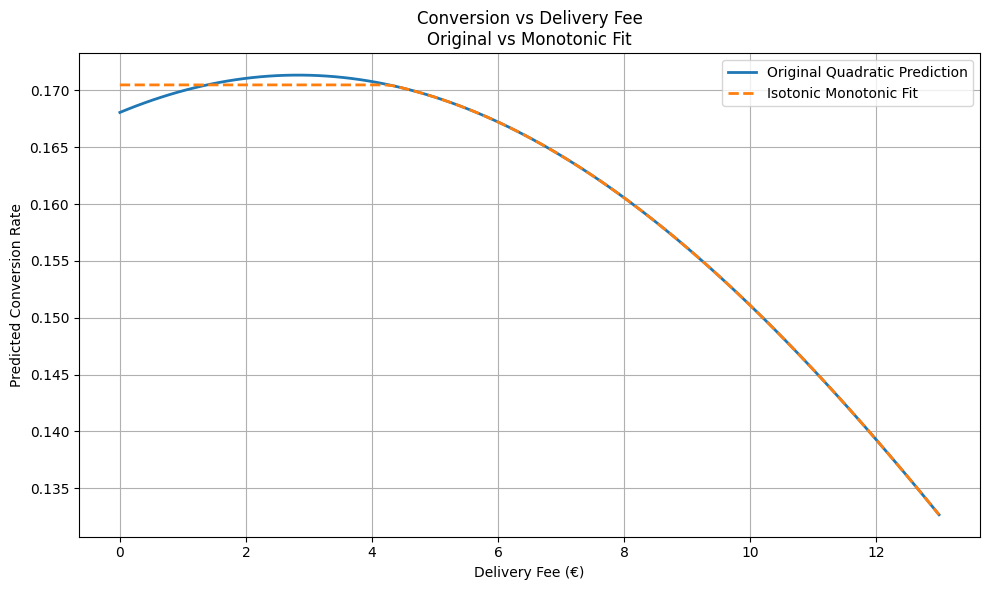

In [396]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression

# Extract coefficients from the fitted quadratic model
intercept = model_quad.params['Intercept']
coef_fee = model_quad.params['delivery_fee_rounded']
coef_fee_sq = model_quad.params['I(delivery_fee_rounded ** 2)']
coef_time = model_quad.params['average_delivery_time']
coef_time_sq = model_quad.params['I(average_delivery_time ** 2)']

# Sigmoid for probability from log-odds
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# --- Predict conversion vs fee (holding time constant) ---
avg_time = df['average_delivery_time'].mean()
fee_vals = np.linspace(df['delivery_fee_rounded'].quantile(0.01),
                       df['delivery_fee_rounded'].quantile(0.99), 100)

# Quadratic model predictions
log_odds = intercept + coef_fee * fee_vals + coef_fee_sq * fee_vals**2 + \
           coef_time * avg_time + coef_time_sq * avg_time**2
pred_conv = sigmoid(log_odds)

# --- Apply Isotonic Regression (monotonic decreasing) ---
iso = IsotonicRegression(increasing=False)
pred_conv_iso = iso.fit_transform(fee_vals, pred_conv)

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(fee_vals, pred_conv, label='Original Quadratic Prediction', linewidth=2)
plt.plot(fee_vals, pred_conv_iso, label='Isotonic Monotonic Fit', linestyle='--', linewidth=2)
plt.xlabel('Delivery Fee (€)')
plt.ylabel('Predicted Conversion Rate')
plt.title('Conversion vs Delivery Fee\nOriginal vs Monotonic Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


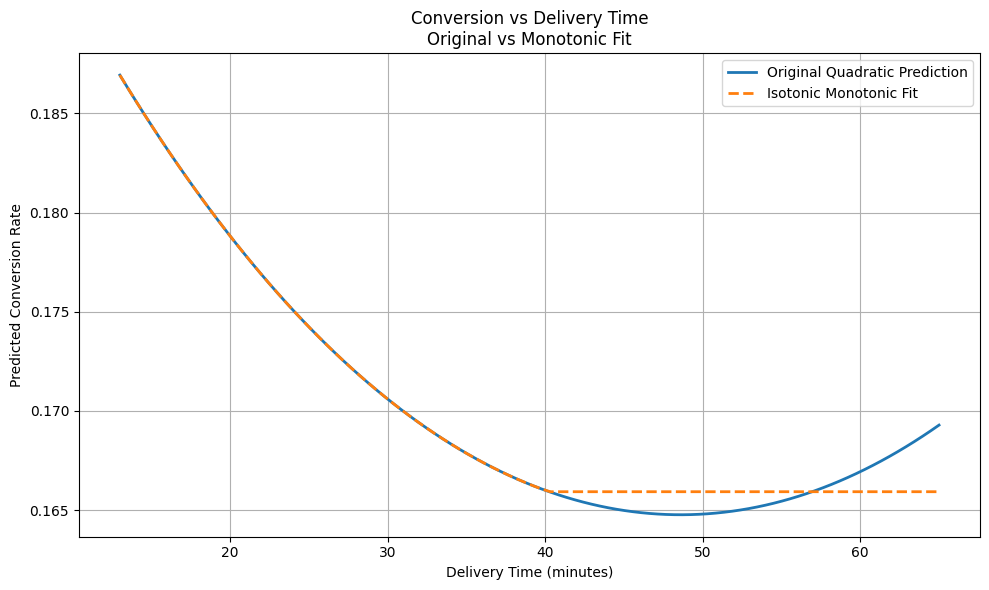

In [397]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression

# --- Reuse coefficients from the quadratic model ---
intercept = model_quad.params['Intercept']
coef_fee = model_quad.params['delivery_fee_rounded']
coef_fee_sq = model_quad.params['I(delivery_fee_rounded ** 2)']
coef_time = model_quad.params['average_delivery_time']
coef_time_sq = model_quad.params['I(average_delivery_time ** 2)']

# Sigmoid for probability from log-odds
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# --- Predict conversion vs delivery time (holding fee constant) ---
avg_fee = df['delivery_fee_rounded'].mean()
time_vals = np.linspace(df['average_delivery_time'].quantile(0.01),
                        df['average_delivery_time'].quantile(0.99), 100)

# Quadratic model predictions
log_odds_time = intercept + coef_fee * avg_fee + coef_fee_sq * avg_fee**2 + \
                coef_time * time_vals + coef_time_sq * time_vals**2
pred_conv_time = sigmoid(log_odds_time)

# --- Apply Isotonic Regression (monotonic decreasing) ---
iso_time = IsotonicRegression(increasing=False)
pred_conv_iso_time = iso_time.fit_transform(time_vals, pred_conv_time)

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(time_vals, pred_conv_time, label='Original Quadratic Prediction', linewidth=2)
plt.plot(time_vals, pred_conv_iso_time, label='Isotonic Monotonic Fit', linestyle='--', linewidth=2)
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Predicted Conversion Rate')
plt.title('Conversion vs Delivery Time\nOriginal vs Monotonic Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [364]:
import numpy as np
import pandas as pd
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load the data (assumes listings_df is already available)
df = listings_df.copy()

# Calculate 99th percentiles for outlier removal
fee_99 = df['delivery_fee_rounded'].quantile(0.99)
time_99 = df['average_delivery_time'].quantile(0.99)

# Filter out outliers
df = df[(df['delivery_fee_rounded'] <= fee_99) & (df['average_delivery_time'] <= time_99)]

# Convert relevant columns
df['all_shops'] = pd.to_numeric(df['all_shops'], errors='coerce')
df['converted_shops'] = pd.to_numeric(df['converted_shops'], errors='coerce')
df['delivery_fee_rounded'] = pd.to_numeric(df['delivery_fee_rounded'], errors='coerce')
df['average_delivery_time'] = pd.to_numeric(df['average_delivery_time'], errors='coerce')

df['hour_of_day'] = df['hour_of_day'].astype(int)
df['day_of_week'] = df['day_of_week'].astype(int)

df['failures'] = df['all_shops'] - df['converted_shops']
df['conversion_rate'] = df['converted_shops'] / df['all_shops']

# Drop missing values
df = df.dropna(subset=['all_shops', 'converted_shops', 'delivery_fee_rounded',
                       'average_delivery_time', 'failures'])

# Prepare log-transformed columns
df['log_fee'] = np.log(df['delivery_fee_rounded'] + 1e-5)
df['log_time'] = np.log(df['average_delivery_time'] + 1e-5)

# Prepare spline basis for fee and time
spline_fee = dmatrix("bs(delivery_fee_rounded, df=4, include_intercept=False)",
                     df, return_type='dataframe')
spline_time = dmatrix("bs(average_delivery_time, df=4, include_intercept=False)",
                      df, return_type='dataframe')

# Append splines to df
spline_fee.columns = [f'spline_fee_{i}' for i in range(spline_fee.shape[1])]
spline_time.columns = [f'spline_time_{i}' for i in range(spline_time.shape[1])]
df_spline = pd.concat([df.reset_index(drop=True), spline_fee, spline_time], axis=1)

# Drop any missing values after adding spline columns
df_spline = df_spline.dropna()


# Fit models
# 1. Quadratic Model
model_quad = smf.glm(formula='conversion_rate ~ delivery_fee_rounded + I(delivery_fee_rounded**2) + '
                             'average_delivery_time + I(average_delivery_time**2) + '
                             'C(distance_bucket) + C(hour_of_day) + C(day_of_week) + C(category_name)',
                     data=df,
                     family=sm.families.Binomial(),
                     freq_weights=df['all_shops']).fit()

# # 2. Log Model
# model_log = smf.glm(formula='conversion_rate ~ log_fee + log_time + '
#                             'C(distance_bucket) + C(hour_of_day) + C(day_of_week) + C(category_name)',
#                     data=df,
#                     family=sm.families.Binomial(),
#                     freq_weights=df['all_shops']).fit()

# # 3. Spline Model
# spline_vars = ' + '.join(df_spline.columns[-8:])  # 4 spline terms for fee and time
# model_spline = smf.glm(formula=f'conversion_rate ~ {spline_vars} + '
#                                'C(distance_bucket) + C(hour_of_day) + C(day_of_week) + C(category_name)',
#                        data=df_spline,
#                        family=sm.families.Binomial(),
#                        freq_weights=df_spline['all_shops']).fit()

# # Compare AIC and BIC
# model_comparison = pd.DataFrame({
#     'Model': ['Quadratic', 'Log', 'Spline'],
#     'AIC': [model_quad.aic, model_log.aic, model_spline.aic],
#     'BIC': [model_quad.bic, model_log.bic, model_spline.bic]
# })

# model_comparison

model_quad.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        conversion_rate   No. Observations:               607304
Model:                            GLM   Df Residuals:                 11372753
Model Family:                Binomial   Df Model:                           80
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.0612e+06
Date:                Mon, 17 Mar 2025   Deviance:                   5.6443e+05
Time:                        04:05:28   Pearson chi2:                 6.70e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3655
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -1.3428      0.034    -39.200      0.000      -1.410      -1.276
C(distance_bucket)[T.10+ km]                -1.5410      0.016    -96.434      0.000      -1.572      -1.510
C(distance_bucket)[T.1–3 km]                -0.2211      0.003    -85.767      0.000      -0.226      -0.216
C(distance_bucket)[T.3–5 km]                -0.4093      0.004   -108.978      0.000      -0.417      -0.402
C(distance_bucket)[T.5–10 km]               -0.7117      0.005   -131.469      0.000      -0.722      -0.701
C(hour_of_day)[T.1]                          0.1942      0.061      3.174      0.002       0.074       0.314
C(hour_of_day)[T.2]                          0.4509      0.065      6.890      0.000       0.323       0.579
C(hour_of_day)[T.3]                          0.5855      0.096      6.071      0.000       0.396       0.774
C(hour_of_day)[T.4]                          0.4054      0.097      4.188      0.000       0.216       0.595
C(hour_of_day)[T.5]                         -0.1905      0.051     -3.705      0.000      -0.291      -0.090
C(hour_of_day)[T.6]                         -0.2435      0.037     -6.526      0.000      -0.317      -0.170
C(hour_of_day)[T.7]                         -0.3944      0.035    -11.342      0.000      -0.463      -0.326
C(hour_of_day)[T.8]                         -0.3932      0.034    -11.691      0.000      -0.459      -0.327
C(hour_of_day)[T.9]                         -0.4326      0.034    -12.912      0.000      -0.498      -0.367
C(hour_of_day)[T.10]                        -0.4461      0.033    -13.320      0.000      -0.512      -0.380
C(hour_of_day)[T.11]                        -0.4657      0.033    -13.907      0.000      -0.531      -0.400
C(hour_of_day)[T.12]                        -0.4428      0.033    -13.227      0.000      -0.508      -0.377
C(hour_of_day)[T.13]                        -0.4470      0.033    -13.363      0.000      -0.513      -0.381
C(hour_of_day)[T.14]                        -0.4538      0.033    -13.577      0.000      -0.519      -0.388
C(hour_of_day)[T.15]                        -0.4657      0.033    -13.937      0.000      -0.531      -0.400
C(hour_of_day)[T.16]                        -0.4677      0.033    -13.993      0.000      -0.533      -0.402
C(hour_of_day)[T.17]                        -0.4545      0.033    -13.590      0.000      -0.520      -0.389
C(hour_of_day)[T.18]                        -0.4097      0.033    -12.238      0.000      -0.475      -0.344
C(hour_of_day)[T.19]                        -0.3383      0.034    -10.080      0.000      -0.404      -0.272
C(hour_of_day)[T.20]                        -0.2501      0.034     -7.408      0.000      -0.316      -0.184
C(hour_of_day)[T.21]           

In [366]:
# # Extract coefficients
# beta_0 = model_quad.params['Intercept']
# beta_1 = model_quad.params['delivery_fee_rounded']
# beta_2 = model_quad.params['I(delivery_fee_rounded ** 2)']
# beta_3 = model_quad.params['average_delivery_time']
# beta_4 = model_quad.params['I(average_delivery_time ** 2)']

# # Choose point: average fee and average time
# avg_fee = df['delivery_fee_rounded'].mean()
# avg_time = df['average_delivery_time'].mean()

# # Log-odds and probability at this point
# log_odds = beta_0 + beta_1 * avg_fee + beta_2 * avg_fee**2 + beta_3 * avg_time + beta_4 * avg_time**2
# p = 1 / (1 + np.exp(-log_odds))

# # Elasticity of fee at this point
# elasticity_fee = (1 - p) * (beta_1 + 2 * beta_2 * avg_fee) * avg_fee

# print(f"Predicted conversion rate at average point: {p:.4f}")
# print(f"Elasticity of conversion w.r.t. delivery fee at average point: {elasticity_fee:.4f}")


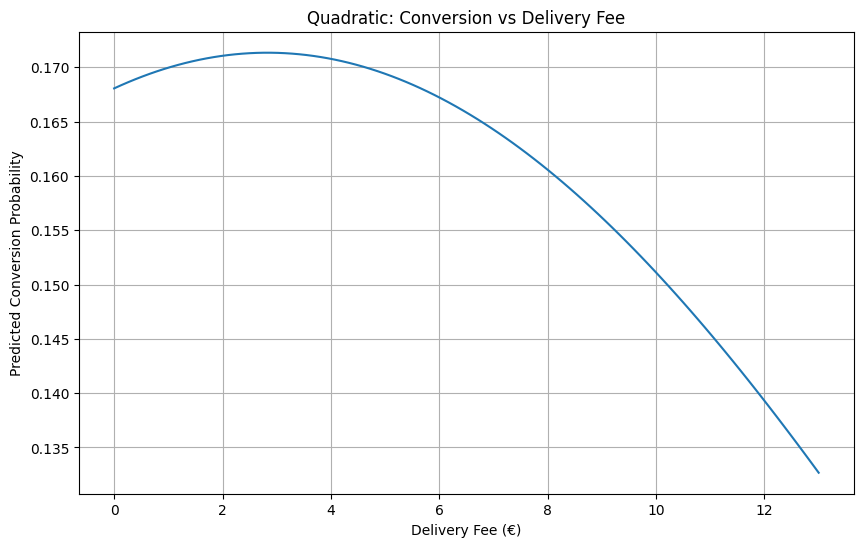

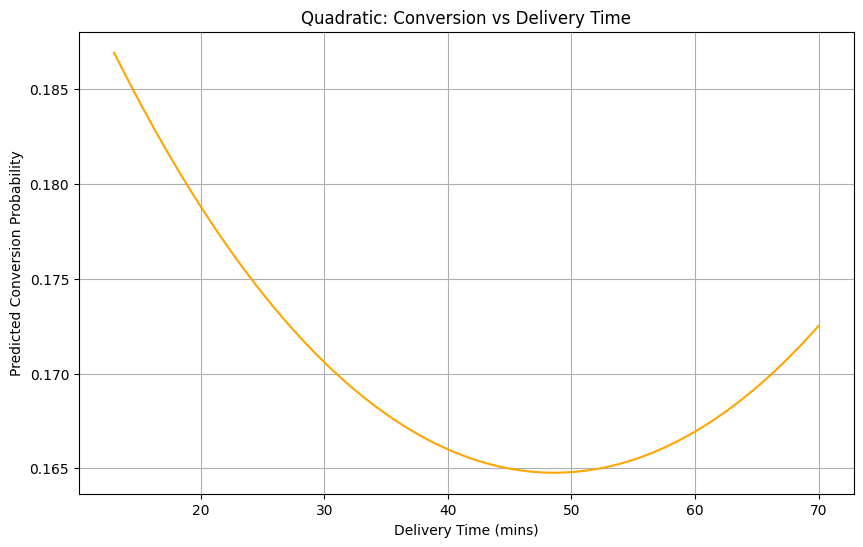

In [367]:
# Extract coefficients from quadratic model
coef_fee = model_quad.params['delivery_fee_rounded']
coef_fee_sq = model_quad.params['I(delivery_fee_rounded ** 2)']
coef_time = model_quad.params['average_delivery_time']
coef_time_sq = model_quad.params['I(average_delivery_time ** 2)']
intercept = model_quad.params['Intercept']

# Sigmoid remains the same
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# --- Marginal Effect of Delivery Fee (Quadratic) ---
avg_time = df['average_delivery_time'].mean()
fee_range = np.linspace(df['delivery_fee_rounded'].min(), df['delivery_fee_rounded'].max(), 100)
log_odds_fee = (intercept +
                coef_fee * fee_range +
                coef_fee_sq * (fee_range ** 2) +
                coef_time * avg_time +
                coef_time_sq * (avg_time ** 2))
prob_conversion_fee = sigmoid(log_odds_fee)

# --- Marginal Effect of Delivery Time (Quadratic) ---
avg_fee = df['delivery_fee_rounded'].mean()
time_range = np.linspace(df['average_delivery_time'].min(), df['average_delivery_time'].max(), 100)
log_odds_time = (intercept +
                 coef_fee * avg_fee +
                 coef_fee_sq * (avg_fee ** 2) +
                 coef_time * time_range +
                 coef_time_sq * (time_range ** 2))
prob_conversion_time = sigmoid(log_odds_time)

# Plot Fee Effect (Quadratic)
plt.figure(figsize=(10, 6))
plt.plot(fee_range, prob_conversion_fee)
plt.xlabel('Delivery Fee (€)')
plt.ylabel('Predicted Conversion Probability')
plt.title('Quadratic: Conversion vs Delivery Fee')
plt.grid(True)
plt.show()

# Plot Time Effect (Quadratic)
plt.figure(figsize=(10, 6))
plt.plot(time_range, prob_conversion_time, color='orange')
plt.xlabel('Delivery Time (mins)')
plt.ylabel('Predicted Conversion Probability')
plt.title('Quadratic: Conversion vs Delivery Time')
plt.grid(True)
plt.show()


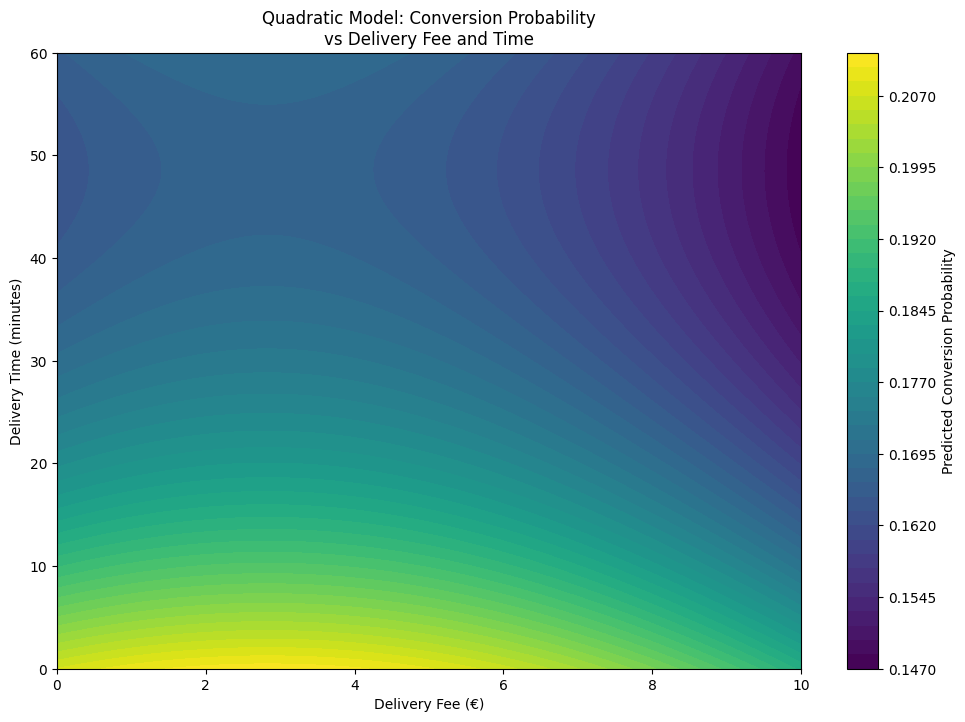

In [368]:
import numpy as np
import matplotlib.pyplot as plt

# Extract coefficients from the quadratic model
coef_fee = model_quad.params['delivery_fee_rounded']
coef_fee_sq = model_quad.params['I(delivery_fee_rounded ** 2)']
coef_time = model_quad.params['average_delivery_time']
coef_time_sq = model_quad.params['I(average_delivery_time ** 2)']
intercept = model_quad.params['Intercept']

# Sigmoid function to convert log-odds to probability
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Create meshgrid of delivery fee and time values
fee_vals = np.linspace(0, 10, 100)    # Delivery Fee (€)
time_vals = np.linspace(0, 60, 100)   # Delivery Time (minutes)
fee_grid, time_grid = np.meshgrid(fee_vals, time_vals)

# Compute squared terms for grid
fee_sq_grid = fee_grid ** 2
time_sq_grid = time_grid ** 2

# Calculate log-odds for each point on grid using quadratic terms
log_odds_grid = (
    intercept +
    coef_fee * fee_grid + coef_fee_sq * fee_sq_grid +
    coef_time * time_grid + coef_time_sq * time_sq_grid
)

# Convert log-odds to predicted conversion probability
prob_grid = sigmoid(log_odds_grid)

# Plot heatmap of predicted conversion probability
plt.figure(figsize=(12, 8))
contour = plt.contourf(fee_grid, time_grid, prob_grid, levels=50, cmap='viridis')
plt.colorbar(contour, label='Predicted Conversion Probability')
plt.xlabel('Delivery Fee (€)')
plt.ylabel('Delivery Time (minutes)')
plt.title('Quadratic Model: Conversion Probability\nvs Delivery Fee and Time')
plt.show()


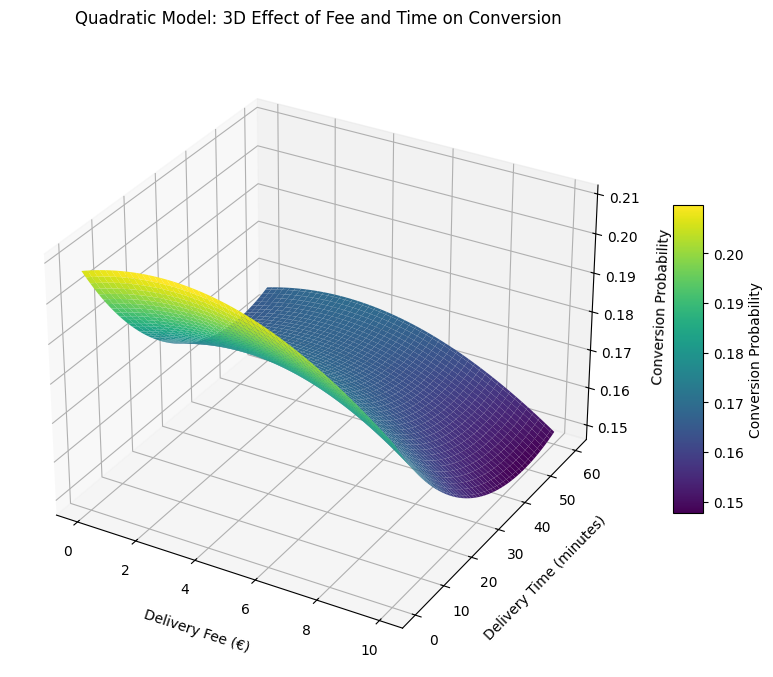

In [369]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Assuming prob_grid, fee_grid, time_grid have already been computed as in the previous heatmap code

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(fee_grid, time_grid, prob_grid, cmap='viridis', edgecolor='none')

# Labels and title
ax.set_xlabel('Delivery Fee (€)', labelpad=10)
ax.set_ylabel('Delivery Time (minutes)', labelpad=10)
ax.set_zlabel('Conversion Probability', labelpad=10)
ax.set_title('Quadratic Model: 3D Effect of Fee and Time on Conversion', pad=20)

# Add color bar for conversion probability
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Conversion Probability')

plt.show()


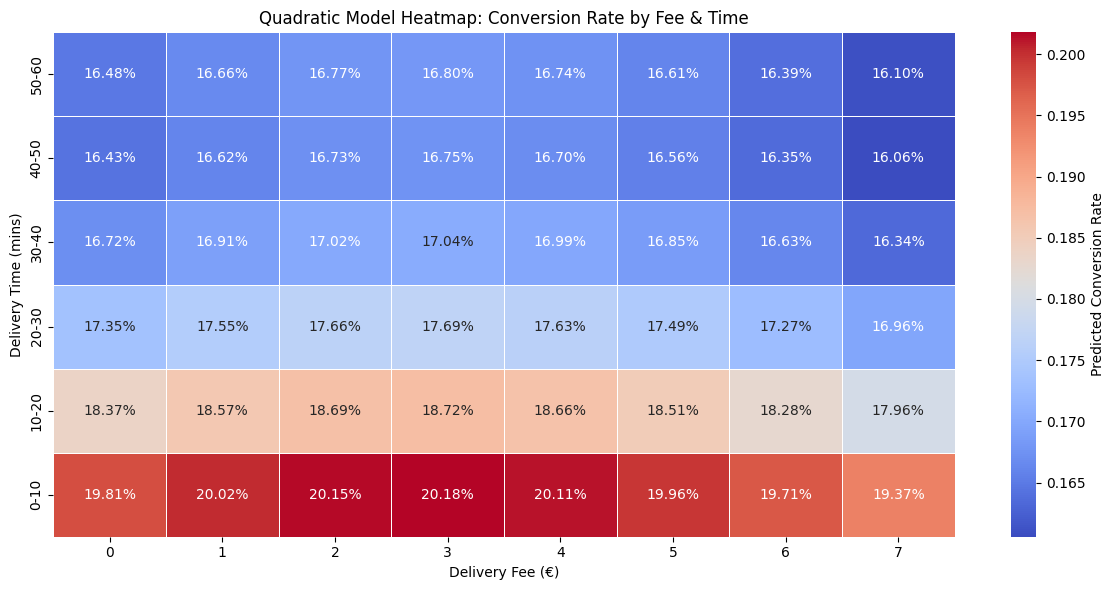

In [370]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Coefficients from the quadratic model ---
coef_fee = model_quad.params['delivery_fee_rounded']
coef_fee_sq = model_quad.params['I(delivery_fee_rounded ** 2)']
coef_time = model_quad.params['average_delivery_time']
coef_time_sq = model_quad.params['I(average_delivery_time ** 2)']
intercept = model_quad.params['Intercept']

# Sigmoid function for probability
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Prepare fee and time bins
fee_bins = np.arange(0, 8, 1)  # 0 to 7 €
time_bins = np.arange(0, 70, 10)  # 0 to 60 mins

heatmap_data = []

for t in time_bins[:-1]:
    row = []
    time_mid = t + 5  # midpoint of time bin
    for f in fee_bins:
        # Quadratic log-odds
        log_odds = (intercept +
                    coef_fee * f + coef_fee_sq * f**2 +
                    coef_time * time_mid + coef_time_sq * time_mid**2)
        prob = sigmoid(log_odds)
        row.append(prob)
    heatmap_data.append(row)

# Convert to DataFrame
heatmap_df = pd.DataFrame(heatmap_data, index=time_bins[:-1], columns=fee_bins)

# Create time labels and force reverse sorting for y-axis
time_labels = [f"{t}-{t+10}" for t in time_bins[:-1]]
heatmap_df.index = pd.CategoricalIndex(time_labels, ordered=True, categories=time_labels[::-1])

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_df.sort_index(),  # Sort by categorical index
    cmap='coolwarm', annot=True, fmt=".2%", linewidths=0.5,
    cbar_kws={'label': 'Predicted Conversion Rate'}
)

plt.xlabel("Delivery Fee (€)")
plt.ylabel("Delivery Time (mins)")
plt.title("Quadratic Model Heatmap: Conversion Rate by Fee & Time")
plt.tight_layout()
plt.show()


In [350]:
import statsmodels.formula.api as smf

df = listings_df.copy()

# Calculate 99th percentiles
fee_99 = df['delivery_fee_rounded'].quantile(0.99)
time_99 = df['average_delivery_time'].quantile(0.99)

# Filter rows below the 99th percentile
df = df[(df['delivery_fee_rounded'] <= fee_99) & 
              (df['average_delivery_time'] <= time_99)]


# 1–4: Same preprocessing steps as before
df['all_shops'] = pd.to_numeric(df['all_shops'], errors='coerce')
df['converted_shops'] = pd.to_numeric(df['converted_shops'], errors='coerce')
df['delivery_fee_rounded'] = pd.to_numeric(df['delivery_fee_rounded'], errors='coerce')
df['average_delivery_time'] = pd.to_numeric(df['average_delivery_time'], errors='coerce')

df['hour_of_day'] = df['hour_of_day'].astype(int)
df['day_of_week'] = df['day_of_week'].astype(int)

df['delivery_time_sq'] = df['average_delivery_time'] ** 2
df['delivery_fee_rounded_sq'] = df['delivery_fee_rounded'] ** 2

df['failures'] = df['all_shops'] - df['converted_shops']
df = df.dropna(subset=['all_shops','converted_shops','delivery_fee_rounded',
                       'average_delivery_time','failures'])

df['conversion_rate'] = df['converted_shops'] / df['all_shops']


# 5) Fit GLM with formula interface
model = smf.glm(formula='conversion_rate ~ delivery_fee_rounded + delivery_fee_rounded_sq + average_delivery_time + delivery_time_sq +  C(distance_bucket) + C(hour_of_day) + C(day_of_week) + C(category_name)' ,
                data=df,
                family=sm.families.Binomial(),
                freq_weights=df['all_shops'])

results = model.fit()

# 6) Summary
print(results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:        conversion_rate   No. Observations:               671983
Model:                            GLM   Df Residuals:                 66123360
Model Family:                Binomial   Df Model:                           93
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.8772e+07
Date:                Mon, 17 Mar 2025   Deviance:                   9.3358e+05
Time:                        03:59:10   Pearson chi2:                 9.44e+05
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5717
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

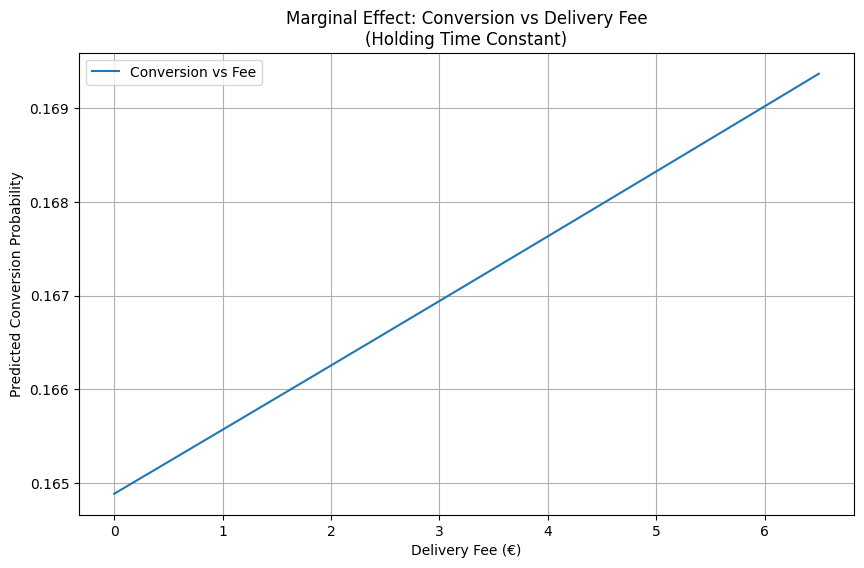

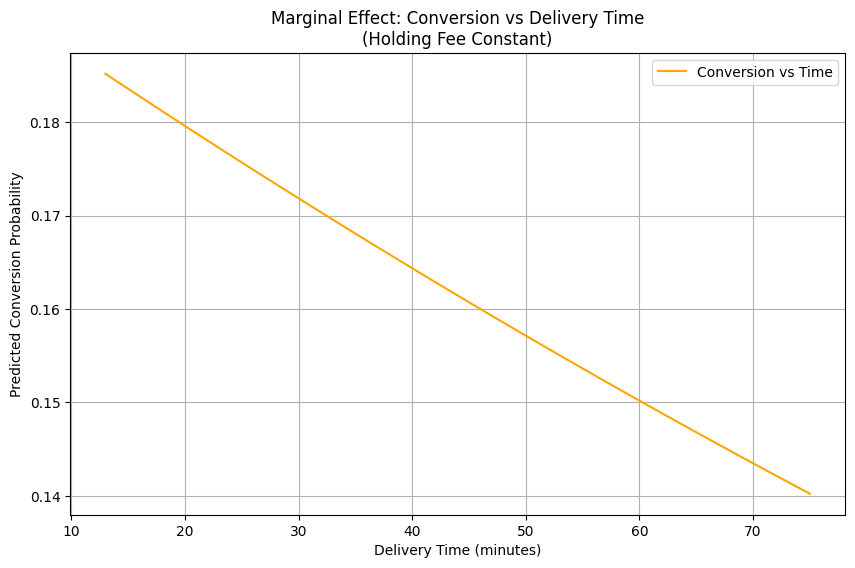

In [305]:
import numpy as np
import matplotlib.pyplot as plt

# Extract coefficients directly from the fitted model
coef_fee = results.params['delivery_fee_rounded']
coef_time = results.params['average_delivery_time']
intercept = results.params['Intercept']

# Define sigmoid for probability conversion
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# ---- Marginal Effect of Delivery Fee ----
avg_time = df['average_delivery_time'].mean()  # Get actual average from data
fee_range = np.linspace(df['delivery_fee_rounded'].min(), df['delivery_fee_rounded'].max(), 100)
log_odds_fee = intercept + coef_fee * fee_range + coef_time * avg_time
prob_conversion_fee = sigmoid(log_odds_fee)

# ---- Marginal Effect of Delivery Time ----
avg_fee = df['delivery_fee_rounded'].mean()  # Get actual average from data
time_range = np.linspace(df['average_delivery_time'].min(), df['average_delivery_time'].max(), 100)
log_odds_time = intercept + coef_fee * avg_fee + coef_time * time_range
prob_conversion_time = sigmoid(log_odds_time)

# Plot: Conversion vs Delivery Fee
plt.figure(figsize=(10, 6))
plt.plot(fee_range, prob_conversion_fee, label='Conversion vs Fee')
plt.xlabel('Delivery Fee (€)')
plt.ylabel('Predicted Conversion Probability')
plt.title('Marginal Effect: Conversion vs Delivery Fee\n(Holding Time Constant)')
plt.grid(True)
plt.legend()
plt.show()

# Plot: Conversion vs Delivery Time
plt.figure(figsize=(10, 6))
plt.plot(time_range, prob_conversion_time, label='Conversion vs Time', color='orange')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Predicted Conversion Probability')
plt.title('Marginal Effect: Conversion vs Delivery Time\n(Holding Fee Constant)')
plt.grid(True)
plt.legend()
plt.show()


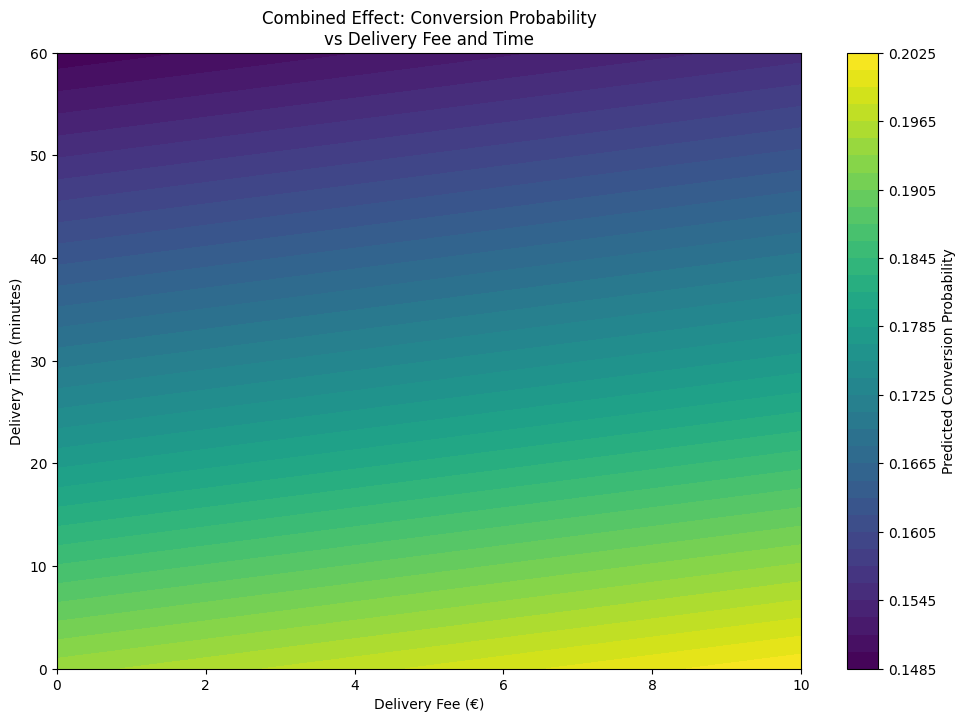

In [306]:
import numpy as np
import matplotlib.pyplot as plt

# Extract coefficients directly from the fitted model
coef_fee = results.params['delivery_fee_rounded']
coef_time = results.params['average_delivery_time']
intercept = results.params['Intercept']

# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Create meshgrid of delivery fee and time values
fee_vals = np.linspace(0, 10, 100)   # Fee from 0 to 10 €
time_vals = np.linspace(0, 60, 100)  # Time from 0 to 60 mins
fee_grid, time_grid = np.meshgrid(fee_vals, time_vals)

# Calculate log-odds and predicted probability for each point on grid
log_odds_grid = intercept + coef_fee * fee_grid + coef_time * time_grid
prob_grid = sigmoid(log_odds_grid)

# Plot heatmap
plt.figure(figsize=(12, 8))
contour = plt.contourf(fee_grid, time_grid, prob_grid, levels=50, cmap='viridis')
plt.colorbar(contour, label='Predicted Conversion Probability')
plt.xlabel('Delivery Fee (€)')
plt.ylabel('Delivery Time (minutes)')
plt.title('Combined Effect: Conversion Probability\nvs Delivery Fee and Time')
plt.show()


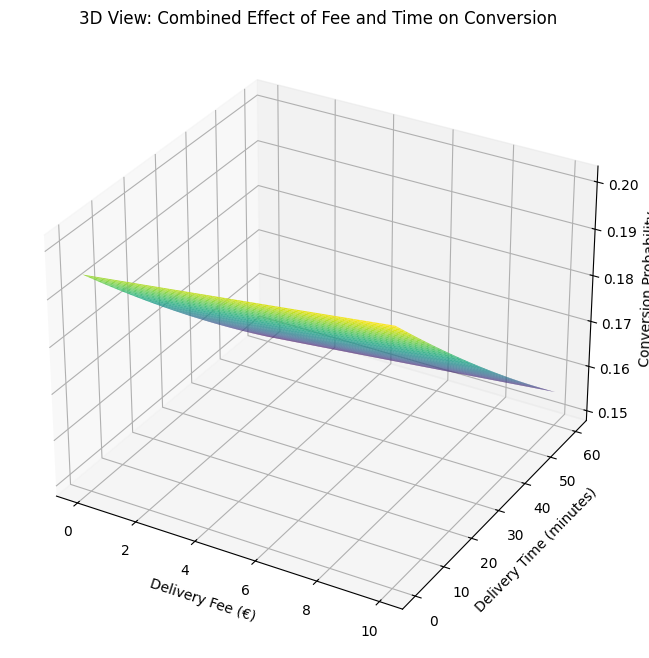

In [307]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(fee_grid, time_grid, prob_grid, cmap='viridis', edgecolor='none')
ax.set_xlabel('Delivery Fee (€)')
ax.set_ylabel('Delivery Time (minutes)')
ax.set_zlabel('Conversion Probability')
ax.set_title('3D View: Combined Effect of Fee and Time on Conversion')
plt.show()


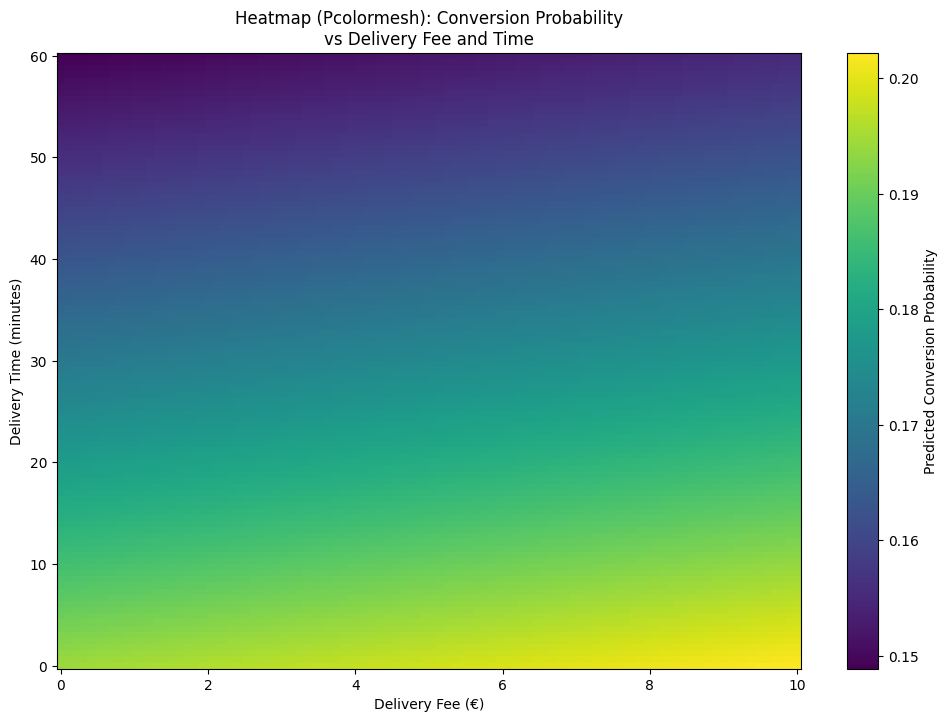

In [308]:
plt.figure(figsize=(12, 8))
pcm = plt.pcolormesh(fee_grid, time_grid, prob_grid, cmap='viridis', shading='auto')
plt.colorbar(pcm, label='Predicted Conversion Probability')
plt.xlabel('Delivery Fee (€)')
plt.ylabel('Delivery Time (minutes)')
plt.title('Heatmap (Pcolormesh): Conversion Probability\nvs Delivery Fee and Time')
plt.show()


In [313]:
# Prepare fee and time bins
fee_bins = np.arange(0, 8, 1)  # 0 to 10
time_bins = np.arange(0, 70, 10)  # 0 to 60

heatmap_data = []

for t in time_bins[:-1]:
    row = []
    for f in fee_bins:
        log_odds = intercept + coef_fee * f + coef_time * (t + 5)  # midpoint of bin
        prob = sigmoid(log_odds)
        row.append(prob)
    heatmap_data.append(row)

heatmap_data = pd.DataFrame(heatmap_data, index=time_bins[:-1], columns=fee_bins)


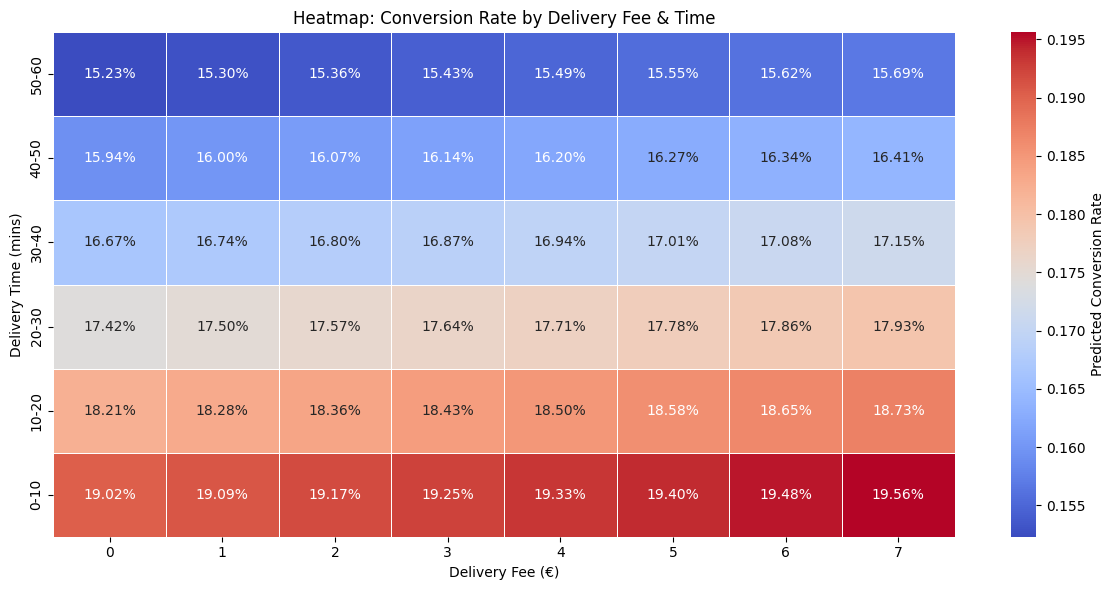

In [314]:
# Force sorting of y-axis labels numerically
time_labels = [f"{t}-{t+10}" for t in time_bins[:-1]]
heatmap_data.index = pd.CategoricalIndex(time_labels, ordered=True, categories=time_labels[::-1])  # reverse order for top-down

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data.sort_index(),  # sort by categorical index
    cmap='coolwarm', annot=True, fmt=".2%", linewidths=0.5,
    cbar_kws={'label': 'Predicted Conversion Rate'}
)

plt.xlabel("Delivery Fee (€)")
plt.ylabel("Delivery Time (mins)")
plt.title("Heatmap: Conversion Rate by Delivery Fee & Time")
plt.tight_layout()
plt.show()


<Axes: >

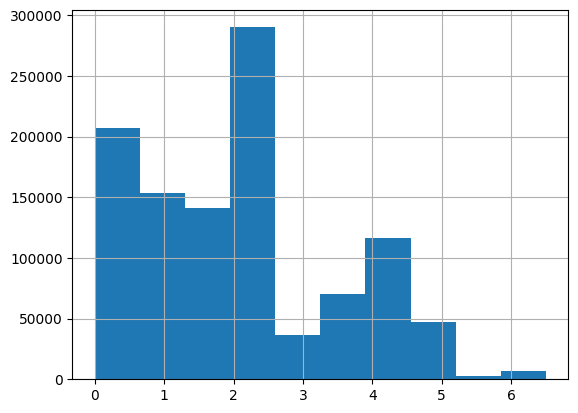

In [312]:
df['delivery_fee_rounded'].hist()

In [216]:
# import numpy as np

# # 1) Extract model coefficients
# betas = results.params

# # 2) Compute mean values of continuous predictors
# X_mean = df[['delivery_fee_rounded', 'average_delivery_time']].mean()

# # 3) Create a DataFrame for prediction at mean values
# # Use the most common or baseline category of distance_bucket
# # Example: assume '0-2km' is the baseline; adjust as per your data
# baseline_bucket = df['distance_bucket'].mode()[0]

# predict_df = pd.DataFrame({
#     'delivery_fee_rounded': [X_mean['delivery_fee_rounded']],
#     'average_delivery_time': [X_mean['average_delivery_time']],
#     'distance_bucket': [baseline_bucket]
# })

# # 4) Predict conversion probability at mean values
# P_mean = results.predict(predict_df)[0]

# # 5) Compute elasticity for delivery_fee_rounded and average_delivery_time
# elasticity_fee = betas['delivery_fee_rounded'] * X_mean['delivery_fee_rounded'] * (1 - P_mean)
# elasticity_time = betas['average_delivery_time'] * X_mean['average_delivery_time'] * (1 - P_mean)

# # 6) Print elasticity values
# print(f"Elasticity w.r.t. delivery_fee_rounded: {elasticity_fee:.4f}")
# print(f"Elasticity w.r.t. average_delivery_time: {elasticity_time:.4f}")


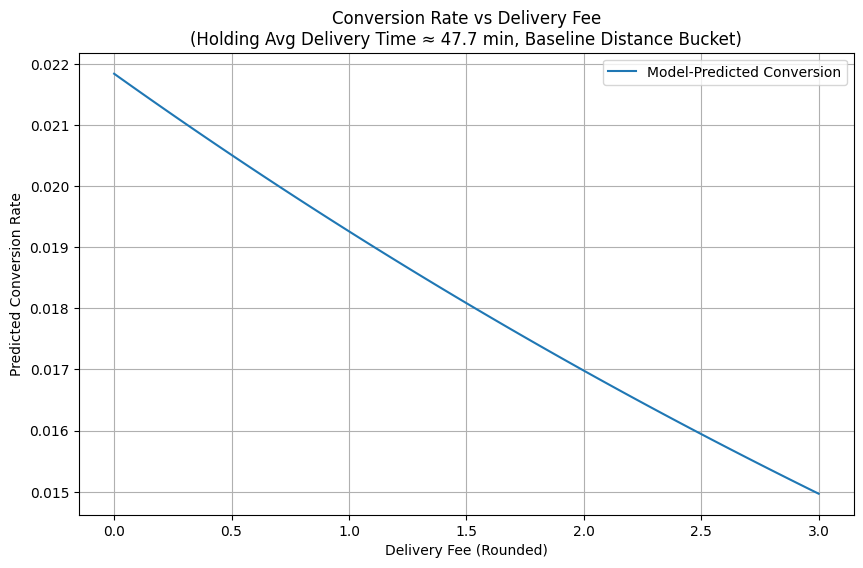

In [177]:
import numpy as np
import matplotlib.pyplot as plt

# Extract coefficients
betas = results.params
intercept = betas['Intercept']
beta_fee = betas['delivery_fee_rounded']
beta_time = betas['average_delivery_time']

# Hold average_delivery_time constant at its mean
avg_time = df['average_delivery_time'].mean()

# Create a range of delivery fees
fee_min = df['delivery_fee_rounded'].min()
fee_max = df['delivery_fee_rounded'].max()
fee_range = np.linspace(fee_min, fee_max, 100)

# Compute log-odds and predicted conversion rate for each fee
log_odds = intercept + beta_fee * fee_range + beta_time * avg_time
predicted_conversion = 1 / (1 + np.exp(-log_odds))  # Logistic function

# Plot
plt.figure(figsize=(10, 6))
plt.plot(fee_range, predicted_conversion, label='Model-Predicted Conversion')
plt.xlabel('Delivery Fee (Rounded)')
plt.ylabel('Predicted Conversion Rate')
plt.title(f'Conversion Rate vs Delivery Fee\n(Holding Avg Delivery Time ≈ {avg_time:.1f} min, Baseline Distance Bucket)')
plt.grid(True)
plt.legend()
plt.show()


In [179]:
# import numpy as np
# import pandas as pd
# import statsmodels.api as sm

# # Copy the dataframe
# df = listings_df.copy()

# # Log-transform the variables
# df['log_delivery_fee'] = np.log1p(df['delivery_fee_rounded'])
# df['log_delivery_time'] = np.log1p(df['average_delivery_time'])
# df['log_conversion_rate'] = np.log1p(df['conversion_rate'])

# # Create dummy variables for categorical predictors
# df = pd.get_dummies(df, columns=['hour_of_day', 'day_of_week'], drop_first=True)

# # Define predictors (X) and dependent variable (y)
# predictor_columns = ['log_delivery_fee', 'log_delivery_time'] + list(df.filter(like='hour_of_day_').columns) + list(df.filter(like='day_of_week_').columns)
# X = df[predictor_columns]
# y = df['log_conversion_rate']

# # Add a constant to the predictors
# X = sm.add_constant(X)

# # Ensure X and y are numeric
# X = np.asarray(X, dtype=float)
# y = np.asarray(y, dtype=float)

# # Fit the log-log regression model
# model = sm.OLS(y, X).fit()

# # Get the column names of the predictors (including the constant)
# column_names = ['const'] + predictor_columns

# # Convert X to a DataFrame with the correct column names before fitting the model
# X = pd.DataFrame(X, columns=column_names)

# # Re-fit the model using the DataFrame with correct column names
# model_refit = sm.OLS(y, X).fit()

# # Display the full summary with actual variable names
# print(model_refit.summary2())


In [159]:
# import numpy as np
# import pandas as pd
# import statsmodels.api as sm
# import statsmodels.formula.api as smf

# # Add a column for failures (non-conversions)
# df['failures'] = df['all_shops'] - df['converted_shops']

# # Fit the Binomial GLM model
# model = smf.glm(
#     formula="converted_shops + failures ~ delivery_fee_rounded + average_delivery_time",
#     data=df,
#     family=sm.families.Binomial()
# ).fit()

# # Print the model summary
# print(model.summary())

# # Extract coefficients
# coefficients = model.params
# print("Coefficients:", coefficients)

# # Compute elasticity for each observation
# X = df[['delivery_fee_rounded', 'average_delivery_time']]
# X = sm.add_constant(X)  # Add intercept
# p = model.predict(X)  # Predicted probabilities

# # Elasticity for delivery_fee_rounded
# beta_delivery_fee = coefficients['delivery_fee_rounded']
# elasticity_delivery_fee = beta_delivery_fee * (1 - p) * df['delivery_fee_rounded']

# # Elasticity for average_delivery_time
# beta_delivery_time = coefficients['average_delivery_time']
# elasticity_delivery_time = beta_delivery_time * (1 - p) * df['average_delivery_time']

# # Add elasticity to the DataFrame
# df['elasticity_delivery_fee'] = elasticity_delivery_fee
# df['elasticity_delivery_time'] = elasticity_delivery_time

# # Print elasticity for each observation
# print(df[['delivery_fee_rounded', 'average_delivery_time', 'elasticity_delivery_fee', 'elasticity_delivery_time']])

# # Compute overall elasticity (average elasticity across all observations)
# overall_elasticity_delivery_fee = elasticity_delivery_fee.mean()
# overall_elasticity_delivery_time = elasticity_delivery_time.mean()

# print("\nOverall Elasticity:")
# print(f"Delivery Fee Rounded: {overall_elasticity_delivery_fee:.4f}")
# print(f"Average Delivery Time: {overall_elasticity_delivery_time:.4f}")

In [171]:
# import statsmodels.api as sm
# import pandas as pd
# import numpy as np

# # 1) Convert columns to numeric
# df['all_shops'] = pd.to_numeric(df['all_shops'], errors='coerce')
# df['converted_shops'] = pd.to_numeric(df['converted_shops'], errors='coerce')
# df['delivery_fee_rounded'] = pd.to_numeric(df['delivery_fee_rounded'], errors='coerce')
# df['average_delivery_time'] = pd.to_numeric(df['average_delivery_time'], errors='coerce')

# # 2) Create failures column
# df['failures'] = df['all_shops'] - df['converted_shops']

# # 3) Drop NaNs
# df = df.dropna(subset=['all_shops','converted_shops','delivery_fee_rounded',
#                        'average_delivery_time','failures'])

# # 4) Create response variable as conversion rate
# df['conversion_rate'] = df['converted_shops'] / df['all_shops']

# # 5) Define predictor matrix X and add intercept
# X = df[['delivery_fee_rounded','average_delivery_time']].values
# X = sm.add_constant(X)

# # 6) Fit binomial logistic model using conversion rate and all_shops as weights
# model = sm.GLM(df['conversion_rate'], X, family=sm.families.Binomial(), freq_weights=df['all_shops'])
# results = model.fit()

# # 7) Print summary
# print(results.summary())


const                   -3.992314
delivery_fee_rounded    -0.251254
average_delivery_time   -0.001558
dtype: float64


In [172]:
# Means of predictors
X_mean = X[['delivery_fee_rounded', 'average_delivery_time']].mean()
X_mean_with_const = [1, X_mean['delivery_fee_rounded'], X_mean['average_delivery_time']]

# Predicted probability at the mean
P_mean = results.predict([X_mean_with_const])[0]

# Coefficients with correct keys
betas = results.params

# Elasticity at mean
elasticity_fee = betas['delivery_fee_rounded'] * X_mean['delivery_fee_rounded'] * (1 - P_mean)
elasticity_time = betas['average_delivery_time'] * X_mean['average_delivery_time'] * (1 - P_mean)

print(f"Elasticity w.r.t. delivery_fee_rounded: {elasticity_fee:.4f}")
print(f"Elasticity w.r.t. average_delivery_time: {elasticity_time:.4f}")


Elasticity w.r.t. delivery_fee_rounded: -0.2552
Elasticity w.r.t. average_delivery_time: -0.0733


In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Example data
df = pd.DataFrame({
    'clicked': [2, 5, 0, 7],
    'viewed':  [10, 10, 10, 10],
    'fee':     [2.99, 4.99, 1.50, 3.00],
    'time':    [30, 60, 45, 20],
    'otherCov': [1, 2, 1, 2]
})

# Proportion of shops clicked
df['prop'] = df['clicked'] / df['viewed']

# Fit binomial logistic regression using 'prop' as the response,
# and 'viewed' as the frequency weight
model = smf.glm(
    formula='prop ~ fee + time + otherCov',
    data=df,
    family=sm.families.Binomial(),
    freq_weights=df['viewed']
).fit()

print(model.summary())


In [123]:
# Add a column for failures (non-conversions)
df['failures'] = df['all_shops'] - df['converted_shops']

# Fit the Binomial GLM model
model = smf.glm(
    formula="converted_shops + failures ~ delivery_fee_rounded + average_delivery_time",  # Predictors
    data=df,
    family=sm.families.Binomial()
).fit()

# Print the model summary
print(model.summary())

                        Generalized Linear Model Regression Results                        
Dep. Variable:     ['converted_shops', 'failures']   No. Observations:                 1164
Model:                                         GLM   Df Residuals:                     1161
Model Family:                             Binomial   Df Model:                            2
Link Function:                               Logit   Scale:                          1.0000
Method:                                       IRLS   Log-Likelihood:                -19904.
Date:                             Mon, 17 Mar 2025   Deviance:                       36873.
Time:                                     01:01:53   Pearson chi2:                 3.97e+04
No. Iterations:                                  8   Pseudo R-squ. (CS):             0.9995
Covariance Type:                         nonrobust                                         
                            coef    std err          z      P>|z|      [0.025   

In [106]:
import statsmodels.formula.api as smf

listings_df['delivery_fee_rounded_sq'] = listings_df['delivery_fee_rounded'] ** 2
listings_df['average_delivery_time_sq'] = listings_df['average_delivery_time'] ** 2
listings_df['fee_x_time'] = listings_df['delivery_fee_rounded'] * listings_df['average_delivery_time']
listings_df['hour_of_day'] = listings_df['hour_of_day'].astype(int)
listings_df['day_of_week'] = listings_df['day_of_week'].astype(int)


# Log-transform fee and time
listings_df["log_fee"] = np.log1p(listings_df["delivery_fee_rounded"])
listings_df["log_time"] = np.log1p(listings_df["average_delivery_time"])
listings_df["log_conversion"] = np.log1p(listings_df["conversion_rate"])
listings_df['log_delivery_fee_sq'] = listings_df['log_fee'] ** 2

# model = smf.glm(
#     formula="""
#         conversion_rate ~ delivery_fee_rounded + delivery_fee_rounded_sq + average_delivery_time + fee_x_time + C(locationCity) + C(distance_bucket)
#     """,
#     data=listings_df,
#     family=sm.families.Binomial(),
#     freq_weights=listings_df['all_shops']
# ).fit()

# print(model.summary())

# model = smf.glm(
#     formula="""
#        conversion_rate ~ delivery_fee_rounded + delivery_fee_rounded_sq + average_delivery_time + average_delivery_time_sq + C(hour_of_day) + C(day_of_week)  + C(distance_bucket) + C(locationCity)
#     """,
#     data=listings_df,
#     family=sm.families.Binomial(),
#     freq_weights=listings_df['all_shops']
# ).fit()

# print(model.summary())

# model = smf.glm(
#     formula="""
#        conversion_rate ~ delivery_fee_rounded + delivery_fee_rounded_sq +  average_delivery_time + average_delivery_time_sq + C(category_name) + C(hour_of_day) + C(day_of_week)  + C(distance_bucket) + C(locationCity)
#     """,
#     data=listings_df,
#     family=sm.families.Binomial(),
#     freq_weights=listings_df['all_shops']
# ).fit()

# print(model.summary())

# model = smf.glm(
#     formula="""
#        conversion_rate ~ delivery_fee_rounded * C(distance_bucket) + delivery_fee_rounded_sq + average_delivery_time * C(distance_bucket) + average_delivery_time_sq 
#        + C(hour_of_day) + C(day_of_week)
#     """,
#     data=listings_df,
#     family=sm.families.Binomial(),
#     freq_weights=listings_df['all_shops']
# ).fit()

# print(model.summary())

# Correct model using GLM with Gaussian family for continuous target
model = smf.glm(
    formula="""
       conversion_rate ~ delivery_fee_rounded + average_delivery_time + delivery_fee_rounded_sq + C(distance_bucket) + C(hour_of_day) + C(day_of_week)""",
    data=listings_df,
    family=sm.families.Binomial(),  # Use Gaussian family for continuous target
    freq_weights=listings_df['all_shops']
).fit()

# Print the model summary
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        conversion_rate   No. Observations:                47040
Model:                            GLM   Df Residuals:                 60311951
Model Family:                Gaussian   Df Model:                           36
Link Function:               Identity   Scale:                      4.1286e-05
Method:                          IRLS   Log-Likelihood:             2.1885e+08
Date:                Mon, 17 Mar 2025   Deviance:                       2490.1
Time:                        00:42:44   Pearson chi2:                 2.49e+03
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [114]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.tools import add_constant

# Step 1: Prepare the DataFrame (Assuming you have your 'listings_df' dataframe)
df = listings_df.copy()

# 2. Log-transform variables (if needed)
df['log_fee'] = np.log(1 + df['delivery_fee_rounded'])  # Log-transform delivery fee
df['log_time'] = np.log(1 + df['average_delivery_time'])  # Log-transform average delivery time

# Step 3: One-hot encode categorical variables (distance_bucket, hour_of_day, day_of_week)
df_encoded = pd.get_dummies(df, columns=['distance_bucket', 'hour_of_day', 'day_of_week'], drop_first=True)

# Step 4: Handle missing values in target and predictors
df_encoded['conversion_rate'] = pd.to_numeric(df_encoded['conversion_rate'], errors='coerce')

# Fill missing values in numeric columns with column mean
df_encoded['log_fee'] = df_encoded['log_fee'].fillna(df_encoded['log_fee'].mean())
df_encoded['log_time'] = df_encoded['log_time'].fillna(df_encoded['log_time'].mean())

# For categorical columns, replace NaN with the most frequent value
df_encoded['distance_bucket'] = df_encoded['distance_bucket'].fillna(df_encoded['distance_bucket'].mode()[0])

# Step 5: Ensure that X (independent variables) and y (dependent variable) are numeric and handle NaN values
X = df_encoded[['log_fee', 'log_time'] + [col for col in df_encoded.columns if col.startswith('distance_bucket') or 
                                           col.startswith('hour_of_day') or col.startswith('day_of_week')]]
y = df_encoded['conversion_rate']

# Step 6: Apply Standard Scaling to Features
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[['log_fee', 'log_time']] = scaler.fit_transform(X[['log_fee', 'log_time']])  # Scale continuous predictors

# Step 7: Check for multicollinearity using Variance Inflation Factor (VIF)
X_const = add_constant(X_scaled)  # Add constant (intercept) to the features for VIF calculation
vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print("VIF Results:")
print(vif_data)

# Remove predictors with high VIF (> 10) if needed, or use regularization methods

# Step 8: Fit GLM with Binomial family and logit link (for proportions)
# Since `conversion_rate` is a proportion between 0 and 1, a logit link is appropriate.
X_final = sm.add_constant(X_scaled)  # Add constant to the features for GLM
model = sm.GLM(y, X_final, family=sm.families.Binomial(), link=sm.families.links.logit()).fit()

# Step 9: Print model summary
print("Model Summary:")
print(model.summary())

# Step 10: Calculate elasticity for log-log model (coefficients as elasticities)
# Elasticity is interpreted as the percentage change in conversion rate for a 1% change in predictors
elasticities = model.params[1:]  # Extract coefficients (skip constant)
print("Elasticities:", elasticities)


KeyError: 'distance_bucket'

In [104]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# Assuming you have the dataframe `listings_df` already loaded
df = listings_df.copy()

# 1. Log transform variables if necessary (e.g., delivery fee and delivery time)
df['log_fee'] = np.log(1 + df['delivery_fee_rounded'])  # Log transform delivery fee
df['log_time'] = np.log(1 + df['average_delivery_time'])  # Log transform delivery time

# 2. One-hot encode categorical variables (distance_bucket, hour_of_day, day_of_week)
df_encoded = pd.get_dummies(df, columns=['distance_bucket', 'hour_of_day', 'day_of_week'], drop_first=True)

# 3. Ensure that the target variable is numeric (conversion_rate should be continuous)
df_encoded['log_conversion'] = pd.to_numeric(df_encoded['log_conversion'], errors='coerce')

# 4. Define target (y) and predictors (X)
X = df_encoded[['log_fee', 'log_time'] + 
               [col for col in df_encoded.columns if col.startswith('distance_bucket') or 
                col.startswith('hour_of_day') or col.startswith('day_of_week')]]
y = df_encoded['log_conversion']

# 5. Check for NaN or infinite values and handle them
X = X.apply(pd.to_numeric, errors='coerce')  # Ensure all predictors are numeric
X = X.fillna(0)  # Replace NaN with 0, or use other imputation methods as appropriate

y = y.fillna(0)  # Handle NaN in target variable as well (or impute with mean/median if needed)

# Ensure X and y are numeric
X = X.astype(float)
y = y.astype(float)

# 6. Add constant (intercept) to the model
X = sm.add_constant(X)

# 7. Fit GLM model with Gaussian family for continuous outcome (conversion_rate)
model = sm.GLM(y, X, family=sm.families.Gaussian()).fit()

# 8. Print model summary
print(model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:         log_conversion   No. Observations:                47040
Model:                            GLM   Df Residuals:                    47004
Model Family:                Gaussian   Df Model:                           35
Link Function:               Identity   Scale:                       0.0053484
Method:                          IRLS   Log-Likelihood:                 56303.
Date:                Mon, 17 Mar 2025   Deviance:                       251.39
Time:                        00:41:57   Pearson chi2:                     251.
No. Iterations:                     3   Pseudo R-squ. (CS):            0.06163
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, KFold
import pandas as pd

# Prepare your features and target variable
X = listings_df[['log_fee', 'log_time', 'distance_bucket', 'hour_of_day', 'day_of_week']]
y = listings_df['conversion_rate']  # Continuous target variable
weights = listings_df['all_shops']  # Frequency weights

# Convert categorical columns to dummy variables (one-hot encoding)
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets for cross-validation
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X_encoded, y, weights, test_size=0.2, random_state=42)

# Define and train a Linear Regression model for cross-validation
lin_reg = LinearRegression()

# Use KFold to perform cross-validation and pass sample_weight manually in the fit method
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation manually and pass sample_weight to the fit method
cv_scores = []
for train_index, val_index in kf.split(X_train):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
    weights_fold_train = weights_train.iloc[train_index]
    
    lin_reg.fit(X_fold_train, y_fold_train, sample_weight=weights_fold_train)
    cv_score = lin_reg.score(X_fold_val, y_fold_val)  # R^2 score for regression
    cv_scores.append(cv_score)

print(f'Cross-validation scores (R^2): {cv_scores}')
print(f'Mean cross-validation R^2 score: {sum(cv_scores) / len(cv_scores)}')


Cross-validation scores (R^2): [-0.010439030981495456, -0.014177160142481382, -0.0125961797032621, -0.01706117317232314, -0.01652702497042613]
Mean cross-validation R^2 score: -0.014160113793997642


In [91]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add constant column for VIF calculation
X_vif = add_constant(X_encoded)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

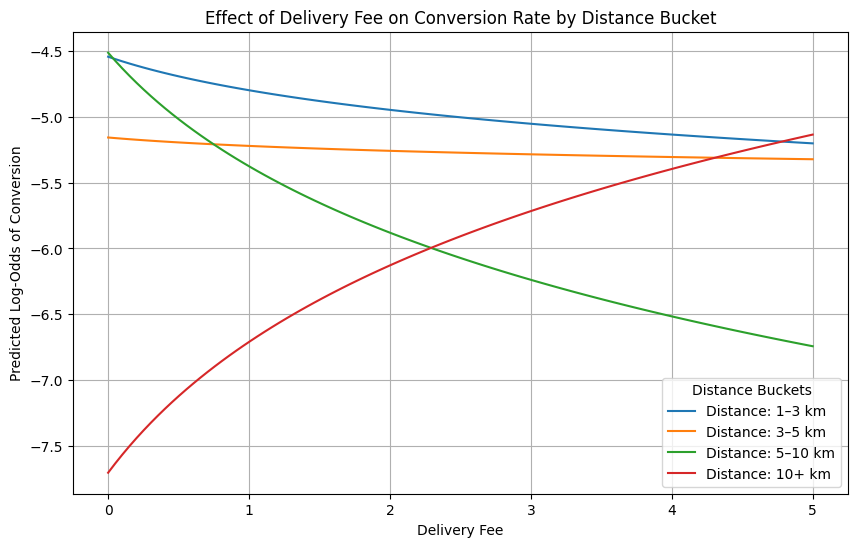

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Coefficients from the model summary
intercept = -3.5811
log_fee_coef = 0.7497
distance_coeffs = {
    '1–3 km': -0.9606,
    '3–5 km': -1.5752,
    '5–10 km': -0.9302,
    '10+ km': -4.1256
}

# Interaction coefficients for delivery fee with distance
interaction_coeffs = {
    '1–3 km': -1.1176,
    '3–5 km': -0.8420,
    '5–10 km': -1.9960,
    '10+ km': 0.6861
}

# Define a range of delivery fee values
delivery_fee_values = np.linspace(0, 5, 100)

# Calculate the predicted log-odds of conversion for each distance bucket
predicted_log_odds = {distance: [] for distance in distance_coeffs}

for fee in delivery_fee_values:
    # For each distance bucket, compute the predicted log-odds
    for distance in distance_coeffs:
        log_fee_term = log_fee_coef * np.log(1 + fee)  # log fee term
        interaction_term = interaction_coeffs[distance] * np.log(1 + fee)  # interaction term
        # Predicted log-odds
        log_odds = intercept + distance_coeffs[distance] + log_fee_term + interaction_term
        predicted_log_odds[distance].append(log_odds)

# Plot the results
plt.figure(figsize=(10, 6))

for distance in predicted_log_odds:
    plt.plot(delivery_fee_values, predicted_log_odds[distance], label=f'Distance: {distance}')

plt.xlabel('Delivery Fee')
plt.ylabel('Predicted Log-Odds of Conversion')
plt.title('Effect of Delivery Fee on Conversion Rate by Distance Bucket')
plt.legend(title='Distance Buckets')
plt.grid(True)
plt.show()


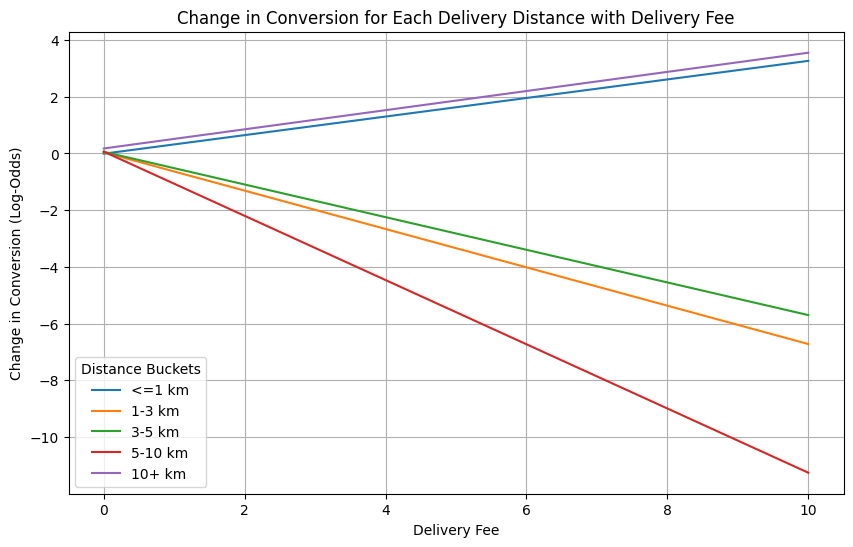

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Define the distance buckets and the corresponding coefficients for delivery fee and average delivery time
distance_buckets = ['<=1 km', '1-3 km', '3-5 km', '5-10 km', '10+ km']
delivery_fee_coeffs = [0.3273, -0.6761, -0.5756, -1.1322, 0.3376]
delivery_time_coeffs = [-0.0015, 0.0082, 0.0114, 0.0130, 0.0353]

# Define the x-axis values (can represent a range of delivery fees or times)
delivery_fees = np.linspace(0, 10, 100)

# Plot the change in conversion for each delivery distance
plt.figure(figsize=(10, 6))

# Loop over the distance buckets and calculate the conversion change for each
for i, distance in enumerate(distance_buckets):
    # Assume average delivery time is held constant, and we're plotting the effect of delivery fee
    conversion_change = delivery_fee_coeffs[i] * delivery_fees + delivery_time_coeffs[i] * 5  # Assuming a fixed average delivery time
    plt.plot(delivery_fees, conversion_change, label=distance)

plt.xlabel('Delivery Fee')
plt.ylabel('Change in Conversion (Log-Odds)')
plt.title('Change in Conversion for Each Delivery Distance with Delivery Fee')
plt.legend(title='Distance Buckets')
plt.grid(True)
plt.show()


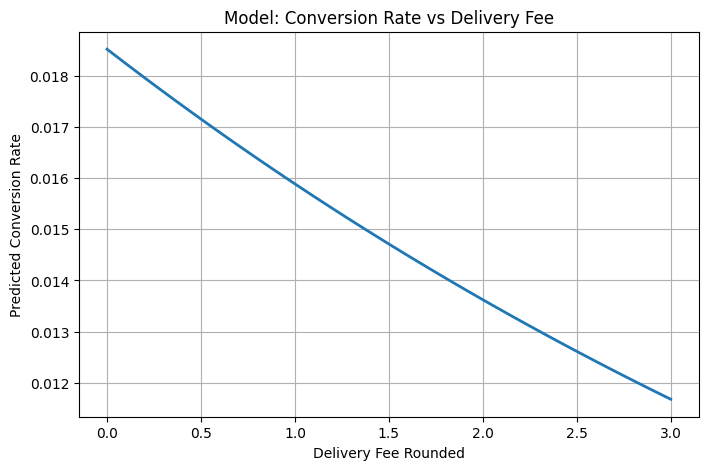

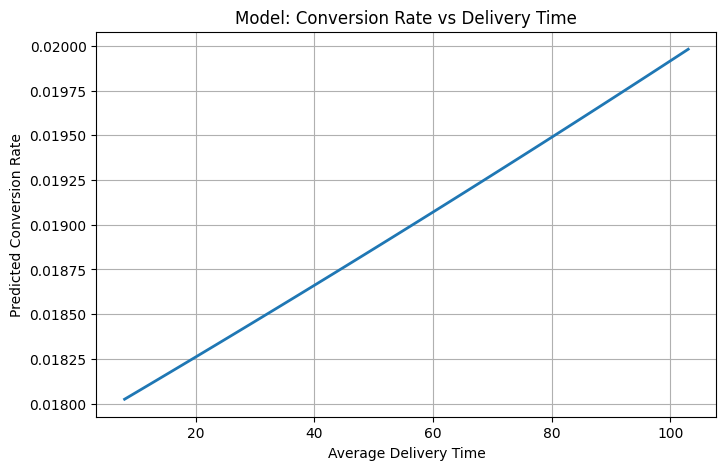

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Create a base row with average values for all variables except the one we're varying
base_row = listings_df.median(numeric_only=True).to_dict()

# Set default values for categorical vars (pick the mode or a common value)
base_row['hour_of_day'] = listings_df['hour_of_day'].mode()[0]
base_row['day_of_week'] = listings_df['day_of_week'].mode()[0]
base_row['distance_bucket'] = listings_df['distance_bucket'].mode()[0]
base_row['locationCity'] = listings_df['locationCity'].mode()[0]

# ---- Plot Conversion Rate vs Delivery Fee ---- #
fee_range = np.linspace(listings_df['delivery_fee_rounded'].min(),
                        listings_df['delivery_fee_rounded'].max(), 100)

df_fee = pd.DataFrame([base_row] * len(fee_range))
df_fee['delivery_fee_rounded'] = fee_range
df_fee['delivery_fee_rounded_sq'] = fee_range ** 2

# Keep delivery time constant at median
df_fee['average_delivery_time'] = base_row['average_delivery_time']
df_fee['average_delivery_time_sq'] = base_row['average_delivery_time'] ** 2

# Predict
df_fee['predicted_conversion'] = model.predict(df_fee)

plt.figure(figsize=(8, 5))
plt.plot(df_fee['delivery_fee_rounded'], df_fee['predicted_conversion'], linewidth=2)
plt.xlabel('Delivery Fee Rounded')
plt.ylabel('Predicted Conversion Rate')
plt.title('Model: Conversion Rate vs Delivery Fee')
plt.grid(True)
plt.show()

# ---- Plot Conversion Rate vs Delivery Time ---- #
time_range = np.linspace(listings_df['average_delivery_time'].min(),
                         listings_df['average_delivery_time'].max(), 100)

df_time = pd.DataFrame([base_row] * len(time_range))
df_time['average_delivery_time'] = time_range
df_time['average_delivery_time_sq'] = time_range ** 2

# Keep delivery fee constant at median
df_time['delivery_fee_rounded'] = base_row['delivery_fee_rounded']
df_time['delivery_fee_rounded_sq'] = base_row['delivery_fee_rounded'] ** 2

# Predict
df_time['predicted_conversion'] = model.predict(df_time)

plt.figure(figsize=(8, 5))
plt.plot(df_time['average_delivery_time'], df_time['predicted_conversion'], linewidth=2)
plt.xlabel('Average Delivery Time')
plt.ylabel('Predicted Conversion Rate')
plt.title('Model: Conversion Rate vs Delivery Time')
plt.grid(True)
plt.show()


In [18]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np

# Numeric and Categorical Features
numeric_features = ['delivery_fee_rounded', 'delivery_fee_rounded_sq', 'average_delivery_time', 'average_delivery_time_sq']
categorical_features = ['hour_of_day', 'day_of_week', 'distance_bucket', 'locationCity']

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

# Transform the data
X_processed = preprocessor.fit_transform(X_raw)
feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

# LassoCV
lasso = LassoCV(cv=5, max_iter=5000, n_jobs=-1)
lasso.fit(X_processed, y, sample_weight=weights)

# Extract selected features
lasso_coefs = lasso.coef_
selected_features = [name for name, coef in zip(feature_names, lasso_coefs) if coef != 0]

print("Selected Features by Lasso:", selected_features)


KeyboardInterrupt: 

In [ ]:
selected_base_features = set()
for feature in selected_features:
    # Check if it's from categorical features
    for cat in categorical_features:
        if feature.startswith(cat):
            selected_base_features.add(f"C({cat})")
            break
    else:
        # Otherwise it's numeric
        selected_base_features.add(feature)

# Final formula
glm_formula = 'conversion_rate ~ ' + ' + '.join(sorted(selected_base_features))
print("GLM Formula:", glm_formula)


In [ ]:
import statsmodels.formula.api as smf

glm_model = smf.glm(
    formula=glm_formula,
    data=df,
    family=sm.families.Binomial(),
    freq_weights=weights
).fit()

print(glm_model.summary())


In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Residual plot
fitted_vals = results.fittedvalues
residuals = results.resid
plt.scatter(fitted_vals, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.show()

# Normality of residuals
sm.qqplot(residuals, line='s')
plt.title('QQ Plot of Residuals')
plt.show()

In [8]:
import bambi as bmb
import pandas as pd

# Assume df is your DataFrame
# Drop incomplete rows (Bambi cannot handle NaNs)
df_clean = df.dropna(subset=[
    'conversion_rate', 'delivery_fee_rounded', 'delivery_fee_rounded_sq',
    'average_delivery_time', 'average_delivery_time_sq',
    'fee_x_time', 'hour_of_day', 'day_of_week', 'distance_bucket', 'locationCity'
])

# Define formula
formula = """
conversion_rate ~ delivery_fee_rounded + delivery_fee_rounded_sq + average_delivery_time 
+ average_delivery_time_sq + fee_x_time + C(hour_of_day) + C(day_of_week) 
+ C(distance_bucket) + (1|locationCity)
"""

# Build model (Gaussian for continuous outcome)
model = bmb.Model(formula, df_clean, family="gaussian")

# Fit model with reduced chains/cores to avoid multiprocessing errors
results = model.fit(draws=500, tune=500, chains=2, cores=1)

# Summary of fixed effects
import arviz as az
summary = az.summary(results, hdi_prob=0.95)
print(summary)

# Optional: Plot posterior estimates
az.plot_forest(results, kind='forestplot', combined=True)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [conversion_rate_sigma, Intercept, delivery_fee_rounded, delivery_fee_rounded_sq, average_delivery_time, average_delivery_time_sq, fee_x_time, C(hour_of_day), C(day_of_week), C(distance_bucket), 1|locationCity_sigma, 1|locationCity_offset]


Output()

In [58]:
# from pymer4.models import Lmer

# # Convert binary outcome
# df = listings_df.copy()
# df['conversion_rate_bin'] = df['conversion_rate'].round().astype(int)

# # Formula with random intercept for city
# formula = 'conversion_rate_bin ~ delivery_fee_rounded + average_delivery_time + fee_x_time + C(hour_of_day) + C(day_of_week) + C(distance_bucket) + (1|locationCity)'

# # Fit mixed logistic regression
# model = Lmer(formula, data=df, family='binomial')
# model.fit()

# print(model.summary())


Exception ignored from cffi callback <function _processevents at 0x150ad39c0>:
Traceback (most recent call last):
  File "/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/rpy2/rinterface_lib/callbacks.py", line 283, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt: 


In [22]:
heatmap_df = listings_df.groupby(
    ['average_delivery_time', 'delivery_fee_rounded']
)['conversion_rate'].agg(['mean', 'count']).reset_index()

# Pivot for heatmap (conversion rate as values)
heatmap_data = heatmap_df.pivot(
    index='average_delivery_time',
    columns='delivery_fee_rounded',
    values='mean'
)

In [23]:
# Sort Y-axis (delivery time bins) descending
heatmap_data = heatmap_data.sort_index(ascending=False)

# Sort X-axis (delivery fee) ascending
heatmap_data = heatmap_data.sort_index(axis=1, ascending=True)

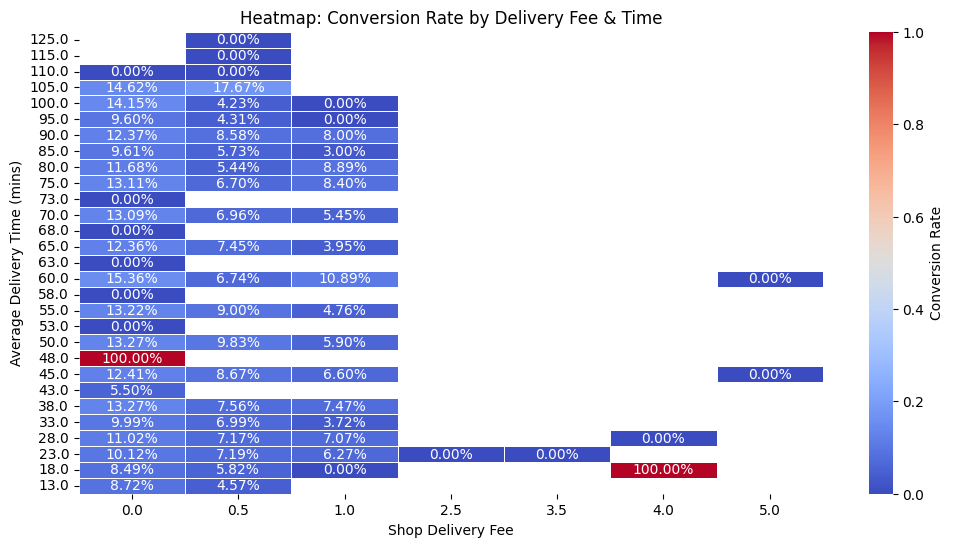

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data, cmap='coolwarm', annot=True, fmt=".2%", linewidths=0.5,
    cbar_kws={'label': 'Conversion Rate'}
)

plt.xlabel("Shop Delivery Fee")
plt.ylabel("Average Delivery Time (mins)")
plt.title("Heatmap: Conversion Rate by Delivery Fee & Time")
plt.show()


In [36]:
listings_df.columns

Index(['dh_platform', 'global_entity_id', 'country', 'locationCity',
       'average_delivery_time', 'delivery_fee_rounded', 'distance_bucket',
       'all_shops', 'converted_shops', 'conversion_rate'],
      dtype='object')

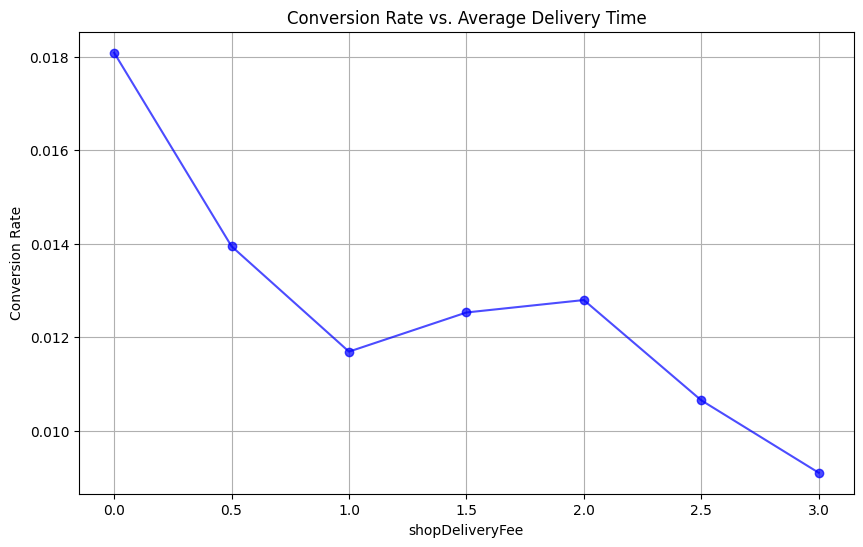

In [37]:
tt = listings_df.groupby('delivery_fee_rounded').agg(
    converted = ('converted_shops', 'sum'),
    total_shops=('all_shops','sum')
).reset_index()

tt['coversion'] = tt['converted'] / tt['total_shops']

# Plot conversion rate against average delivery time
plt.figure(figsize=(10, 6))
plt.plot(tt['delivery_fee_rounded'], tt['coversion'], marker='o', linestyle='-', color='b', alpha=0.7)
plt.xlabel("shopDeliveryFee")
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate vs. Average Delivery Time")
plt.grid(True)
plt.show()

In [130]:
listings_df

dh_platform global_entity_id platform               session_key  \
0            pandora            FP_PK      iOS  Dz0NHkNZy6xVVcl3xnUgAg==   
1            pandora            FP_PK  Android  ENNspz9OhRZJnpKokiOk2g==   
2            pandora            FP_PK  Android  DFgWXanPRDj2PuSRShfC8g==   
3            pandora            FP_PK  Android  DOH6o7NEExX7MLnylpUHHQ==   
4            pandora            FP_PK      iOS  EiWuOMmfqMZXBaxTuzhf/A==   
...              ...              ...      ...                       ...   
30497371     pandora            FP_PK      iOS  1kaBNu3L19BCpLUBl/QhCQ==   
30497372     pandora            FP_PK      iOS  /b7IocLpmcQnrzamwFbUmA==   
30497373     pandora            FP_PK  Android  +1RPo4XmQjM1f8NMcdFEQg==   
30497374     pandora            FP_PK  Android  +lQmsYd6ZZnbzmpkgtY1QA==   
30497375     pandora            FP_PK  Android  +EA7yKbR/8S/SY2pvc9z1w==   

         shopId                   eventTimestamp  locationLat  locationLon  \
0          r2su 2025-02-02 09:12:02.987000+00:00   24.8540328  67.06820975   
1          v3dt 2025-02-02 18:29:07.324000+00:00   24.8217463   67.0317371   
2          k5jj 2025-02-03 08:21:31.307000+00:00   31.5760614   74.3182207   
3          t6yu 2025-02-06 19:20:45.180000+00:00   24.8694212   67.0486229   
4          b78b 2025-02-05 19:46:53.296000+00:00   24.8093084   67.0708056   
...         ...                              ...          ...          ...   
30497371   plg8 2025-02-04 13:41:13.948000+00:00  33.69939578  73.01012736   
30497372   t5y4 2025-02-05 16:36:42.722000+00:00  31.36174821  74.21852438   
30497373   c1eq 2025-02-06 19:38:23.955000+00:00   29.3912577   71.7121348   
30497374   w9aq 2025-02-05 17:52:52.440000+00:00    31.415749    73.104621   
30497375   zsho 2025-02-04 13:32:26.169000+00:00   31.4046615   73.0558626   

         promisedDeliveryTimeRangeUpper promisedDeliveryTimeRangeLower  ...  \
0                                    35                             20  ...   
1                                    40                             25  ...   
2                                    35                             20  ...   
3                                    25                             10  ...   
4                                    30                             15  ...   
...                                 ...                            ...  ...   
30497371                             20                              5  ...   
30497372                             30                             15  ...   
30497373                             30                             15  ...   
30497374                             25                             10  ...   
30497375                             70                             40  ...   

          longitude category_parent_id category_id global_category_id  \
0         67.063715                139         258                      
1         67.050403                 95         244                      
2         74.305549                100         241                      
3         67.029921                  0         250                      
4         67.044607                 75          76                008   
...             ...                ...         ...                ...   
30497371  73.012902                  0          89                021   
30497372  74.240053                  0          89                021   
30497373  71.665417                  0          89                021   
30497374  73.100572                  0          89                021   
30497375  73.046663                  0          89                021   

         category_name is_main_category       session_key_details  \
0           Halwa Puri             True                      None   
1                Steak             True                      None   
2               Broast             True                      None   
3               Haleem             True                  

In [112]:
# ('DJ_CZ','EF_GR','FO_NO','FP_BD','FP_DE','HF_EG','FP_LA','FP_MM','FP_PK','FP_SG','FP_TH')

In [ ]:
global_entity_id	avg_conversion_details	avg_conversion_checkout	avg_conversion_order
0	DJ_CZ	-0.164986	-0.067360	-0.040942
1	EF_GR	-0.357137	0.000000	NaN
2	FO_NO	-0.089611	-0.109567	-0.032204
3	FP_BD	-0.412253	-0.315583	-0.006774
4	FP_DE	-0.200806	-0.569124	0.000000
5	FP_HK	-0.098844	-0.043877	-0.044798
6	FP_KH	-0.244750	-0.296380	-0.016292
7	FP_LA	-0.242189	-0.207426	0.047090
8	FP_MM	-0.253920	0.050165	0.207312
9	FP_MY	-0.156446	-0.185381	-0.049438
10	FP_PH	-0.195444	-0.238479	-0.061167
11	FP_PK	-0.271608	-0.266019	0.184860
12	FP_SG	-0.197738	-0.186600	-0.014599
13	FP_TH	-0.275609	-0.134112	-0.053354
14	FP_TW	-0.039246	-0.027504	-0.008968
15	HF_EG	-0.162212	-0.058679	-0.007705
16	HS_SA	-0.058979	-0.037084	-0.172868
17	MJM_AT	-0.056468	0.088513	-0.032019
18	NP_HU	-0.202244	-0.146687	-0.043774
19	OP_SE	-0.057333	-0.027713	-0.037800
20	PO_FI	-0.130184	-0.040838	-0.048225
21	TB_AE	-0.164952	-0.091075	-0.016381
22	TB_BH	-0.172292	-0.227331	0.036114
23	TB_IQ	-0.056311	-0.263095	-0.037684
24	TB_JO	-0.141907	-0.167105	-0.016242
25	TB_KW	-0.122124	-0.101291	-0.012172
26	TB_OM	-0.133112	-0.172848	0.010131
27	TB_QA	-0.247302	-0.028401	-0.028562
28	YS_TR	-0.141401	-0.282735	-0.001001

In [5]:
### Convert to relevant Dtypes ###

# Convert integer columns to int (avoids type mismatches)
int_columns = ["promisedDeliveryTimeRangeUpper", "promisedDeliveryTimeRangeLower", "shopDeliveryFee", 
               "serviceFee", "shopMinimumOrderValue", "shopRank", "shopPosition", "shopId_details", "rn_details","rn"
               ,"category_parent_id","category_id","global_category_id"]

for col in int_columns:
    if col in listings_df.columns:
        listings_df[col] = pd.to_numeric(listings_df[col], errors='coerce').fillna(0).astype(float)

# Convert all string columns to str (ensures no mixed types)
string_columns = ["dh_platform", "global_entity_id", "platform", "session_key","shopId","locationLat","locationLon",
                "locationCountry", "locationCity", "verticalType", "shopListType", "shopSponsoring", "shopType", 
                  "shopName", "shopCuisine", "perseusClientId", "shopCategorySelected", "pageType", 
                  "userId", "eventAction", "hour_of_the_day", "shopRatingQuality", "session_key_details","vendor_id","vendor_name"
                  "vertical_parent","vertical_type","chain_id","chain_name","category_name","is_main_category","session_key_details","shopId_details"]

for col in string_columns:
    if col in listings_df.columns:
        listings_df[col] = listings_df[col].astype(str)  # Force string type

In [132]:
### Add relevant Columns ###

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c  # Distance in km

# Ensure latitude and longitude values are numeric
listings_df[['locationLat', 'locationLon', 'latitude', 'longitude']] = listings_df[
    ['locationLat', 'locationLon', 'latitude', 'longitude']
].apply(pd.to_numeric, errors='coerce')

# Apply function to calculate distance
listings_df['distance_km'] = listings_df.apply(
    lambda row: haversine(row['locationLat'], row['locationLon'], row['latitude'], row['longitude']), axis=1
)

<Axes: >

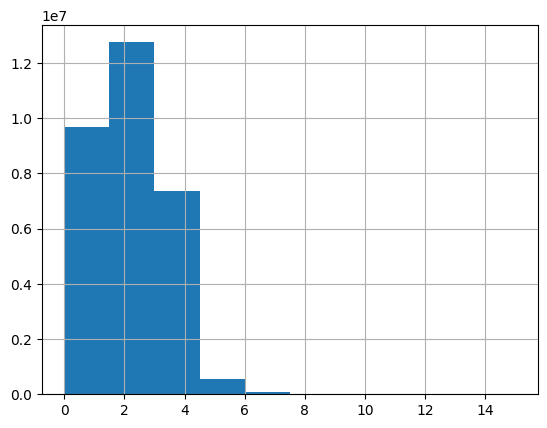

In [133]:
listings_df[listings_df['distance_km'] < 15]['distance_km'].hist()

In [134]:
import pandas as pd
import numpy as np

# Assuming listings_df already exists and has a column 'distance_km'
# Define distance buckets
bins = [0, 1, 4, np.inf]  # Short: 0-2 km, Medium: 2-5 km, Long: 5+ km
labels = ["Short", "Medium", "Long"]
listings_df["distance_bucket"] = pd.cut(listings_df["distance_km"], bins=bins, labels=labels, right=False)

# # Group by distance bucket and delivery fee
# fee_distance_group = listings_df.groupby(["shopId","distance_bucket"]).agg(
#     count=("log_delivery_fee", "count"),
#     avg_fee=("log_delivery_fee", "mean"),
#     std_fee=("log_delivery_fee", "std"),
#     min_fee=("log_delivery_fee", "min"),
#     max_fee=("log_delivery_fee", "max")
# ).reset_index()


In [135]:
# fee_distance_group['avg_fee'].hist()

In [136]:
epsilon = 1e-6  # Small value to prevent log(0)
listings_df['log_delivery_fee'] = np.log(listings_df['shopDeliveryFee'] + epsilon)

# Group by restaurant and check variation in delivery fees
fee_variation = listings_df.groupby("shopId")["log_delivery_fee"].agg(["count", "mean", "std", "min", "max"]).reset_index()

# Compute the range of fees per restaurant
fee_variation["fee_range"] = fee_variation["max"] - fee_variation["min"]


In [137]:
fee_variation.describe()

count          mean           std           min           max  \
count  10800.000000  10800.000000  10551.000000  10800.000000  10800.000000   
mean    2823.831111      0.791989      6.986461    -13.525216      4.663464   
std     3578.381861      2.457183      1.251690      2.260119      2.170664   
min        1.000000    -13.815511      0.000000    -13.815511    -13.815511   
25%      732.000000      0.291892      6.198174    -13.815511      4.234107   
50%     1660.000000      1.340168      6.841212    -13.815511      5.293305   
75%     3532.000000      2.106507      7.755024    -13.815511      5.293305   
max    39555.000000      5.293305     13.511973      5.293305      5.455321   

          fee_range  
count  10800.000000  
mean      18.188680  
std        3.181477  
min        0.000000  
25%       18.049617  
50%       19.108815  
75%       19.108815  
max       19.270832

In [138]:
# Define threshold for "enough variation" in log delivery fees
variation_threshold = 5

# Count shops that have fee_range > threshold
num_shops_high_variation = (fee_variation["fee_range"] > variation_threshold).sum()
total_shops = fee_variation.shape[0]

# Calculate percentage
percentage_high_variation = (num_shops_high_variation / total_shops) * 100

# Display the result
percentage_high_variation


np.float64(97.10185185185185)

In [139]:
# Ensure None values are treated as NaN
listings_df['session_key_details'] = listings_df['session_key_details'].replace({'None': pd.NA})

# Create the 'click' column: 1 if not NaN, 0 otherwise
listings_df['converted'] = listings_df['session_key_details'].notna().astype(int)

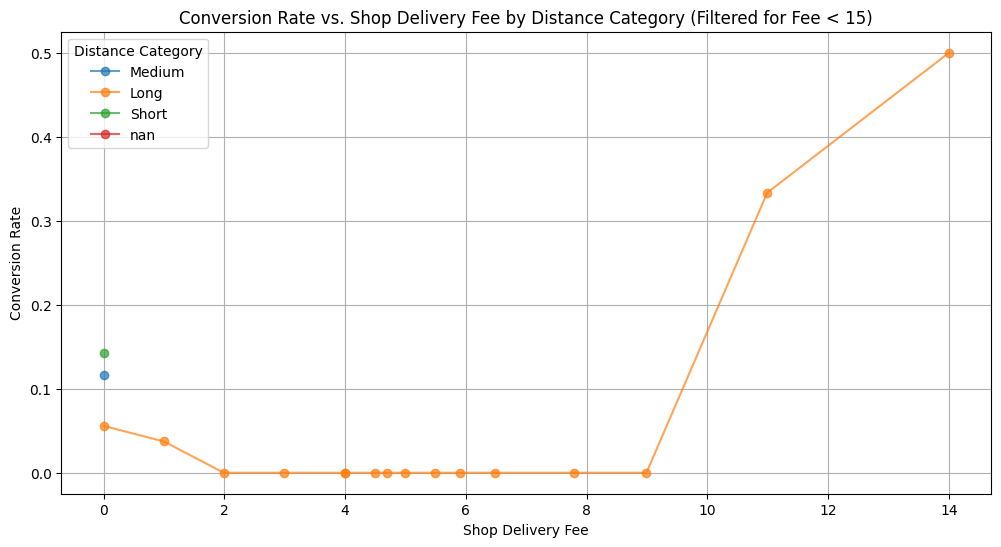

In [140]:
plt.figure(figsize=(12, 6))

# Iterate through each distance category and plot conversion rate
for dist in listings_df["distance_bucket"].unique():
    dist_df = listings_df[(listings_df["distance_bucket"] == dist) & (listings_df["shopDeliveryFee"] < 15)]
    
    # Aggregate conversion data
    dist_tt = dist_df.groupby("shopDeliveryFee").agg(
        converted=("converted", "sum"),
        total_shops=("shopId", "count")
    ).reset_index()

    # Calculate conversion rate and apply smoothing
    dist_tt["conversion_rate"] = dist_tt["converted"] / dist_tt["total_shops"]
    dist_tt["smoothed_conversion"] = dist_tt["conversion_rate"].rolling(window=3, center=True, min_periods=1).mean()

    # Plot the smoothed conversion rate
    plt.plot(dist_tt["shopDeliveryFee"], dist_tt["smoothed_conversion"], marker="o", linestyle="-", label=dist, alpha=0.7)

# Customize the plot
plt.xlabel("Shop Delivery Fee")
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate vs. Shop Delivery Fee by Distance Category (Filtered for Fee < 15)")
plt.legend(title="Distance Category")
plt.grid(True)

# Show the plot
plt.show()


/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


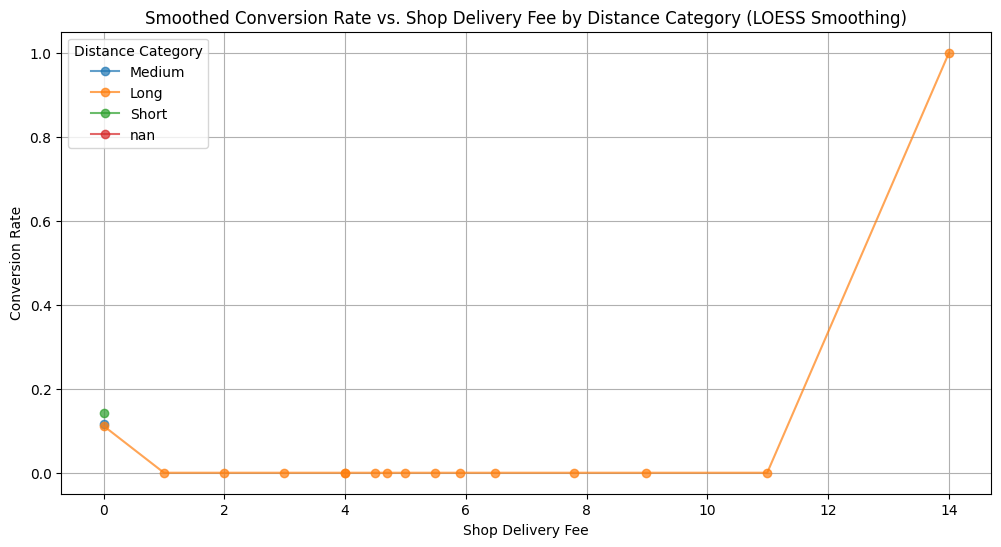

In [141]:
import statsmodels.api as sm
import numpy as np

# Define the figure for plotting
plt.figure(figsize=(12, 6))

# Iterate through each distance category and apply LOESS smoothing
for dist in listings_df["distance_bucket"].unique():
    dist_df = listings_df[(listings_df["distance_bucket"] == dist) & (listings_df["shopDeliveryFee"] < 15)]

    # Aggregate conversion data
    dist_tt = dist_df.groupby("shopDeliveryFee").agg(
        converted=("converted", "sum"),
        total_shops=("shopId", "count")
    ).reset_index()

    # Calculate conversion rate
    dist_tt["conversion_rate"] = dist_tt["converted"] / dist_tt["total_shops"]

    # Apply LOESS smoothing
    lowess = sm.nonparametric.lowess(dist_tt["conversion_rate"], dist_tt["shopDeliveryFee"], frac=0.3)
    
    # Plot the smoothed conversion rate
    plt.plot(lowess[:, 0], lowess[:, 1], marker="o", linestyle="-", label=dist, alpha=0.7)

# Customize the plot
plt.xlabel("Shop Delivery Fee")
plt.ylabel("Conversion Rate")
plt.title("Smoothed Conversion Rate vs. Shop Delivery Fee by Distance Category (LOESS Smoothing)")
plt.legend(title="Distance Category")
plt.grid(True)

# Show the plot
plt.show()


In [8]:
# Compute the average delivery time.
# (Here I'm taking the midpoint; if you want the sum, remove the division by 2.)
listings_df['average_delivery_time'] = round((
    listings_df['promisedDeliveryTimeRangeUpper'] + listings_df['promisedDeliveryTimeRangeLower']
) / 2,)

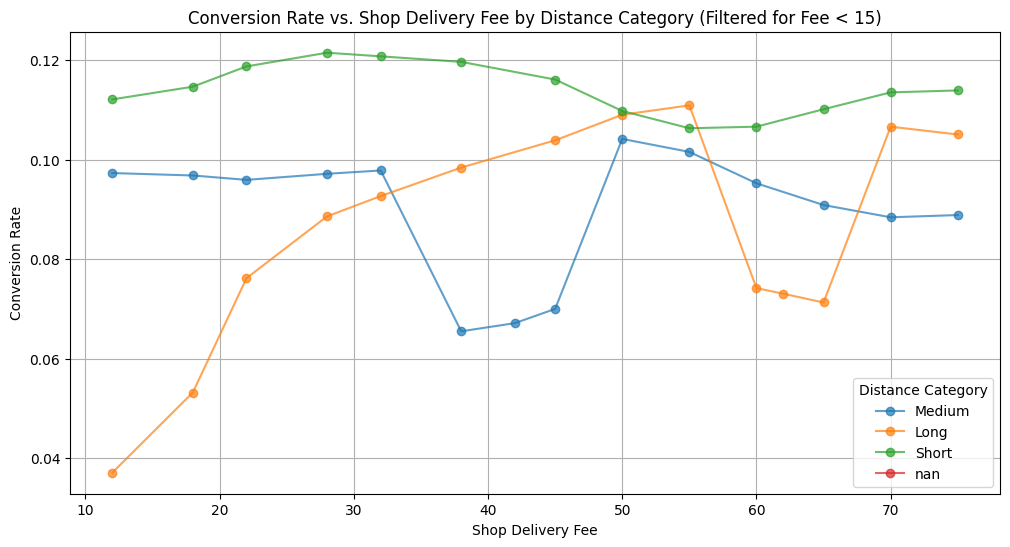

In [143]:
plt.figure(figsize=(12, 6))


# Iterate through each distance category and plot conversion rate
for dist in listings_df["distance_bucket"].unique():
    dist_df = listings_df[(listings_df["distance_bucket"] == dist) & (listings_df["average_delivery_time"] < 80)]
    
    # Aggregate conversion data
    dist_tt = dist_df.groupby("average_delivery_time").agg(
        converted=("converted", "sum"),
        total_shops=("shopId", "count")
    ).reset_index()

    # Calculate conversion rate and apply smoothing
    dist_tt["conversion_rate"] = dist_tt["converted"] / dist_tt["total_shops"]
    dist_tt["smoothed_conversion"] = dist_tt["conversion_rate"].rolling(window=3, center=True, min_periods=1).mean()

    # Plot the smoothed conversion rate
    plt.plot(dist_tt["average_delivery_time"], dist_tt["smoothed_conversion"], marker="o", linestyle="-", label=dist, alpha=0.7)

# Customize the plot
plt.xlabel("Shop Delivery Fee")
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate vs. Shop Delivery Fee by Distance Category (Filtered for Fee < 15)")
plt.legend(title="Distance Category")
plt.grid(True)

# Show the plot
plt.show()


In [144]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import statsmodels.formula.api as smf
# import statsmodels.api as sm

# # 1️⃣ Segment Shops with Wide Fee Variation + Lots of Orders
# fee_stats = listings_df.groupby("shopId").agg(
#     order_count=("converted", "sum"),
#     conversion_sum=("converted", "sum"),
#     fee_std=("shopDeliveryFee", "std"),
#     fee_range=("shopDeliveryFee", lambda x: x.max() - x.min())
# ).reset_index()

# # Filter shops with enough orders and high fee variation
# segmented_shops = fee_stats[(fee_stats["order_count"] >= 100) & (fee_stats["fee_range"] >= 2)]

# # Filter original data for those shops and Short/Medium distance
# filtered_segment = listings_df[
#     (listings_df["shopId"].isin(segmented_shops["shopId"])) &
#     (listings_df["distance_category"].isin(["Short", "Medium"])) &
#     (listings_df["average_delivery_time"] > 0) &
#     (listings_df["average_delivery_time"] < 70) &
#     (listings_df["shopDeliveryFee"] < 15)
# ].copy()

# # 2️⃣ Model Elasticity: Pooled GLM Logistic Regression (more stable)
# # Log-transform fee and time
# filtered_segment["log_fee"] = np.log1p(filtered_segment["shopDeliveryFee"])
# filtered_segment["log_time"] = np.log1p(filtered_segment["average_delivery_time"])

# # Drop NaNs/Infs after transformation
# filtered_segment.replace([np.inf, -np.inf], np.nan, inplace=True)
# filtered_segment.dropna(subset=["log_fee", "log_time", "converted", "distance_category"], inplace=True)

# # Filter Short + Medium again after cleaning
# filtered_segment_sm = filtered_segment[
#     filtered_segment["distance_category"].isin(["Short", "Medium"])
# ].copy()

# # Fit GLM logistic regression
# elasticity_model_sm = smf.glm(
#     "converted ~ log_fee + log_time + C(distance_category, Treatment(reference='Short'))",
#     data=filtered_segment_sm,
#     family=sm.families.Binomial()
# ).fit()

# model_summary_sm = elasticity_model_sm.summary2().as_text()

# # 3️⃣ Simulate Profit for Short + Medium
# base_cost = 2.0
# cost_per_km = 0.5
# filtered_segment_sm["estimated_cost"] = base_cost + cost_per_km * filtered_segment_sm["distance_km"]
# filtered_segment_sm["profit"] = filtered_segment_sm["shopDeliveryFee"] - filtered_segment_sm["estimated_cost"]
# filtered_segment_sm["fee_bin"] = pd.cut(filtered_segment_sm["shopDeliveryFee"], bins=10)

# profit_analysis_sm = filtered_segment_sm.groupby("fee_bin").agg(
#     avg_conversion=("converted", "mean"),
#     avg_profit=("profit", "mean"),
#     order_count=("converted", "count")
# ).reset_index()


# # Plot conversion vs. profit trade-off for Short/Medium
# plt.figure(figsize=(10, 6))
# plt.plot(profit_analysis_sm["avg_conversion"], profit_analysis_sm["avg_profit"], marker='o')
# plt.xlabel("Average Conversion Rate")
# plt.ylabel("Average Profit per Order ($)")
# plt.title("Profit vs. Conversion Trade-off (Short & Medium Distance)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Display model summary
# model_summary_sm


In [145]:
# from pygam import LogisticGAM, s, f

# # Fit GAM with smooth fee/time, categorical distance
# gam = LogisticGAM(s(0) + s(1) + f(2)).fit(
#     filtered_segment[["shopDeliveryFee", "delivery_time", "distance_category"]],
#     filtered_segment["converted"]
# )

# # Partial Dependence Plots (elasticity curves)
# gam.partial_dependence(term=0)  # ShopDeliveryFee
# gam.partial_dependence(term=1)  # delivery_time


In [148]:
listings_df

dh_platform global_entity_id platform               session_key  \
0            pandora            FP_PK      iOS  Dz0NHkNZy6xVVcl3xnUgAg==   
1            pandora            FP_PK  Android  ENNspz9OhRZJnpKokiOk2g==   
2            pandora            FP_PK  Android  DFgWXanPRDj2PuSRShfC8g==   
3            pandora            FP_PK  Android  DOH6o7NEExX7MLnylpUHHQ==   
4            pandora            FP_PK      iOS  EiWuOMmfqMZXBaxTuzhf/A==   
...              ...              ...      ...                       ...   
30497371     pandora            FP_PK      iOS  1kaBNu3L19BCpLUBl/QhCQ==   
30497372     pandora            FP_PK      iOS  /b7IocLpmcQnrzamwFbUmA==   
30497373     pandora            FP_PK  Android  +1RPo4XmQjM1f8NMcdFEQg==   
30497374     pandora            FP_PK  Android  +lQmsYd6ZZnbzmpkgtY1QA==   
30497375     pandora            FP_PK  Android  +EA7yKbR/8S/SY2pvc9z1w==   

         shopId                   eventTimestamp  locationLat  locationLon  \
0          r2su 2025-02-02 09:12:02.987000+00:00    24.854033    67.068210   
1          v3dt 2025-02-02 18:29:07.324000+00:00    24.821746    67.031737   
2          k5jj 2025-02-03 08:21:31.307000+00:00    31.576061    74.318221   
3          t6yu 2025-02-06 19:20:45.180000+00:00    24.869421    67.048623   
4          b78b 2025-02-05 19:46:53.296000+00:00    24.809308    67.070806   
...         ...                              ...          ...          ...   
30497371   plg8 2025-02-04 13:41:13.948000+00:00    33.699396    73.010127   
30497372   t5y4 2025-02-05 16:36:42.722000+00:00    31.361748    74.218524   
30497373   c1eq 2025-02-06 19:38:23.955000+00:00    29.391258    71.712135   
30497374   w9aq 2025-02-05 17:52:52.440000+00:00    31.415749    73.104621   
30497375   zsho 2025-02-04 13:32:26.169000+00:00    31.404661    73.055863   

          promisedDeliveryTimeRangeUpper  promisedDeliveryTimeRangeLower  ...  \
0                                   35.0                            20.0  ...   
1                                   40.0                            25.0  ...   
2                                   35.0                            20.0  ...   
3                                   25.0                            10.0  ...   
4                                   30.0                            15.0  ...   
...                                  ...                             ...  ...   
30497371                            20.0                             5.0  ...   
30497372                            30.0                            15.0  ...   
30497373                            30.0                            15.0  ...   
30497374                            25.0                            10.0  ...   
30497375                            70.0                            40.0  ...   

         log_delivery_fee converted  average_delivery_time   log_fee  \
0              -13.815511         0                   28.0  0.000000   
1                4.934474         0                   32.0  4.941642   
2                4.595120         0                   28.0  4.605170   
3                4.934474         0                   18.0  4.941642   
4                4.934474         1                   22.0  4.941642   
...                   ...       ...                    ...       ...   
30497371       -13.815511         0                   12.0  0.000000   
30497372       -13.815511         0                   22.0  0.000000   
30497373         3.891820         0                   22.0  3.912023   
30497374         4.234107         0                   18.0  4.248495   
30497375         4.234107         0                   55.0  4.248495   

          log_time log_fee_sq  log_time_sq log_fee_x_time hour_of_day  \
0         3.367296   0.000000    11.338681       0.000000           9   
1         3.496508  24.419830    12.225565      17.278490          18   
2         3.367296  21.207592    11.338681      15.506970           8   
3         2.944439  24.419830

In [9]:
import statsmodels.formula.api as smf

# Log-transform fee and time
listings_df["log_fee"] = np.log1p(listings_df["shopDeliveryFee"])
listings_df["log_time"] = np.log1p(listings_df["average_delivery_time"])

# Add squared terms & interaction to your DataFrame
listings_df["log_fee_sq"] = listings_df["log_fee"] ** 2
listings_df["log_time_sq"] = listings_df["log_time"] ** 2
listings_df["log_fee_x_time"] = listings_df["log_fee"] * listings_df["log_time"]

# Ensure None values are treated as NaN
listings_df['session_key_details'] = listings_df['session_key_details'].replace({'None': pd.NA})

# Create the 'click' column: 1 if not NaN, 0 otherwise
listings_df['converted'] = listings_df['session_key_details'].notna().astype(int)

# Drop any NaNs or infs
listings_df.replace([np.inf, -np.inf], np.nan, inplace=True)
listings_df.dropna(subset=["log_fee", "log_time"], inplace=True)

# Ensure timestamp is datetime
listings_df['eventTimestamp'] = pd.to_datetime(listings_df['eventTimestamp'])

# Extract hour of day and day of week
listings_df['hour_of_day'] = listings_df['eventTimestamp'].dt.hour.astype(str)  # Convert to string for categorical
listings_df['day_of_week'] = listings_df['eventTimestamp'].dt.dayofweek.astype(str)  # 0 = Monday, 6 = Sunday


# # Fit model
# model = smf.glm(
#     "converted ~ log_fee + log_time + C(shopId) + C(locationCity) + C(category_name) + C(distance_bucket)",
#     data=listings_df,
#     family=sm.families.Binomial()
# ).fit(cov_type='cluster', cov_kwds={'groups': your_df['session_key']})

# Fit model
# model = smf.glm(
#     "converted ~ log_fee * C(distance_bucket) + log_time + C(distance_bucket)",
#     data=listings_df,
#     family=sm.families.Binomial()
# ).fit(cov_type='cluster', cov_kwds={'groups': listings_df['session_key']})

# model = smf.glm(
#     "converted ~ log_fee + log_fee_sq + log_time + log_time_sq + log_fee_x_time + C(distance_bucket)",
#     data=listings_df,
#     family=sm.families.Binomial()
# ).fit(cov_type='cluster', cov_kwds={'groups': listings_df['session_key']})


# print(model.summary())


# model = smf.glm(
#     "converted ~ log_fee + log_fee_sq + log_time + log_time_sq + log_fee_x_time + C(distance_bucket) +  C(category_name)",
#     data=listings_df,
#     family=sm.families.Binomial()
# ).fit(cov_type='cluster', cov_kwds={'groups': listings_df['session_key']})


# print(model.summary())


# model = smf.glm(
#     "converted ~ log_fee * C(distance_bucket) + log_fee_sq * C(distance_bucket) + log_time * C(distance_bucket) + log_time_sq * C(distance_bucket) + log_fee_x_time + C(category_name)",
#     data=listings_df,
#     family=sm.families.Binomial()
# ).fit(cov_type='cluster', cov_kwds={'groups': listings_df['session_key']})


# print(model.summary())

# # Fit model with hour_of_day and day_of_week as fixed effects
# model = smf.glm(
#     "converted ~ log_fee + log_fee_sq + log_time + log_time_sq + log_fee_x_time + "
#     "C(distance_bucket) + C(category_name) + C(hour_of_day) + C(day_of_week)",
#     data=listings_df,
#     family=sm.families.Binomial()
# ).fit(cov_type='cluster', cov_kwds={'groups': listings_df['session_key']})

# # Show summary
# print(model.summary())

# model_data = listings_df.dropna(subset=[
#     'converted', 'log_fee', 'log_fee_sq', 'log_time', 'log_time_sq', 
#     'log_fee_x_time', 'distance_bucket', 'session_key'
# ])

# model = smf.glm(
#     "converted ~ log_fee + log_fee_sq + log_time + log_time_sq + log_fee_x_time + "
#     "C(distance_bucket)",
#     data=model_data,
#     family=sm.families.Binomial()
# ).fit(cov_type='cluster', cov_kwds={'groups': model_data['session_key']})

# print(model.summary())

In [ ]:
countries = listings_df['country'].unique()
results_list = []

for country in countries:
    df_sub = listings_df[listings_df['country'] == country].copy()
    
    # Fit model with hour_of_day and day_of_week as fixed effects
    model = smf.glm(
        "converted ~ log_fee + log_fee_sq + log_time + log_time_sq + log_fee_x_time + "
        "C(distance_bucket) + C(category_name) + C(hour_of_day) + C(day_of_week)",
        data=listings_df,
        family=sm.families.Binomial()
    ).fit(cov_type='cluster', cov_kwds={'groups': listings_df['session_key']})
    
    # Extract coefficients of interest
    fee_coef = model.params['log_fee']
    time_coef = model.params['log_time']
    
    results_list.append({
        'country': country,
        'log_fee_coef': fee_coef,
        'log_time_coef': time_coef,
        'log_fee_sq': model.params['log_fee_sq'],
        'log_time_sq': model.params['log_time_sq']
    })

# Combine into DataFrame
elasticity_df = pd.DataFrame(results_list)



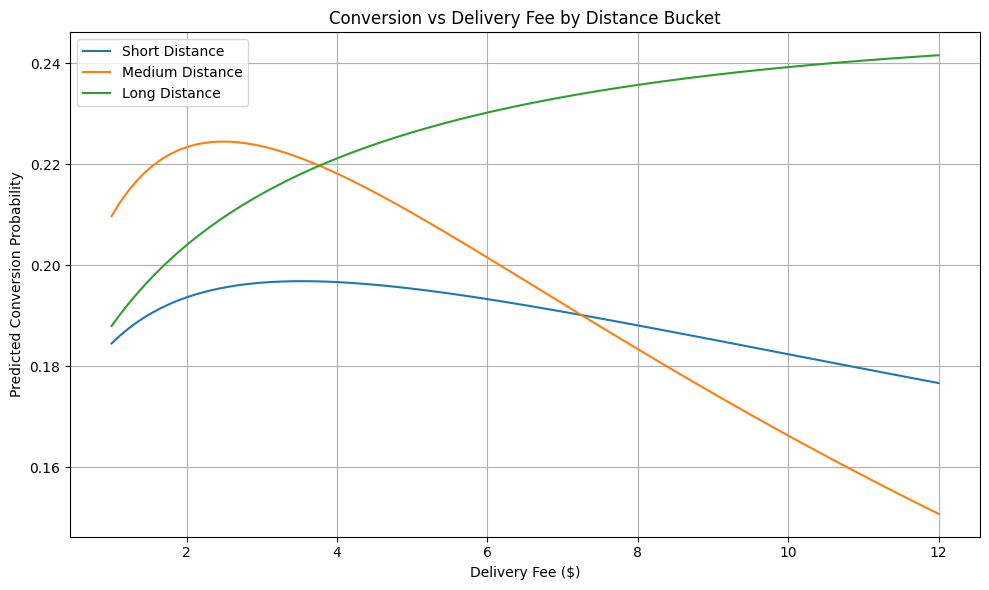

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Latest coefficients from your model
coef = {
    'Intercept': -1.6792,
    'log_fee': 0.3617,
    'log_fee_sq': -0.1197,
    'log_fee:Medium': 0.3427,
    'log_fee_sq:Medium': -0.1624,
    'log_fee:Long': -0.0119,
    'log_fee_sq:Long': 0.0647
}

# Fee range for simulation
fee_range = np.linspace(1, 12, 100)

# Store results
results = []

# Loop over distance buckets
for dist in ['Short', 'Medium', 'Long']:
    for fee in fee_range:
        log_fee = np.log1p(fee)
        log_fee_sq = log_fee ** 2
        
        # Base linear predictor
        lp = coef['Intercept'] + coef['log_fee'] * log_fee + coef['log_fee_sq'] * log_fee_sq
        
        # Add distance-specific interaction terms
        if dist == 'Medium':
            lp += coef['log_fee:Medium'] * log_fee + coef['log_fee_sq:Medium'] * log_fee_sq
        elif dist == 'Long':
            lp += coef['log_fee:Long'] * log_fee + coef['log_fee_sq:Long'] * log_fee_sq

        conversion_prob = 1 / (1 + np.exp(-lp))

        results.append({
            'distance_bucket': dist,
            'fee': fee,
            'conversion_prob': conversion_prob
        })

# Convert to DataFrame
df_plot = pd.DataFrame(results)

# Plot
plt.figure(figsize=(10, 6))
for dist in ['Short', 'Medium', 'Long']:
    subset = df_plot[df_plot['distance_bucket'] == dist]
    plt.plot(subset['fee'], subset['conversion_prob'], label=f'{dist} Distance')

plt.title("Conversion vs Delivery Fee by Distance Bucket")
plt.xlabel("Delivery Fee ($)")
plt.ylabel("Predicted Conversion Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


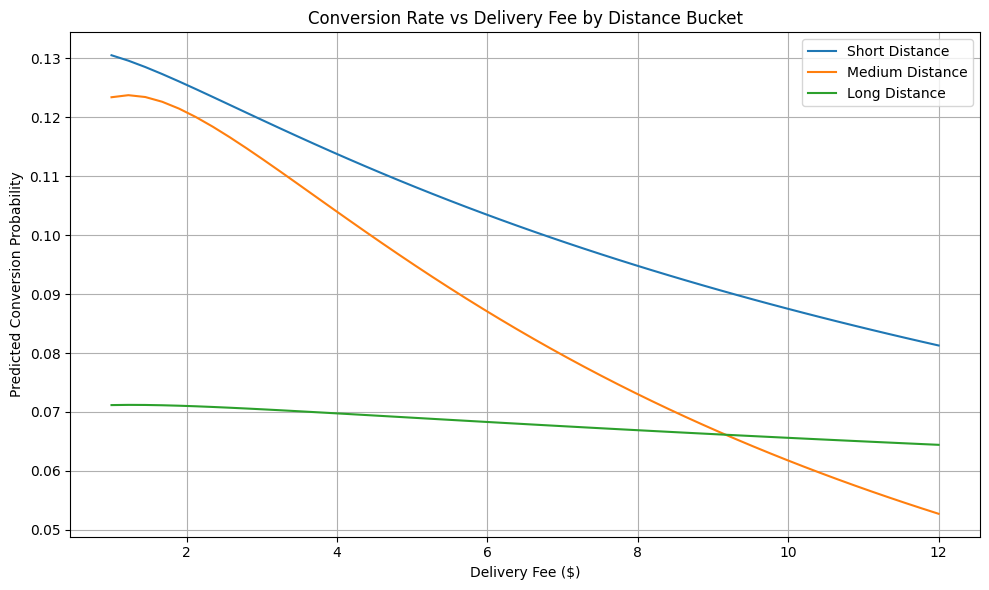

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Model coefficients (from your output)
coef = {
    'Intercept': -1.6792,
    'C(distance_bucket)[T.Medium]': -0.2385,
    'C(distance_bucket)[T.Long]': -0.6833,
    'log_fee': 0.3934,
    'log_fee:C(distance_bucket)[T.Medium]': 0.3769,
    'log_fee:C(distance_bucket)[T.Long]': -0.0408,
    'log_fee_sq': -0.1168,
    'log_fee_sq:C(distance_bucket)[T.Medium]': -0.1811,
    'log_fee_sq:C(distance_bucket)[T.Long]': 0.0817,
    'log_time': -0.0761,
    'log_time_sq': 0.0019,
    'log_fee_x_time': -0.0900
}

# Assume average delivery time for simulation
avg_time = listings_df['average_delivery_time'].mean()
log_time = np.log1p(avg_time)
log_time_sq = log_time ** 2

# Simulate fee range
fee_range = np.linspace(1, 12, 50)

# Store results
results = []

for dist in ['Short', 'Medium', 'Long']:
    for fee in fee_range:
        log_fee = np.log1p(fee)
        log_fee_sq = log_fee ** 2
        log_fee_x_time = log_fee * log_time

        # Base LP
        lp = coef['Intercept'] + coef['log_fee'] * log_fee + coef['log_fee_sq'] * log_fee_sq
        lp += coef['log_time'] * log_time + coef['log_time_sq'] * log_time_sq
        lp += coef['log_fee_x_time'] * log_fee_x_time

        # Add distance-specific adjustments
        if dist == 'Medium':
            lp += coef['C(distance_bucket)[T.Medium]']
            lp += coef['log_fee:C(distance_bucket)[T.Medium]'] * log_fee
            lp += coef['log_fee_sq:C(distance_bucket)[T.Medium]'] * log_fee_sq
        elif dist == 'Long':
            lp += coef['C(distance_bucket)[T.Long]']
            lp += coef['log_fee:C(distance_bucket)[T.Long]'] * log_fee
            lp += coef['log_fee_sq:C(distance_bucket)[T.Long]'] * log_fee_sq

        # Predict conversion probability
        conv_prob = 1 / (1 + np.exp(-lp))

        results.append({
            'distance_bucket': dist,
            'fee': fee,
            'conversion_prob': conv_prob
        })

# Create DataFrame
df_results = pd.DataFrame(results)

# Plot
plt.figure(figsize=(10, 6))
for dist in ['Short', 'Medium', 'Long']:
    plot_df = df_results[df_results['distance_bucket'] == dist]
    plt.plot(plot_df['fee'], plot_df['conversion_prob'], label=f"{dist} Distance")

plt.title("Conversion Rate vs Delivery Fee by Distance Bucket")
plt.xlabel("Delivery Fee ($)")
plt.ylabel("Predicted Conversion Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [64]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = model.model.exog
vif = pd.DataFrame()
vif["feature"] = model.model.exog_names
vif["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(vif)

                                     feature          VIF
0                                  Intercept  4649.351155
1               C(distance_bucket)[T.Medium]     2.705770
2                 C(distance_bucket)[T.Long]     4.031776
3               C(category_name)[T.Burgerit]     2.913977
4                C(category_name)[T.Burrito]     1.003135
5                  C(category_name)[T.Döner]     1.049899
6               C(category_name)[T.Eurooppa]     1.057095
7                C(category_name)[T.Falafel]     1.041499
8                 C(category_name)[T.Grilli]     1.129681
9                  C(category_name)[T.Intia]     1.118342
10                C(category_name)[T.Italia]     1.067031
11                C(category_name)[T.Japani]     1.041939
12                C(category_name)[T.Juomat]     1.030239
13  C(category_name)[T.Jälkiruoat ja herkut]     1.155461
14                 C(category_name)[T.Kahvi]     1.042989
15                  C(category_name)[T.Kana]     1.174210
16        C(ca

In [65]:
# Simpler model without interactions
model_simple = smf.glm("converted ~ log_fee + log_time + C(distance_bucket) + C(category_name)", 
                       data=listings_df, 
                       family=sm.families.Binomial()).fit()

# Likelihood Ratio Test
lr_stat = 2 * (model.llf - model_simple.llf)
from scipy.stats import chi2
p_val = chi2.sf(lr_stat, df=model.df_model - model_simple.df_model)
print(f"LR stat: {lr_stat}, p-value: {p_val}")

LR stat: 484.6771912178956, p-value: 9.982626441116703e-105


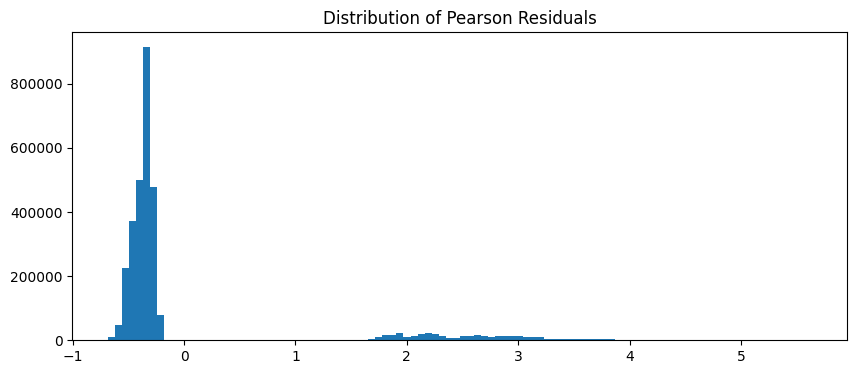

In [66]:
resid = model.resid_pearson
plt.figure(figsize=(10, 4))
plt.hist(resid, bins=100)
plt.title("Distribution of Pearson Residuals")
plt.show()

In [76]:
# # Filter fees where revenue >= current revenue
# profitable_df = df_results[df_results['total_revenue'] >= current_total_revenue]

# if not profitable_df.empty:
#     # Find fee that gives max revenue among those
#     optimal_row = profitable_df.loc[profitable_df['total_revenue'].idxmax()]
#     optimal_fee = optimal_row['fee']
#     optimal_revenue = optimal_row['total_revenue']
#     status = "✅ Revenue Gain"
# else:
#     # No fee beats current → default to current
#     optimal_fee = current_avg_fee
#     optimal_revenue = current_total_revenue
#     status = "⚠️ No Better Fee Found"

# # Plot
# plt.figure(figsize=(10, 6))
# plt.plot(df_results['fee'], df_results['total_revenue'], label='Simulated Total Revenue')
# plt.axvline(x=current_avg_fee, color='red', linestyle='--', label='Current Avg Fee')
# plt.axvline(x=optimal_fee, color='green', linestyle='--', label='Optimal Fee')
# plt.title('Total Revenue vs Delivery Fee (Overall)')
# plt.xlabel('Delivery Fee ($)')
# plt.ylabel('Total Revenue ($)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Print
# print(f"{status}")
# print(f"Current Fee: ${current_avg_fee:.2f} → Revenue: ${current_total_revenue:,.2f}")
# print(f"Optimal Fee: ${optimal_fee:.2f} → Revenue: ${optimal_revenue:,.2f}")
# print(f"Revenue Gap: ${optimal_revenue - current_total_revenue:,.2f}")


In [68]:
# from sklearn.metrics import roc_auc_score, roc_curve
# y_true = listings_df["converted"]
# y_pred = model.predict()

# auc = roc_auc_score(y_true, y_pred)
# print(f"AUC Score: {auc:.3f}")  # AUC > 0.7 is decent

# # Optional: Plot ROC
# fpr, tpr, _ = roc_curve(y_true, y_pred)
# plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
# plt.plot([0,1], [0,1], linestyle="--")
# plt.title("ROC Curve")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.legend()
# plt.show()

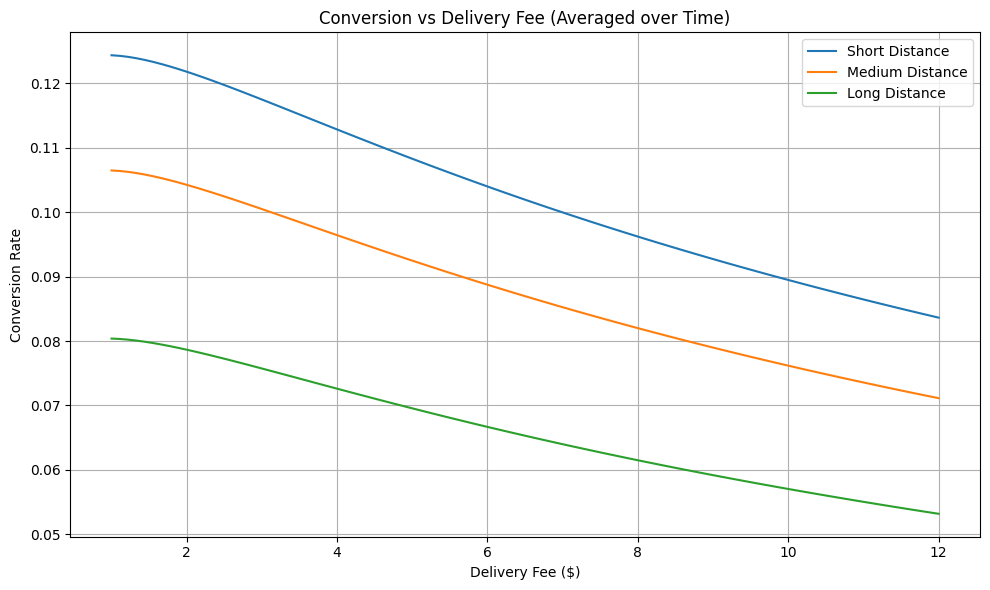

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Define fee range
fee_range = np.linspace(1, 12, 100)

# Extract model coefficients
coef = model.params

# Store plot data
plt.figure(figsize=(10, 6))

# Loop over distance buckets
for dist in ['Short', 'Medium', 'Long']:
    conv_results = []

    for fee in fee_range:
        log_fee = np.log1p(fee)
        log_fee_sq = log_fee ** 2

        # Simulate conversion by **averaging over delivery times**
        conv_probs = []
        for time in np.linspace(10, 60, 10):  # realistic delivery times
            log_time = np.log1p(time)
            log_time_sq = log_time ** 2
            log_fee_x_time = log_fee * log_time

            lp = (
                coef['Intercept']
                + coef.get(f'C(distance_bucket)[T.{dist}]', 0)
                + coef['log_fee'] * log_fee
                + coef['log_fee_sq'] * log_fee_sq
                + coef['log_time'] * log_time
                + coef['log_time_sq'] * log_time_sq
                + coef['log_fee_x_time'] * log_fee_x_time
            )
            conv_probs.append(1 / (1 + np.exp(-lp)))

        avg_conv = np.mean(conv_probs)
        conv_results.append(avg_conv)

    plt.plot(fee_range, conv_results, label=f"{dist} Distance")

plt.xlabel("Delivery Fee ($)")
plt.ylabel("Conversion Rate")
plt.title("Conversion vs Delivery Fee (Averaged over Time)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


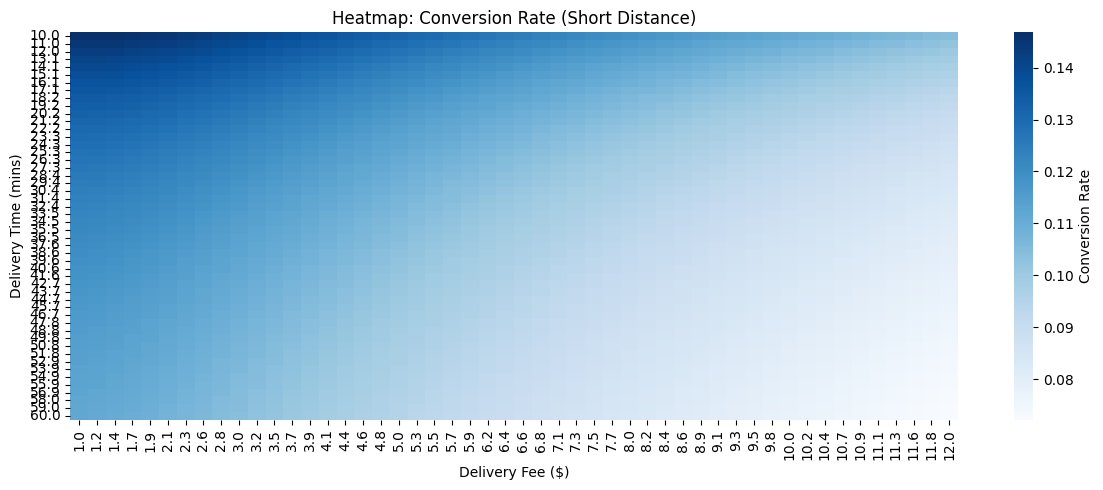

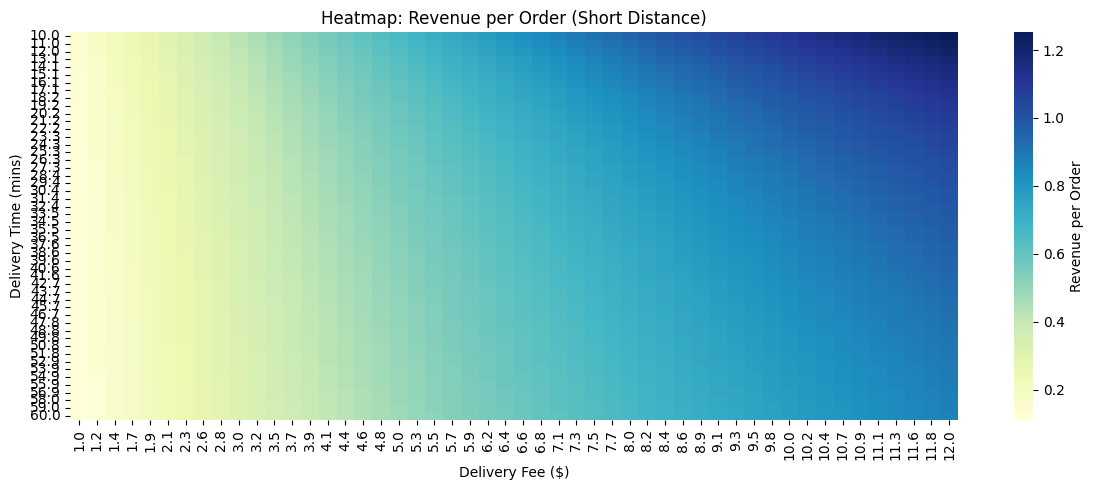

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Simulate grid of fee and time combinations
fee_vals = np.linspace(1, 12, 50)
time_vals = np.linspace(10, 60, 50)
fee_grid, time_grid = np.meshgrid(fee_vals, time_vals)

# Flatten for prediction
flat_fee = fee_grid.flatten()
flat_time = time_grid.flatten()

# 2️⃣ Log features
log_fee = np.log1p(flat_fee)
log_fee_sq = log_fee ** 2
log_time = np.log1p(flat_time)
log_time_sq = log_time ** 2
log_fee_x_time = log_fee * log_time

# Assume **Short** distance bucket, and **most common city/category** as baseline
distance_term = 0  # Intercept only, since Short is baseline (ref category)
# You can simulate Medium/Long by adding coef.get("C(distance_bucket)[T.Medium]", 0)

# 3️⃣ Predict conversion prob using GLM model
coef = model.params
lp = (
    coef["Intercept"]
    + coef["log_fee"] * log_fee
    + coef["log_fee_sq"] * log_fee_sq
    + coef["log_time"] * log_time
    + coef["log_time_sq"] * log_time_sq
    + coef["log_fee_x_time"] * log_fee_x_time
    + distance_term  # no shift for Short
)

conv_prob = 1 / (1 + np.exp(-lp))
revenue = flat_fee * conv_prob

# Reshape to grid
conv_grid = conv_prob.reshape(fee_grid.shape)
rev_grid = revenue.reshape(fee_grid.shape)

# 4️⃣ PLOT: Heatmap of Conversion Rate
plt.figure(figsize=(12, 5))
sns.heatmap(conv_grid, xticklabels=np.round(fee_vals,1), yticklabels=np.round(time_vals,1),
            cmap='Blues', cbar_kws={'label': 'Conversion Rate'})
plt.title("Heatmap: Conversion Rate (Short Distance)")
plt.xlabel("Delivery Fee ($)")
plt.ylabel("Delivery Time (mins)")
plt.tight_layout()
plt.show()

# 5️⃣ PLOT: Heatmap of Revenue
plt.figure(figsize=(12, 5))
sns.heatmap(rev_grid, xticklabels=np.round(fee_vals,1), yticklabels=np.round(time_vals,1),
            cmap='YlGnBu', cbar_kws={'label': 'Revenue per Order'})
plt.title("Heatmap: Revenue per Order (Short Distance)")
plt.xlabel("Delivery Fee ($)")
plt.ylabel("Delivery Time (mins)")
plt.tight_layout()
plt.show()


In [52]:
import numpy as np
import pandas as pd

# Bin delivery times from your real data
listings_df = listings_df.copy()
listings_df['delivery_time_bin'] = pd.cut(
    listings_df['average_delivery_time'],
    bins=[0, 20, 30, 40, 50, 60, np.inf],
    labels=['0–20', '20–30', '30–40', '40–50', '50–60', '60+']
)

# Prepare fee simulation range
fee_range = np.linspace(1, 12, 50)

# Extract model coefficients
coef = model.params

# Store simulation results
results = []

# Loop through real delivery time bins and distance buckets
for dist in listings_df['distance_bucket'].unique():
    for time_bin in listings_df['delivery_time_bin'].cat.categories:
        # Get midpoint of delivery time bin
        bin_mid = np.mean([float(x) for x in time_bin.split('–')]) if '–' in time_bin else 65
        log_time = np.log1p(bin_mid)
        log_time_sq = log_time ** 2

        for fee in fee_range:
            log_fee = np.log1p(fee)
            log_fee_sq = log_fee ** 2
            log_fee_x_time = log_fee * log_time

            # Build linear predictor
            lp = (
                coef['Intercept']
                + coef.get(f'C(distance_bucket)[T.{dist}]', 0)
                + coef['log_fee'] * log_fee
                + coef['log_fee_sq'] * log_fee_sq
                + coef['log_time'] * log_time
                + coef['log_time_sq'] * log_time_sq
                + coef['log_fee_x_time'] * log_fee_x_time
            )

            conv_prob = 1 / (1 + np.exp(-lp))

            results.append({
                'distance_bucket': dist,
                'delivery_time_bin': time_bin,
                'fee': fee,
                'conversion_prob': conv_prob
            })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Find optimal fee per distance_bucket + delivery_time_bin
optimal_fees = df_results.groupby(['distance_bucket', 'delivery_time_bin']).apply(
    lambda g: g.loc[g['conversion_prob'].idxmax()]
).reset_index(drop=True)

# Get current average fee per group
avg_current_fee = listings_df.groupby(['distance_bucket', 'delivery_time_bin'])['shopDeliveryFee'].mean().reset_index()
avg_current_fee.rename(columns={'shopDeliveryFee': 'current_avg_fee'}, inplace=True)

# Merge and compute fee gap
final_df = pd.merge(optimal_fees, avg_current_fee, on=['distance_bucket', 'delivery_time_bin'], how='left')
final_df['fee_gap'] = final_df['fee'] - final_df['current_avg_fee']



/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_17047/610918897.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  optimal_fees = df_results.groupby(['distance_bucket', 'delivery_time_bin']).apply(
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_17047/610918897.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_current_fee = listings_df.groupby(['distance_bucket', 'delivery_time_bin'])['shopDeliveryFee'].mean().reset_index()


In [58]:
import numpy as np
import pandas as pd

# Fee range to simulate
fee_range = np.linspace(1, 12, 50)

# Extract coefficients from your GLM model
coef = model.params

# Bin real delivery times for grouping
listings_df = listings_df.copy()
listings_df['delivery_time_bin'] = pd.cut(
    listings_df['average_delivery_time'],
    bins=[0, 20, 30, 40, 50, 60, np.inf],
    labels=['0–20', '20–30', '30–40', '40–50', '50–60', '60+']
)

# 🔁 Simulate conversion & revenue for each fee in each group
results = []

for dist in listings_df['distance_bucket'].unique():
    for time_bin in listings_df['delivery_time_bin'].cat.categories:
        # Estimate midpoint of time bin
        mid_time = np.mean([float(x) for x in time_bin.split('–')]) if '–' in time_bin else 65
        log_time = np.log1p(mid_time)
        log_time_sq = log_time ** 2

        for fee in fee_range:
            log_fee = np.log1p(fee)
            log_fee_sq = log_fee ** 2
            log_fee_x_time = log_fee * log_time

            # Predict conversion probability using GLM
            lp = (
                coef['Intercept']
                + coef.get(f'C(distance_bucket)[T.{dist}]', 0)
                + coef['log_fee'] * log_fee
                + coef['log_fee_sq'] * log_fee_sq
                + coef['log_time'] * log_time
                + coef['log_time_sq'] * log_time_sq
                + coef['log_fee_x_time'] * log_fee_x_time
            )
            conversion_prob = 1 / (1 + np.exp(-lp))
            revenue = fee * conversion_prob

            results.append({
                'distance_bucket': dist,
                'delivery_time_bin': time_bin,
                'fee': fee,
                'conversion_prob': conversion_prob,
                'revenue': revenue
            })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# 🔍 Find fee that maximizes revenue per group
optimal_revenue_fees = df_results.groupby(['distance_bucket', 'delivery_time_bin']).apply(
    lambda g: g.loc[g['revenue'].idxmax()]
).reset_index(drop=True)

# 🟢 Get current average fee and conversion per group
current_stats = listings_df.groupby(['distance_bucket', 'delivery_time_bin']).agg(
    current_avg_fee=('shopDeliveryFee', 'mean'),
    current_conversion=('converted', 'mean'),
).reset_index()

# Estimate current revenue = fee × conversion
current_stats['current_revenue'] = current_stats['current_avg_fee'] * current_stats['current_conversion']

# Merge to compare optimal vs current
final_df = pd.merge(optimal_revenue_fees, current_stats, on=['distance_bucket', 'delivery_time_bin'], how='left')
final_df['fee_gap'] = final_df['fee'] - final_df['current_avg_fee']
final_df['revenue_gap'] = final_df['revenue'] - final_df['current_revenue']
final_df['conversion_gap'] = final_df['conversion_prob'] - final_df['current_conversion']

final_df

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_17047/4213059298.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  optimal_revenue_fees = df_results.groupby(['distance_bucket', 'delivery_time_bin']).apply(
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_17047/4213059298.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  current_stats = listings_df.groupby(['distance_bucket', 'delivery_time_bin']).agg(


distance_bucket delivery_time_bin   fee  conversion_prob   revenue  \
0             Long              0–20  12.0         0.097696  1.172356   
1             Long             20–30  12.0         0.070631  0.847574   
2             Long             30–40  12.0         0.062691  0.752296   
3             Long             40–50  12.0         0.057389  0.688673   
4             Long             50–60  12.0         0.053512  0.642148   
5             Long               60+  12.0         0.050510  0.606120   
6           Medium              0–20  12.0         0.130443  1.565314   
7           Medium             20–30  12.0         0.095264  1.143163   
8           Medium             30–40  12.0         0.084807  1.017689   
9           Medium             40–50  12.0         0.077790  0.933484   
10          Medium             50–60  12.0         0.072641  0.871694   
11          Medium               60+  12.0         0.068643  0.823721   
12           Short              0–20  12.0         0.153866  1.846392   
13           Short             20–30  12.0         0.113192  1.358304   
14           Short             30–40  12.0         0.100988  1.211852   
15           Short             40–50  12.0         0.092768  1.113211   
16           Short             50–60  12.0         0.086720  1.040643   
17           Short               60+  12.0         0.082016  0.984195   

    current_avg_fee  current_conversion  current_revenue    fee_gap  \
0          4.648735            0.079213         0.368241   7.351265   
1          5.741028            0.086698         0.497733   6.258972   
2          6.275359            0.080268         0.503710   5.724641   
3          6.781628            0.071232         0.483072   5.218372   
4          7.356613            0.066267         0.487501   4.643387   
5          7.878178            0.067654         0.532993   4.121822   
6          3.775282            0.147596         0.557216   8.224718   
7          4.275860            0.124513         0.532401   7.724140   
8          4.591542            0.107819         0.495054   7.408458   
9          4.448486            0.111087         0.494167   7.551514   
10         4.945709            0.109694         0.542514   7.054291   
11         5.001419            0.090186         0.451056   6.998581   
12         1.929308            0.180126         0.347519  10.070692   
13         2.012542            0.162467         0.326971   9.987458   
14         2.124658            0.150499         0.319759   9.875342   
15         1.917311            0.161721         0.310070  10.082689   
16         2.119124            0.175299         0.371480   9.880876   
17         2.401379            0.068966         0.165612   9.598621   

    revenue_gap  conversion_gap  
0      0.804115        0.018483  
1      0.349841       -0.016066  
2      0.248586       -0.017577  
3      0.205601       -0.013843  
4      0.154647       -0.012755  
5      0.073127       -0.017144  
6      1.008097       -0.017153  
7      0.610761       -0.029250  
8      0.522635       -0.023011  
9      0.439317       -0.033296  
10     0.329180       -0.037053  
11     0.372665       -0.021542  
12     1.498873       -0.026260  
13     1.031333       -0.049275  
14     0.892093       -0.049511  
15     0.803141       -0.068954  
16     0.669163       -0.088579  
17     0.818582        0.013051

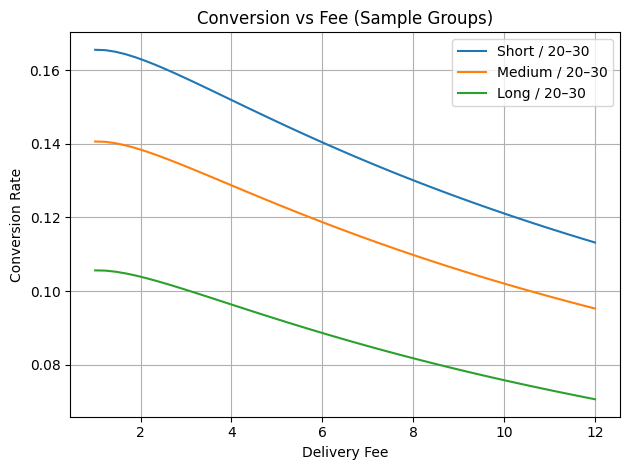

In [57]:
for dist in ['Short', 'Medium', 'Long']:
    for time_bin in ['20–30']:
        segment = df_results[
            (df_results['distance_bucket'] == dist) &
            (df_results['delivery_time_bin'] == time_bin)
        ]
        plt.plot(segment['fee'], segment['conversion_prob'], label=f"{dist} / {time_bin}")

plt.xlabel("Delivery Fee")
plt.ylabel("Conversion Rate")
plt.title("Conversion vs Fee (Sample Groups)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import statsmodels.formula.api as smf

# Add squared terms & interaction to your DataFrame
filtered_segment["log_fee_sq"] = filtered_segment["log_fee"] ** 2
filtered_segment["log_time_sq"] = filtered_segment["log_time"] ** 2
filtered_segment["log_fee_x_time"] = filtered_segment["log_fee"] * filtered_segment["log_time"]

# Fit GLM with non-linear effects
elasticity_glm = smf.glm(
    "converted ~ log_fee + log_fee_sq + log_time + log_time_sq + log_fee_x_time + C(distance_category, Treatment(reference='Short'))",
    data=filtered_segment,
    family=sm.families.Binomial()
).fit()

# Show model summary
print(elasticity_glm.summary2())


NameError: name 'filtered_segment' is not defined

In [32]:
filtered_segment["shop_distance_group"] = (
    filtered_segment["shopId"].astype(str) + "_" + filtered_segment["distance_category"].astype(str)
)

# Fit MixedLM with combined group
import statsmodels.formula.api as smf

mixed_model = smf.mixedlm(
    "converted ~ log_fee + log_time",
    data=filtered_segment,
    groups=filtered_segment["shop_distance_group"],
    re_formula="1"
).fit()

print(mixed_model.summary())


NameError: name 'filtered_segment' is not defined

In [33]:
listings_df.columns

Index(['dh_platform', 'global_entity_id', 'platform', 'session_key', 'shopId',
       'eventTimestamp', 'locationLat', 'locationLon',
       'promisedDeliveryTimeRangeUpper', 'promisedDeliveryTimeRangeLower',
       'locationCountry', 'locationCity', 'shopDeliveryFee', 'serviceFee',
       'shopMinimumOrderValue', 'shopSponsoring', 'shopPosition',
       'perseusClientId', 'pageType', 'userId', 'eventAction',
       'shopRatingQuality', 'rn', 'vendor_id', 'vendor_name',
       'vertical_parent', 'vertical_type', 'chain_id', 'chain_name',
       'latitude', 'longitude', 'category_parent_id', 'category_id',
       'global_category_id', 'category_name', 'is_main_category',
       'session_key_details', 'shopId_details', 'timestamp_details',
       'rn_details', 'distance_km', 'average_delivery_time', 'log_fee',
       'log_time', 'converted', 'distance_bucket', 'log_delivery_fee'],
      dtype='object')

In [34]:
import bambi as bmb
import arviz as az
import numpy as np

# Log-transform fee and time
listings_df["log_fee"] = np.log1p(listings_df["shopDeliveryFee"])
listings_df["log_time"] = np.log1p(listings_df["average_delivery_time"])

# Ensure None values are treated as NaN
listings_df['session_key_details'] = listings_df['session_key_details'].replace({'None': pd.NA})

# Create the 'click' column: 1 if not NaN, 0 otherwise
listings_df['converted'] = listings_df['session_key_details'].notna().astype(int)

# Drop any NaNs or infs
listings_df.replace([np.inf, -np.inf], np.nan, inplace=True)
listings_df.dropna(subset=["log_fee", "log_time", "converted"], inplace=True)

# # Bayesian hierarchical model
# model = bmb.Model("""
# converted ~ log_fee + log_time + 
#             (1|shopId) + (1|locationCity) + (1|category_name) + (1|distance_bucket)
# """, data=listings_df, family="bernoulli")

# # Fit the model with sampling
# results = model.fit(draws=1000, tune=1000, chains=2, target_accept=0.95)

# # Summary of results
# az.summary(results, var_names=["log_fee", "log_time"])


In [35]:
sample_df = listings_df.sample(n=5000, random_state=42)

model = bmb.Model("converted ~ log_fee + log_time + (1|shopId) + (1|locationCity) + (1|category_name) + (1|distance_bucket)", data=sample_df, family="bernoulli")

results = model.fit(draws=500, tune=500, chains=1, cores=1)


Modeling the probability that converted==1
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [Intercept, log_fee, log_time, 1|shopId_sigma, 1|shopId_offset, 1|locationCity_sigma, 1|locationCity_offset, 1|category_name_sigma, 1|category_name_offset, 1|distance_bucket_sigma, 1|distance_bucket_offset]


Output()

Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 22 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [36]:
az.summary(results, var_names=["log_fee", "log_time"])


arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
log_fee  -0.122  0.062  -0.234   -0.003      0.003    0.003     546.0   
log_time -0.174  0.161  -0.462    0.125      0.007    0.008     593.0   

          ess_tail  r_hat  
log_fee      265.0    NaN  
log_time     353.0    NaN

In [49]:
sample_df = listings_df.sample(n=20000, random_state=42)

sample_df["log_fee_sq"] = sample_df["log_fee"] ** 2
sample_df["log_time_sq"] = sample_df["log_time"] ** 2

sample_df.replace([np.inf, -np.inf], np.nan, inplace=True)
sample_df.dropna(subset=["log_fee", "log_time", "converted"], inplace=True)

model = bmb.Model("""
converted ~ log_fee + log_time + 
            (1|shopId) + (1|locationCity) + (1|category_name) + (1|distance_bucket)
""", data=sample_df, family="bernoulli")

results = model.fit(draws=1000, tune=1000, chains=4, cores=1, 
                    target_accept=0.95, max_treedepth=15)

Modeling the probability that converted==1
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, log_fee, log_time, 1|shopId_sigma, 1|shopId_offset, 1|locationCity_sigma, 1|locationCity_offset, 1|category_name_sigma, 1|category_name_offset, 1|distance_bucket_sigma, 1|distance_bucket_offset]


Output()

In [ ]:
import arviz as az

# Save to NetCDF file
az.to_netcdf(results, "bayesian_model_results.nc")
print("✅ Model results saved to bayesian_model_results.nc")

In [ ]:
import arviz as az

summary = az.summary(results)
print(summary)

az.plot_trace(results, var_names=["log_fee", "log_time"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
log_fee     -0.731  0.023  -0.754   -0.708      0.016      0.0       3.0   
log_fee_sq   0.217  0.138   0.079    0.355      0.097      0.0       2.0   
log_time     0.089  0.842  -0.753    0.930      0.593      0.0       3.0   
log_time_sq -0.695  0.276  -0.970   -0.419      0.194      0.0       3.0   

             ess_tail  r_hat  
log_fee          21.0   1.87  
log_fee_sq       24.0   2.76  
log_time         12.0   1.90  
log_time_sq      11.0   1.97

In [ ]:
model = bmb.Model("""
converted ~ s(log_fee) + s(log_time) + 
            (1|shopId) + (1|locationCity) + (1|category_name) + (1|distance_bucket)
""", data=filtered_segment, family="bernoulli")


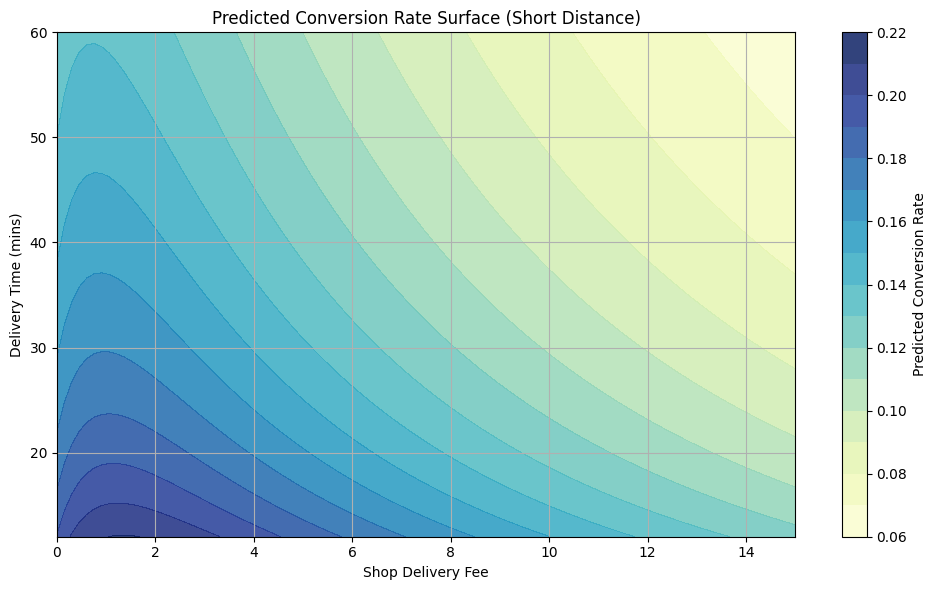

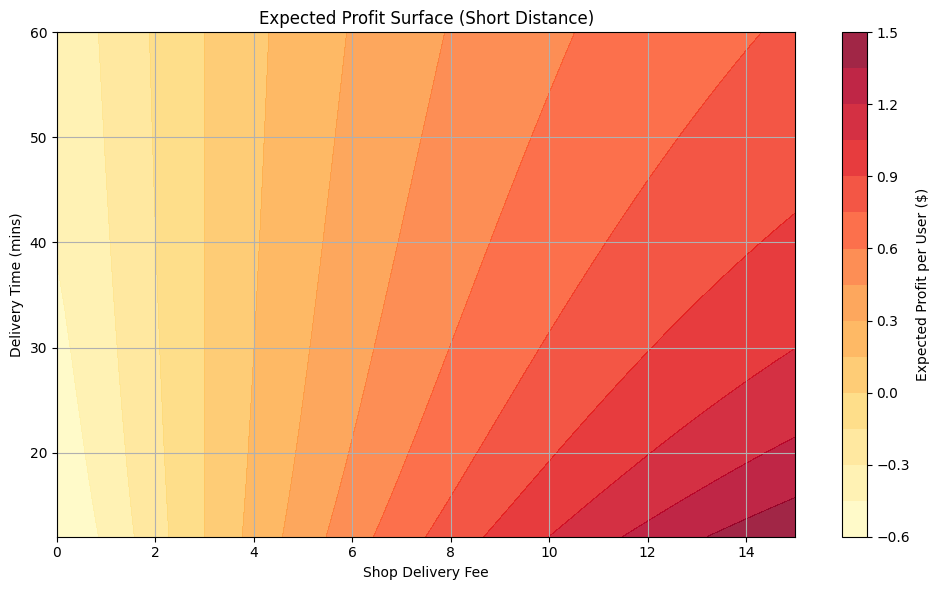

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_66878/760506500.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  recommendation_table = predict_df.groupby("time_bucket").apply(


KeyError: "['shopDeliveryFee'] not in index"

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# --- Setup: Create fee/time grid ---
fee_range = np.linspace(filtered_segment["shopDeliveryFee"].min(), 15, 100)
time_range = np.linspace(filtered_segment["average_delivery_time"].min(), 60, 100)
fee_grid, time_grid = np.meshgrid(fee_range, time_range)

# Flatten for prediction
flat_fee = fee_grid.ravel()
flat_time = time_grid.ravel()

# Log transforms + interaction terms
log_fee_flat = np.log1p(flat_fee)
log_fee_sq_flat = log_fee_flat ** 2
log_time_flat = np.log1p(flat_time)
log_time_sq_flat = log_time_flat ** 2
log_fee_x_time_flat = log_fee_flat * log_time_flat

# Create prediction DataFrame
predict_df = pd.DataFrame({
    "log_fee": log_fee_flat,
    "log_fee_sq": log_fee_sq_flat,
    "log_time": log_time_flat,
    "log_time_sq": log_time_sq_flat,
    "log_fee_x_time": log_fee_x_time_flat,
    "distance_category": "Short"
})

# Predict conversion probability using the quadratic interaction model
predict_df["predicted_conversion"] = elasticity_glm.predict(predict_df)

# Estimate profit per order
base_cost = 2.0
cost_per_km = 0.5
avg_distance_km = 2.0  # assume short distance
estimated_cost_flat = base_cost + cost_per_km * avg_distance_km
profit_per_order = flat_fee - estimated_cost_flat

# Expected profit
predict_df["expected_profit"] = predict_df["predicted_conversion"] * profit_per_order

# Reshape for surface plots
conversion_grid = predict_df["predicted_conversion"].values.reshape(fee_grid.shape)
profit_grid = predict_df["expected_profit"].values.reshape(fee_grid.shape)

# --- Plot 1: Conversion Elasticity Surface ---
plt.figure(figsize=(10, 6))
plt.contourf(fee_grid, time_grid, conversion_grid, levels=15, cmap='YlGnBu', alpha=0.85)
plt.colorbar(label="Predicted Conversion Rate")
plt.xlabel("Shop Delivery Fee")
plt.ylabel("Delivery Time (mins)")
plt.title("Predicted Conversion Rate Surface (Short Distance)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Expected Profit Surface ---
plt.figure(figsize=(10, 6))
plt.contourf(fee_grid, time_grid, profit_grid, levels=15, cmap='YlOrRd', alpha=0.85)
plt.colorbar(label="Expected Profit per User ($)")
plt.xlabel("Shop Delivery Fee")
plt.ylabel("Delivery Time (mins)")
plt.title("Expected Profit Surface (Short Distance)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Table: Recommended Fee per Time Bucket ---
# Define time buckets
predict_df["time_bucket"] = pd.cut(flat_time, bins=[0, 20, 40, 60], labels=["Fast (0–20)", "Medium (20–40)", "Slow (40–60)"])

# Group by time_bucket, find fee that maximizes expected profit
recommendation_table = predict_df.groupby("time_bucket").apply(
    lambda df: df.loc[df["expected_profit"].idxmax()][["shopDeliveryFee", "predicted_conversion", "expected_profit"]]
).reset_index()

recommendation_table.columns = ["Time Bucket", "Shop Delivery Fee", "Predicted Conversion", "Expected Profit"]

import ace_tools as tools; tools.display_dataframe_to_user(name="Recommended Fee Table by Delivery Time", dataframe=recommendation_table)

# Done: Two plots + table displayed



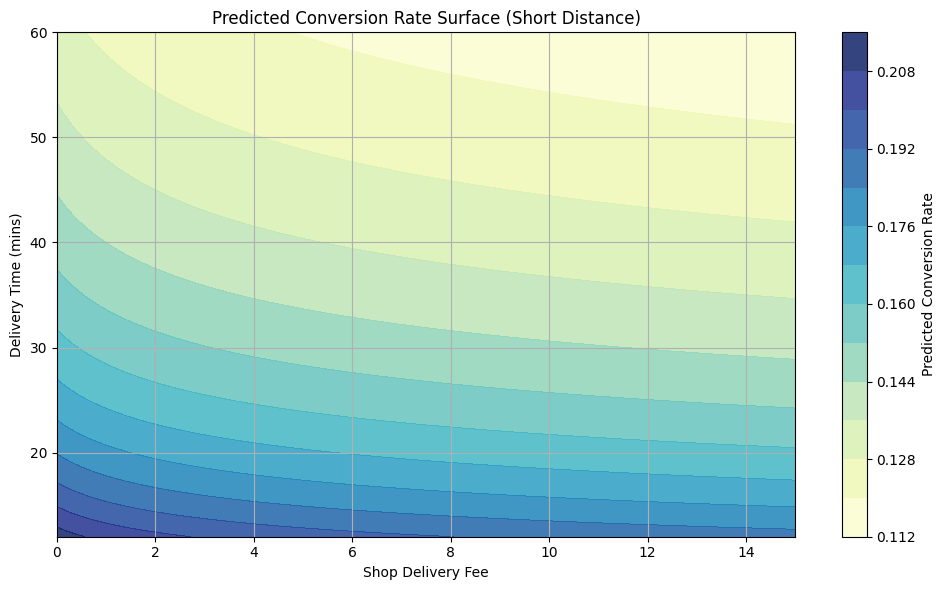

In [71]:
# Generate grid of fee/time combinations for prediction
fee_range = np.linspace(filtered_segment["shopDeliveryFee"].min(), 15, 100)
time_range = np.linspace(filtered_segment["average_delivery_time"].min(), 60, 100)
fee_grid, time_grid = np.meshgrid(fee_range, time_range)

# Flatten grid for DataFrame
flat_fee = fee_grid.ravel()
flat_time = time_grid.ravel()

# Log-transform
log_fee_flat = np.log1p(flat_fee)
log_time_flat = np.log1p(flat_time)

# Create prediction DataFrame for Short distance (reference group)
predict_df = pd.DataFrame({
    "log_fee": log_fee_flat,
    "log_time": log_time_flat,
    "distance_category": "Short"
})

# Predict conversion probability using the GLM model
predict_df["predicted_conversion"] = elasticity_model_sm.predict(predict_df)

# Reshape predictions back to grid
conversion_grid = predict_df["predicted_conversion"].values.reshape(fee_grid.shape)

# Plot conversion rate elasticity surface
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
contour = plt.contourf(fee_grid, time_grid, conversion_grid, levels=15, cmap='YlGnBu', alpha=0.85)
plt.colorbar(label="Predicted Conversion Rate")
plt.xlabel("Shop Delivery Fee")
plt.ylabel("Delivery Time (mins)")
plt.title("Predicted Conversion Rate Surface (Short Distance)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [73]:
filtered_segment[filtered_segment['distance_category'] == 'Short']['shopDeliveryFee'].mean()

np.float64(2.761504118004723)

In [74]:
filtered_segment[filtered_segment['distance_category'] == 'Short']['average_delivery_time'].mean()

np.float64(21.005287997115158)

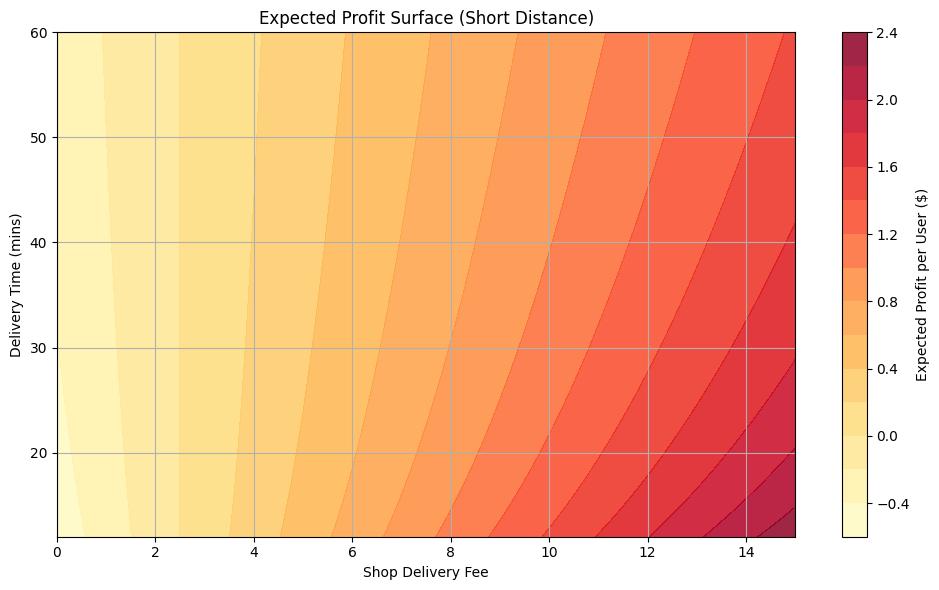

In [77]:
# Create grid again for fee and time
fee_range = np.linspace(filtered_segment["shopDeliveryFee"].min(), 15, 100)
time_range = np.linspace(filtered_segment["average_delivery_time"].min(), 60, 100)
fee_grid, time_grid = np.meshgrid(fee_range, time_range)

# Flatten grid
flat_fee = fee_grid.ravel()
flat_time = time_grid.ravel()

# Log transforms
log_fee_flat = np.log1p(flat_fee)
log_time_flat = np.log1p(flat_time)

# Create prediction DataFrame (Short distance)
predict_df = pd.DataFrame({
    "log_fee": log_fee_flat,
    "log_time": log_time_flat,
    "distance_category": "Short"
})

# Predict conversion probability
predict_df["predicted_conversion"] = elasticity_model_sm.predict(predict_df)

# Estimate profit per order
base_cost = 2.0
cost_per_km = 0.5
# Assume average short distance: 2 km
avg_distance_km = 1.0
estimated_cost_flat = base_cost + cost_per_km * avg_distance_km
profit_per_order = flat_fee - estimated_cost_flat

# Expected profit = conversion × profit per order
expected_profit = predict_df["predicted_conversion"] * profit_per_order
predict_df["expected_profit"] = expected_profit

# Reshape for plotting
profit_grid = predict_df["expected_profit"].values.reshape(fee_grid.shape)

# Plot contour for expected profit
plt.figure(figsize=(10, 6))
contour = plt.contourf(fee_grid, time_grid, profit_grid, levels=15, cmap='YlOrRd', alpha=0.85)
plt.colorbar(label="Expected Profit per User ($)")
plt.xlabel("Shop Delivery Fee")
plt.ylabel("Delivery Time (mins)")
plt.title("Expected Profit Surface (Short Distance)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [89]:
from linearmodels.panel import PanelData, PanelOLS

# Set MultiIndex for panel structure
filtered_panel = filtered_segment.set_index(["shopId", filtered_segment.index])

# Prepare PanelData
panel_data = PanelData(filtered_panel)

# Add constant for intercept
filtered_panel["const"] = 1

# Define independent variables
exog_vars = ["log_fee", "log_fee_sq", "log_time", "log_time_sq", "log_fee_x_time"]
exog = filtered_panel[exog_vars]

# Fit PanelOLS with shop fixed effects
panel_model = PanelOLS(filtered_panel["converted"], exog, entity_effects=True).fit(cov_type="clustered", cluster_entity=True)

print(panel_model.summary)


ModuleNotFoundError: No module named 'linearmodels'

In [6]:
# ### Check dataframe details ###

# # Basic overview
# df.info()          # Column names, non-null counts, and data types
# df.describe()      # Summary statistics for numerical columns
# df.head()          # First 5 rows
# #df.sample(5)       # Random 5 rows

# import missingno as msno
# msno.matrix(df)

# df[df.duplicated()]
# #df[df.duplicated(subset=['column_name'], keep=False)]

# # df['category_column'].value_counts()
# # df['category_column'].nunique()

# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10,6))
# sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
# plt.show()

# import numpy as np

# df.boxplot(column=['numerical_column'])

# df.skew()


# df['column_name'].unique()
# df['column_name'].apply(lambda x: type(x)).value_counts()

# df.pivot_table(index='category_column', values='numerical_column', aggfunc='mean')


# sns.pairplot(df, hue="category_column")


# df['category_column'].value_counts(normalize=True)


# from pandas_profiling import ProfileReport

# profile = ProfileReport(df)
# profile.to_notebook_iframe()


# df['new_column'] = df['existing_column'].apply(lambda x: x*2 if x > 10 else x)


# df.groupby('category_column')['numerical_column'].agg(['mean', 'sum', 'count'])


# df.query("numerical_column > 100 & category_column == 'A'")

# df = pd.get_dummies(df, columns=['category_column'])


# df.memory_usage(deep=True).sum() / 1e6  # Check memory in MB
# df.astype({'int_column': 'int32', 'float_column': 'float32'})  # Downcast types

# df['date_column'] = pd.to_datetime(df['date_column'])
# df.set_index('date_column').resample('M').mean()


# import scipy.stats as stats
# import matplotlib.pyplot as plt

# # Histogram
# df['numerical_column'].hist(bins=30)

# # Q-Q Plot
# stats.probplot(df['numerical_column'], dist="norm", plot=plt)
# plt.show()

# pd.crosstab(df['category_column1'], df['category_column2'], normalize='index')


# import numpy as np

# def bootstrap_mean(data, n_iterations=1000):
#     sample_means = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_iterations)]
#     return np.percentile(sample_means, [2.5, 97.5])  # 95% confidence interval

# bootstrap_mean(df['numerical_column'])


# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df.select_dtypes(include=['number']))

# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(df_scaled)

# df['PCA1'] = pca_result[:, 0]
# df['PCA2'] = pca_result[:, 1]



# import pymc3 as pm

# with pm.Model():
#     p = pm.Beta('p', alpha=2, beta=2)
#     obs = pm.Binomial('obs', n=10, p=p, observed=[6, 7, 8])
#     trace = pm.sample(1000, return_inferencedata=False)

# pm.plot_posterior(trace)


In [ ]:
### Convert to relevant Dtypes ###

# Convert integer columns to int (avoids type mismatches)
int_columns = ["promisedDeliveryTimeRangeUpper", "promisedDeliveryTimeRangeLower", "shopDeliveryFee", 
               "serviceFee", "shopMinimumOrderValue", "shopRank", "shopPosition", "shopId_details", "rn_details"]

for col in int_columns:
    if col in listings_df.columns:
        listings_df[col] = pd.to_numeric(listings_df[col], errors='coerce').fillna(0).astype(float)

# Convert all string columns to str (ensures no mixed types)
string_columns = ["dh_platform", "global_entity_id", "platform", "session_key", "locationCountry", 
                  "locationCity", "verticalType", "shopListType", "shopSponsoring", "shopType", 
                  "shopName", "shopCuisine", "perseusClientId", "shopCategorySelected", "pageType", 
                  "userId", "eventAction", "hour_of_the_day", "shopRatingQuality", "session_key_details"]

for col in string_columns:
    if col in listings_df.columns:
        listings_df[col] = listings_df[col].astype(str)  # Force string type

In [ ]:
### Add relevant Columns ###

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c  # Distance in km

# Ensure latitude and longitude values are numeric
listings_df[['locationLat', 'locationLon', 'latitude', 'longitude']] = listings_df[
    ['locationLat', 'locationLon', 'latitude', 'longitude']
].apply(pd.to_numeric, errors='coerce')

# Apply function to calculate distance
listings_df['distance_km'] = listings_df.apply(
    lambda row: haversine(row['locationLat'], row['locationLon'], row['latitude'], row['longitude']), axis=1
)

In [20]:
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName("Test").getOrCreate()
# print(spark.version)

In [21]:
# from pyspark.sql import SparkSession
# from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, TimestampType


# listings_df["eventTimestamp"] = listings_df["eventTimestamp"].dt.tz_localize(None)
# listings_df["timestamp_details"] = listings_df["timestamp_details"].dt.tz_localize(None)

# # Ensure timestamps are datetime & remove timezone
# timestamp_columns = ["eventTimestamp", "timestamp_details"]
# for col in timestamp_columns:
#     if col in listings_df.columns:
#         listings_df[col] = pd.to_datetime(listings_df[col], errors='coerce')  # Convert; invalids -> NaT
#         listings_df[col] = listings_df[col].dt.tz_localize(None)  # Remove timezone

# # Replace NaT (invalid timestamps) with a default timestamp (e.g., '1970-01-01')
# default_timestamp = pd.Timestamp("1970-01-01 00:00:00")
# for col in timestamp_columns:
#     listings_df[col].fillna(default_timestamp, inplace=True)

# # Define schema with proper TimestampType
# schema = StructType([
#     StructField("dh_platform", StringType(), True),
#     StructField("global_entity_id", StringType(), True),
#     StructField("platform", StringType(), True),
#     StructField("session_key", StringType(), True),
#     StructField("eventTimestamp", TimestampType(), True),  # Ensure this column is converted
#     StructField("promisedDeliveryTimeRangeUpper", IntegerType(), True),
#     StructField("promisedDeliveryTimeRangeLower", IntegerType(), True),
#     StructField("locationCountry", StringType(), True),
#     StructField("locationCity", StringType(), True),
#     StructField("shopDeliveryFee", IntegerType(), True),
#     StructField("serviceFee", IntegerType(), True),
#     StructField("shopMinimumOrderValue", IntegerType(), True),
#     StructField("verticalType", StringType(), True),
#     StructField("shopListType", StringType(), True),
#     StructField("shopSponsoring", StringType(), True),
#     StructField("shopType", StringType(), True),
#     StructField("shopName", StringType(), True),
#     StructField("shopCuisine", StringType(), True),
#     StructField("shopRank", IntegerType(), True),
#     StructField("shopPosition", IntegerType(), True),
#     StructField("perseusClientId", StringType(), True),
#     StructField("shopCategorySelected", StringType(), True),
#     StructField("pageType", StringType(), True),
#     StructField("userId", StringType(), True),
#     StructField("eventAction", StringType(), True),
#     StructField("hour_of_the_day", StringType(), True),
#     StructField("shopRatingQuality", StringType(), True),
#     StructField("session_key_details", StringType(), True),
#     StructField("shopId_details", IntegerType(), True),
#     StructField("timestamp_details", TimestampType(), True),  # Ensure this column is converted
#     StructField("rn_details", IntegerType(), True),
# ])

# # Convert to Spark DataFrame
# listings_sdf = spark.createDataFrame(listings_df, schema=schema)

# # Print schema to confirm TimestampType is correctly applied
# listings_sdf.printSchema()

# # Show sample data
# listings_sdf.show(5)

In [22]:
# import pandas as pd

# # Convert timestamps to datetime & remove timezone
# timestamp_columns = ["eventTimestamp", "timestamp_details"]
# for col in timestamp_columns:
#     if col in listings_df.columns:
#         listings_df[col] = pd.to_datetime(listings_df[col], errors='coerce')  # Convert; invalids → NaT
#         listings_df[col] = listings_df[col].dt.tz_localize(None)  # Remove timezone

# # 🔥 Find and print any remaining non-datetime values
# for col in timestamp_columns:
#     non_datetime_values = listings_df[~listings_df[col].apply(lambda x: pd.notna(x) and isinstance(x, pd.Timestamp))][col].unique()
#     print(f"⚠️ Non-datetime values in {col}: {non_datetime_values}")

In [23]:
# # Re-confirm timestamps are in the correct format
# timestamp_columns = ["eventTimestamp", "timestamp_details"]
# for col in timestamp_columns:
#     if col in listings_df.columns:
#         listings_df[col] = pd.to_datetime(listings_df[col], errors='coerce')  # Convert again for safety
#         listings_df[col] = listings_df[col].astype("datetime64[ns]")  # Force pandas datetime type

# # Convert integer columns to int (avoids type mismatches)
# int_columns = ["promisedDeliveryTimeRangeUpper", "promisedDeliveryTimeRangeLower", "shopDeliveryFee", 
#                "serviceFee", "shopMinimumOrderValue", "shopRank", "shopPosition", "shopId_details", "rn_details"]

# for col in int_columns:
#     if col in listings_df.columns:
#         listings_df[col] = pd.to_numeric(listings_df[col], errors='coerce').fillna(0).astype(int)

# # Convert all string columns to str (ensures no mixed types)
# string_columns = ["dh_platform", "global_entity_id", "platform", "session_key", "locationCountry", 
#                   "locationCity", "verticalType", "shopListType", "shopSponsoring", "shopType", 
#                   "shopName", "shopCuisine", "perseusClientId", "shopCategorySelected", "pageType", 
#                   "userId", "eventAction", "hour_of_the_day", "shopRatingQuality", "session_key_details"]

# for col in string_columns:
#     if col in listings_df.columns:
#         listings_df[col] = listings_df[col].astype(str)  # Force string type


# from pyspark.sql import SparkSession
# from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType

# # Define Schema Explicitly
# schema = StructType([
#     StructField("dh_platform", StringType(), True),
#     StructField("global_entity_id", StringType(), True),
#     StructField("platform", StringType(), True),
#     StructField("session_key", StringType(), True),
#     StructField("eventTimestamp", TimestampType(), True),  
#     StructField("promisedDeliveryTimeRangeUpper", IntegerType(), True),
#     StructField("promisedDeliveryTimeRangeLower", IntegerType(), True),
#     StructField("locationCountry", StringType(), True),
#     StructField("locationCity", StringType(), True),
#     StructField("shopDeliveryFee", IntegerType(), True),
#     StructField("serviceFee", IntegerType(), True),
#     StructField("shopMinimumOrderValue", IntegerType(), True),
#     StructField("verticalType", StringType(), True),
#     StructField("shopListType", StringType(), True),
#     StructField("shopSponsoring", StringType(), True),
#     StructField("shopType", StringType(), True),
#     StructField("shopName", StringType(), True),
#     StructField("shopCuisine", StringType(), True),
#     StructField("shopRank", IntegerType(), True),
#     StructField("shopPosition", IntegerType(), True),
#     StructField("perseusClientId", StringType(), True),
#     StructField("shopCategorySelected", StringType(), True),
#     StructField("pageType", StringType(), True),
#     StructField("userId", StringType(), True),
#     StructField("eventAction", StringType(), True),
#     StructField("hour_of_the_day", StringType(), True),
#     StructField("shopRatingQuality", StringType(), True),
#     StructField("session_key_details", StringType(), True),
#     StructField("shopId_details", IntegerType(), True),
#     StructField("timestamp_details", TimestampType(), True),
#     StructField("rn_details", IntegerType(), True),
# ])

# # 🚀 Convert to Spark DataFrame
# listings_sdf = spark.createDataFrame(listings_df, schema=schema)

# # Print Schema to confirm
# listings_sdf.printSchema()

# # Show sample data
# listings_sdf.show(5)



In [24]:

# # Initialize Spark session
# spark = SparkSession.builder.appName("Fix_Timestamp_Issue").getOrCreate()




In [25]:
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

listings_df = client.query(listings_data).to_dataframe()

# Re-confirm timestamps are in the correct format
# timestamp_columns = ["eventTimestamp", "timestamp_details"]
# for col in timestamp_columns:
#     if col in listings_df.columns:
#         listings_df[col] = pd.to_datetime(listings_df[col], errors='coerce')  # Convert again for safety
#         listings_df[col] = listings_df[col].astype("datetime64[ns]")  # Force pandas datetime type

# Convert integer columns to int (avoids type mismatches)
int_columns = ["promisedDeliveryTimeRangeUpper", "promisedDeliveryTimeRangeLower", "shopDeliveryFee", 
               "serviceFee", "shopMinimumOrderValue", "shopRank", "shopPosition", "shopId_details", "rn_details"]

for col in int_columns:
    if col in listings_df.columns:
        listings_df[col] = pd.to_numeric(listings_df[col], errors='coerce').fillna(0).astype(int)

# Convert all string columns to str (ensures no mixed types)
string_columns = ["dh_platform", "global_entity_id", "platform", "session_key", "locationCountry", 
                  "locationCity", "verticalType", "shopListType", "shopSponsoring", "shopType", 
                  "shopName", "shopCuisine", "perseusClientId", "shopCategorySelected", "pageType", 
                  "userId", "eventAction", "hour_of_the_day", "shopRatingQuality", "session_key_details"]

for col in string_columns:
    if col in listings_df.columns:
        listings_df[col] = listings_df[col].astype(str)  # Force string type


# Convert Pandas DataFrame to Spark DataFrame
#listings_sdf = spark.createDataFrame(listings_df)

# Show results
#listings_sdf.show(5)

/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [26]:
listings_df.head()

dh_platform global_entity_id platform               session_key shopId  \
0     pandora            PO_FI  Android  2ahXVk64sLNUIOpGdBjvGA==   w75r   
1     pandora            PO_FI      iOS  7kFCWfguUJnqtUxM8JYjDA==   vfp6   
2     pandora            PO_FI  Android  9/6ZlFJXBIRUUisZnQAMNQ==   sfnq   
3     pandora            PO_FI      iOS  B5hI03jeLRv+5PhWk4/cQg==   sfnq   
4     pandora            PO_FI  Android  FlBhXEL+r5usl056GCDB+A==   ba7n   

                    eventTimestamp  locationLat  locationLon  \
0 2025-02-15 11:23:44.113000+00:00   60.4091562   23.0788327   
1 2025-02-13 10:30:13.262000+00:00  62.64123309  29.80331149   
2 2025-02-15 16:35:50.346000+00:00    60.466046    22.346316   
3 2025-02-15 09:19:00.400000+00:00  60.40404747  22.32250348   
4 2025-02-03 15:50:07.250000+00:00   60.3522341   23.1263584   

   promisedDeliveryTimeRangeUpper  promisedDeliveryTimeRangeLower  ...  \
0                              35                              20  ...   
1                              60                              40  ...   
2                              60                              40  ...   
3                              45                              30  ...   
4                              35                              20  ...   

  vertical_type chain_id  chain_name         vendor_name   latitude  \
0   restaurants     None        None      Kaksi Lautasta  60.386913   
1   restaurants    cx3as     Arnolds     Arnolds Iso Myy  62.601663   
2   restaurants     None        None         Runostuoppi  60.488930   
3   restaurants     None        None         Runostuoppi  60.488930   
4   restaurants     None        None  Rikala Bar & Grill  60.387202   

   longitude  session_key_details shopId_details timestamp_details rn_details  
0  23.142279                 None              0               NaT          0  
1  29.763600                 None              0               NaT          0  
2  22.260943                 None              0               NaT          0  
3  22.260943                 None              0               NaT          0  
4  23.128270                 None              0               NaT          0  

[5 rows x 33 columns]

In [27]:
listings_df.columns

Index(['dh_platform', 'global_entity_id', 'platform', 'session_key', 'shopId',
       'eventTimestamp', 'locationLat', 'locationLon',
       'promisedDeliveryTimeRangeUpper', 'promisedDeliveryTimeRangeLower',
       'locationCountry', 'locationCity', 'shopDeliveryFee', 'serviceFee',
       'shopMinimumOrderValue', 'shopSponsoring', 'shopPosition',
       'perseusClientId', 'pageType', 'userId', 'eventAction',
       'shopRatingQuality', 'rn', 'vertical_type', 'chain_id', 'chain_name',
       'vendor_name', 'latitude', 'longitude', 'session_key_details',
       'shopId_details', 'timestamp_details', 'rn_details'],
      dtype='object')

In [28]:
import pandas as pd
import numpy as np

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c  # Distance in km

# Ensure latitude and longitude values are numeric
listings_df[['locationLat', 'locationLon', 'latitude', 'longitude']] = listings_df[
    ['locationLat', 'locationLon', 'latitude', 'longitude']
].apply(pd.to_numeric, errors='coerce')

# Apply function to calculate distance
listings_df['distance_km'] = listings_df.apply(
    lambda row: haversine(row['locationLat'], row['locationLon'], row['latitude'], row['longitude']), axis=1
)



In [29]:
# correlation = listings_df['delivery_tome'].corr(listings_df['distance_km'])
# print("Correlation:", correlation)

Correlation: 0.10751781663337036


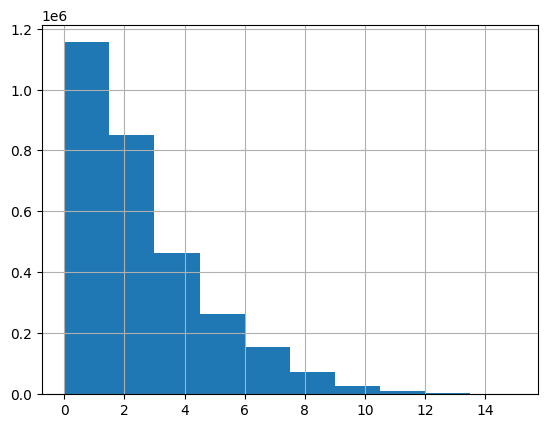

In [30]:
listings_df[listings_df['distance_km'] < 15]['distance_km'].hist()

correlation = listings_df['shopDeliveryFee'].corr(listings_df['distance_km'])
print("Correlation:", correlation)

In [31]:
import pandas as pd
import numpy as np

# Assume listings_df is your DataFrame.

# Convert the relevant columns to numeric, coercing non-numeric values to NaN.
listings_df['promisedDeliveryTimeRangeUpper'] = pd.to_numeric(
    listings_df['promisedDeliveryTimeRangeUpper'], errors='coerce'
)
listings_df['promisedDeliveryTimeRangeLower'] = pd.to_numeric(
    listings_df['promisedDeliveryTimeRangeLower'], errors='coerce'
)
listings_df['shopDeliveryFee'] = pd.to_numeric(
    listings_df['shopDeliveryFee'], errors='coerce'
)

# Optional: Check if conversion worked as expected.
print(listings_df[['promisedDeliveryTimeRangeUpper', 'promisedDeliveryTimeRangeLower', 'shopDeliveryFee']].dtypes)

# Compute the average delivery time.
# (Here I'm taking the midpoint; if you want the sum, remove the division by 2.)
listings_df['average_delivery_time'] = round((
    listings_df['promisedDeliveryTimeRangeUpper'] + listings_df['promisedDeliveryTimeRangeLower']
) / 2,)

epsilon = 1e-6  # small constant to avoid log(0)
listings_df['log_delivery_fee'] = np.log(listings_df['shopDeliveryFee'] + epsilon)
listings_df['log_promised_time'] = np.log(listings_df['average_delivery_time'] + epsilon)

# Add a new column 'click': 1 if session_key_details is not null, else 0
# Ensure None values are treated as NaN
listings_df['session_key_details'] = listings_df['session_key_details'].replace({'None': pd.NA})

# Create the 'click' column: 1 if not NaN, 0 otherwise
listings_df['click'] = listings_df['session_key_details'].notna().astype(int)
# Check the resulting DataFrame
print(listings_df[['promisedDeliveryTimeRangeUpper', 
                   'promisedDeliveryTimeRangeLower', 
                   'average_delivery_time', 
                   'log_delivery_fee', 
                   'log_promised_time', 
                   'click']].head())


# Aggregate the data at the session level
session_df = listings_df.groupby(['session_key','locationCity']).agg(
    avg_delivery_fee = ('shopDeliveryFee', 'mean'),
    avg_delivery_time = ('average_delivery_time', 'mean'),
    click_rate = ('click', 'mean'),    # proportion of shops clicked per session
    num_exposures = ('session_key', 'count')  # number of shops viewed in the session
).reset_index()

# For log-transformation, add a small constant to avoid log(0)
epsilon = 1e-6
session_df['log_avg_delivery_fee'] = np.log(session_df['avg_delivery_fee'] + epsilon)
session_df['log_avg_delivery_time'] = np.log(session_df['avg_delivery_time'] + epsilon)

print(session_df.head())

promisedDeliveryTimeRangeUpper    int64
promisedDeliveryTimeRangeLower    int64
shopDeliveryFee                   int64
dtype: object
   promisedDeliveryTimeRangeUpper  promisedDeliveryTimeRangeLower  \
0                              35                              20   
1                              60                              40   
2                              60                              40   
3                              45                              30   
4                              35                              20   

   average_delivery_time  log_delivery_fee  log_promised_time  click  
0                   28.0          1.945910           3.332205      0  
1                   50.0          1.791760           3.912023      0  
2                   50.0          1.791760           3.912023      0  
3                   38.0          1.945910           3.637586      0  
4                   28.0          1.609438           3.332205      0  
                session_k

In [32]:
listings_df[listings_df['session_key_details'].notna()]

dh_platform global_entity_id platform               session_key  \
7           pandora            PO_FI  Android  K3exguJX+JYkJ9plRiHR0g==   
10          pandora            PO_FI      iOS  PGSJXPWgX+fXkS7CUKsF7A==   
30          pandora            PO_FI      iOS  +mgMsbsxULxGIPbOvzqEsg==   
33          pandora            PO_FI  Android  B9iASp+9cHlpI/ebcnEhTQ==   
39          pandora            PO_FI  Android  YXk4f2Yn+3YhDwqkBHPK9w==   
...             ...              ...      ...                       ...   
3015896     pandora            PO_FI  Android  EoCCEKwz6cugTVUdcRdW3g==   
3015899     pandora            PO_FI  Android  JuvbJ/b9aFGaUjf2K77ZhQ==   
3015912     pandora            PO_FI  Android  1VqtHbOcUUFI3hk4wTv37g==   
3015917     pandora            PO_FI      iOS  F7nm6bGMHQxLh+BLUqg0xg==   
3015930     pandora            PO_FI  Android  waGeUg3STGFUbAYJUiCN6w==   

        shopId                   eventTimestamp  locationLat  locationLon  \
7         ba7n 2025-02-11 15:40:00.076000+00:00    60.361755    23.125612   
10        w75r 2025-02-05 14:08:03.535000+00:00    60.341332    23.302056   
30        f321 2025-02-15 17:37:31.720000+00:00    61.465266    24.057444   
33        ba7n 2025-02-15 16:37:27.281000+00:00    60.388583    23.141694   
39        s2er 2025-02-08 10:56:29.399000+00:00    60.403724    23.107106   
...        ...                              ...          ...          ...   
3015896   zy39 2025-02-12 08:26:28.484000+00:00    60.267790    25.091300   
3015899   zy39 2025-02-14 15:01:20.071000+00:00    60.282933    25.118100   
3015912   zy39 2025-02-08 12:25:14.591000+00:00    60.284082    25.120945   
3015917   h0vs 2025-02-08 15:10:29.966000+00:00    60.317987    24.831766   
3015930   lzga 2025-02-09 09:58:17.384000+00:00    60.277494    24.857612   

         promisedDeliveryTimeRangeUpper  promisedDeliveryTimeRangeLower  ...  \
7                                    35                              20  ...   
10                                   65                              45  ...   
30                                   70                              50  ...   
33                                   40                              25  ...   
39                                   30                              15  ...   
...                                 ...                             ...  ...   
3015896                              30                              15  ...   
3015899                              25                              10  ...   
3015912                              25                              10  ...   
3015917                              30                              15  ...   
3015930                              30                              15  ...   

         longitude       session_key_details  shopId_details  \
7        23.128270  K3exguJX+JYkJ9plRiHR0g==               0   
10       23.142279  PGSJXPWgX+fXkS7CUKsF7A==               0   
30       23.883312  +mgMsbsxULxGIPbOvzqEsg==               0   
33       23.128270  B9iASp+9cHlpI/ebcnEhTQ==               0   
39       23.102576  YXk4f2Yn+3YhDwqkBHPK9w==               0   
...            ...                       ...             ...   
3015896  25.105615  EoCCEKwz6cugTVUdcRdW3g==               0   
3015899  25.105615  JuvbJ/b9aFGaUjf2K77ZhQ==               0   
3015912  25.105615  1VqtHbOcUUFI3hk4wTv37g==               0   
3015917  24.856786  F7nm6bGMHQxLh+BLUqg0xg==               0   
3015930  24.891303  waGeUg3STGFUbAYJUiCN6w==               0   

                       timestamp_details  rn_details distance_km  \
7       2025-02-11 15:40:00.101000+00:00           1    2.833283   
10      2025-02-05 14:08:03.916000+00:00           1   10.142410   
30      2025-02-15 17:37:32.579000+00:00           1    9.844293   
33      2025-02-15 16:37:45.580000+00:00           1    0.753340   
39      2025-02-08 10:56:29.237000+00:00           1    0.860678   
...                                  ...    

In [33]:
# Create a copy of the listings dataframe to ensure the original remains unchanged
listings_cleaned = listings_df.copy()

# Select only relevant columns
X = listings_cleaned[['shopDeliveryFee', 'average_delivery_time', 'distance_km']]

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove rows with NaN values
X.dropna(inplace=True)

# Add intercept column again
X = sm.add_constant(X)

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Print VIF results
print(vif_data)


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_87750/2001586015.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_87750/2001586015.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


NameError: name 'variance_inflation_factor' is not defined

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['shopDeliveryFee', 'average_delivery_time', 'distance_km']])

# Apply PCA to get independent components
pca = PCA(n_components=2)  # Reduce to 2 independent factors
X_pca = pca.fit_transform(X_scaled)

# Convert to DataFrame
pca_df = pd.DataFrame(X_pca, columns=['Component1', 'Component2'])

# Add conversion column
pca_df['conversion'] = listings_df['click']

# Run regression with PCA components
X_pca_sm = sm.add_constant(pca_df[['Component1', 'Component2']])
model_pca = sm.OLS(pca_df['conversion'], X_pca_sm).fit()

print(model_pca.summary())


                            OLS Regression Results                            
Dep. Variable:             conversion   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1044
Date:                Sat, 15 Mar 2025   Prob (F-statistic):              0.901
Time:                        00:41:43   Log-Likelihood:            -1.8562e+06
No. Observations:             5618237   AIC:                         3.712e+06
Df Residuals:                 5618234   BIC:                         3.712e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1304      0.000    917.713      0.0

<Axes: >

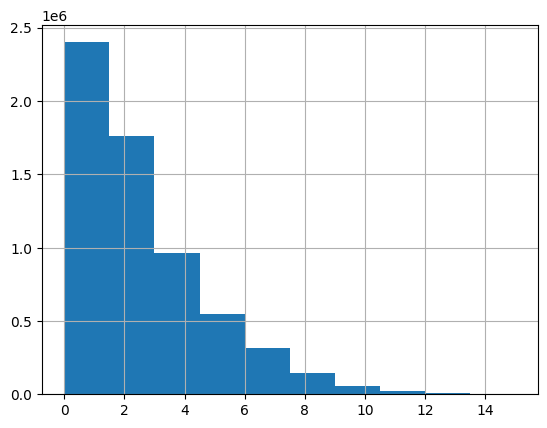

In [ ]:
listings_df[listings_df['distance_km'] < 15]['distance_km'].hist()

<Axes: >

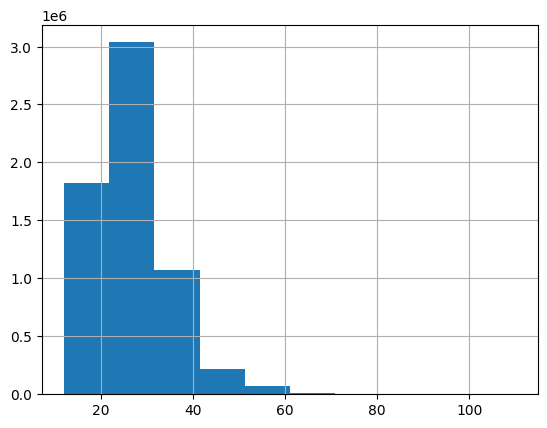

In [ ]:
listings_df[listings_df['average_delivery_time'] < 120]['average_delivery_time'].hist()

<Axes: >

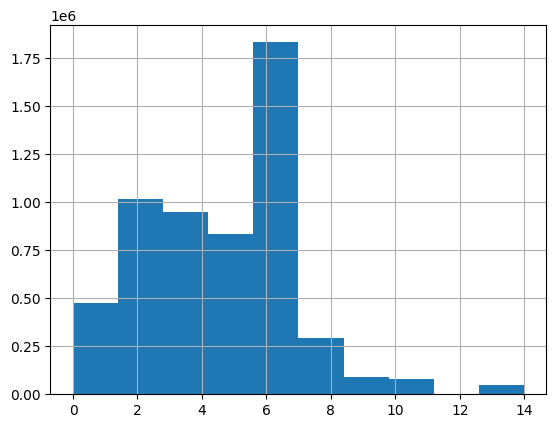

In [ ]:
listings_df[listings_df['shopDeliveryFee'] < 15]['shopDeliveryFee'].hist()

In [ ]:
listings_df.loc[listings_df['shopDeliveryFee'] < 15, 'shopDeliveryFee'] = np.round(
    listings_df['shopDeliveryFee'] * 2
) / 2

listings_df

dh_platform global_entity_id platform               session_key  \
0           pandora            PO_FI      iOS  WqjAmtTXvPxhuZGFPeLuKA==   
1           pandora            PO_FI  Android  e/H/9Vx/SWPUqx7ndCGC1Q==   
2           pandora            PO_FI  Android  hqOW3DhcyMpjHknDzt7gBw==   
3           pandora            PO_FI  Android  3j1iFMILLwW8ZEcpueoGtg==   
4           pandora            PO_FI      iOS  T0+7MWDUFhSZaUu/2iMiEg==   
...             ...              ...      ...                       ...   
6240298     pandora            PO_FI      iOS  XGBPGB6tXA0zMmZtDODRMQ==   
6240299     pandora            PO_FI  Android  l3rW3zPoWgBKFYcR/PMfMw==   
6240300     pandora            PO_FI      iOS  uH/znMCrS2NGfKZAEM+WIA==   
6240301     pandora            PO_FI      iOS  6eeEoYMwMWnJkTDklauohA==   
6240302     pandora            PO_FI      iOS  D8huaMCVkp4Of1KkY9toMA==   

        shopId                   eventTimestamp  locationLat  locationLon  \
0         aqar 2025-02-22 09:12:58.086000+00:00    61.465756    23.722124   
1         aqar 2025-02-04 09:14:16.953000+00:00    61.456223    23.725504   
2         aqar 2025-02-04 11:17:39.450000+00:00    61.473195    23.695462   
3         s2kx 2025-02-08 18:10:28.790000+00:00    61.701653    27.302832   
4         aqar 2025-02-14 13:48:20.920000+00:00    61.470652    23.719350   
...        ...                              ...          ...          ...   
6240298   h7dj 2025-02-18 18:54:33.463000+00:00    60.312656    25.038697   
6240299   h7dj 2025-02-22 17:25:49.923000+00:00    60.285138    25.044032   
6240300   nfbd 2025-02-08 15:32:02.369000+00:00    60.319050    25.095640   
6240301   k9gh 2025-02-13 11:10:03.635000+00:00    60.290535    25.021258   
6240302   k9gh 2025-02-21 10:03:39.450000+00:00    60.297426    25.063123   

         promisedDeliveryTimeRangeUpper  promisedDeliveryTimeRangeLower  ...  \
0                                    25                              10  ...   
1                                    30                              15  ...   
2                                    30                              15  ...   
3                                    35                              20  ...   
4                                    30                              15  ...   
...                                 ...                             ...  ...   
6240298                              25                              10  ...   
6240299                              35                              10  ...   
6240300                              30                              15  ...   
6240301                              30                              15  ...   
6240302                              25                              10  ...   

         longitude session_key_details  shopId_details timestamp_details  \
0        23.715673                None            None               NaT   
1        23.715673                None            None               NaT   
2        23.715673                None            None               NaT   
3        27.272811                None            None               NaT   
4        23.715673                None            None               NaT   
...            ...                 ...             ...               ...   
6240298  25.040296                None            None               NaT   
6240299  25.040296                None            None               NaT   
6240300  25.074174                None            None               NaT   
6240301  25.031150                None            None               NaT   
6240302  25.031150                None            None               NaT   

        rn_details distance_km average_delivery_time log_delivery_fee  \
0             <NA>    0.494842                  18.0         1.095274   
1             <NA>    1.510154                  22.0         1.607436   
2             <NA>    1.171830                  22.0         1.383791   
3             <N

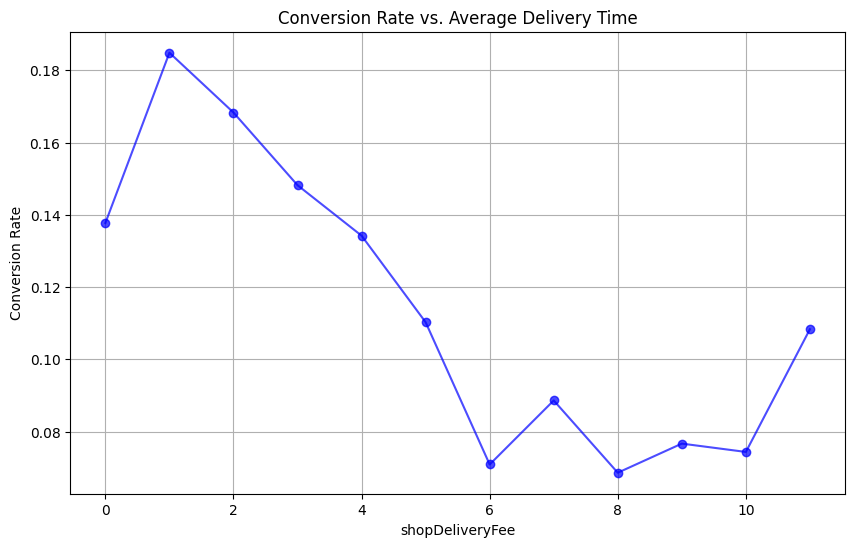

In [ ]:
tt = listings_df.groupby('shopDeliveryFee').agg(
    converted = ('click', 'sum'),
    total_shops=('shopId','count')
).reset_index()

tt['coversion'] = tt['converted'] / tt['total_shops']

tt = tt[tt['shopDeliveryFee'] < 12]

# Plot conversion rate against average delivery time
plt.figure(figsize=(10, 6))
plt.plot(tt['shopDeliveryFee'], tt['coversion'], marker='o', linestyle='-', color='b', alpha=0.7)
plt.xlabel("shopDeliveryFee")
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate vs. Average Delivery Time")
plt.grid(True)
plt.show()

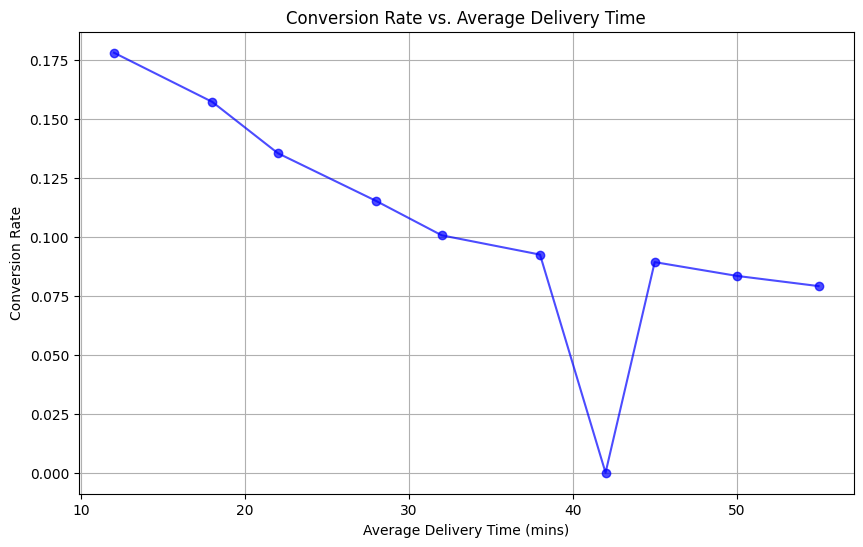

In [ ]:
tt = listings_df.groupby('average_delivery_time').agg(
    converted = ('click', 'sum'),
    total_shops=('shopId','count')
).reset_index()

tt['coversion'] = tt['converted'] / tt['total_shops']

tt  = tt[(tt['average_delivery_time'] < 60) & (tt['average_delivery_time'] > 0)]

# Plot conversion rate against average delivery time
plt.figure(figsize=(10, 6))
plt.plot(tt['average_delivery_time'], tt['coversion'], marker='o', linestyle='-', color='b', alpha=0.7)
plt.xlabel("Average Delivery Time (mins)")
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate vs. Average Delivery Time")
plt.grid(True)
plt.show()


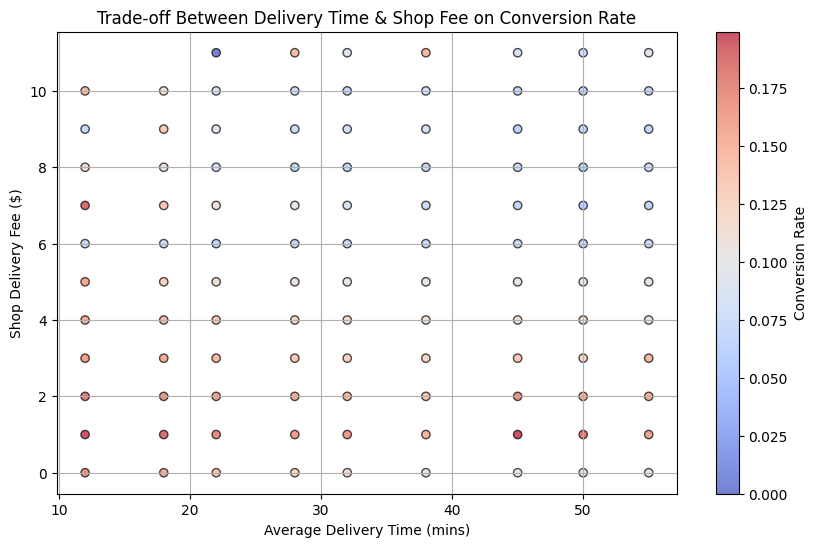

In [ ]:
# Filter out extreme values before grouping
filtered_df = listings_df[(listings_df['average_delivery_time'] < 60) & 
                          (listings_df['average_delivery_time'] > 0) &
                          (listings_df['shopDeliveryFee'] < 12)]

# Aggregate conversion rate by (delivery_time, shop_fee)
tt = filtered_df.groupby(['average_delivery_time', 'shopDeliveryFee']).agg(
    converted=('click', 'sum'),
    total_shops=('shopId', 'count')
).reset_index()

# Compute conversion rate
tt['conversion'] = tt['converted'] / tt['total_shops']

# Scatter plot to show trade-off between delivery time and shop fee
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    tt['average_delivery_time'], tt['shopDeliveryFee'], 
    c=tt['conversion'], cmap='coolwarm', alpha=0.7, edgecolors='k'
)
plt.colorbar(scatter, label='Conversion Rate')
plt.xlabel("Average Delivery Time (mins)")
plt.ylabel("Shop Delivery Fee ($)")
plt.title("Trade-off Between Delivery Time & Shop Fee on Conversion Rate")
plt.grid(True)
plt.show()


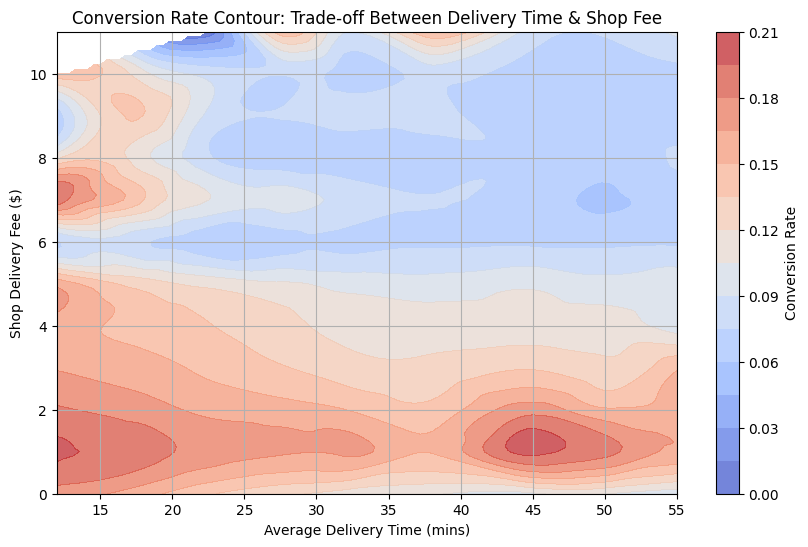

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

# Create a grid for smoother visualization
x = tt['average_delivery_time']
y = tt['shopDeliveryFee']
z = tt['conversion']

# Create a grid for contour plot
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate conversion rate over the grid
zi = scipy.interpolate.griddata((x, y), z, (xi, yi), method='cubic')

# Plot contour chart
plt.figure(figsize=(10, 6))
contour = plt.contourf(xi, yi, zi, levels=15, cmap='coolwarm', alpha=0.75)
plt.colorbar(label="Conversion Rate")
plt.xlabel("Average Delivery Time (mins)")
plt.ylabel("Shop Delivery Fee ($)")
plt.title("Conversion Rate Contour: Trade-off Between Delivery Time & Shop Fee")
plt.grid(True)
plt.show()


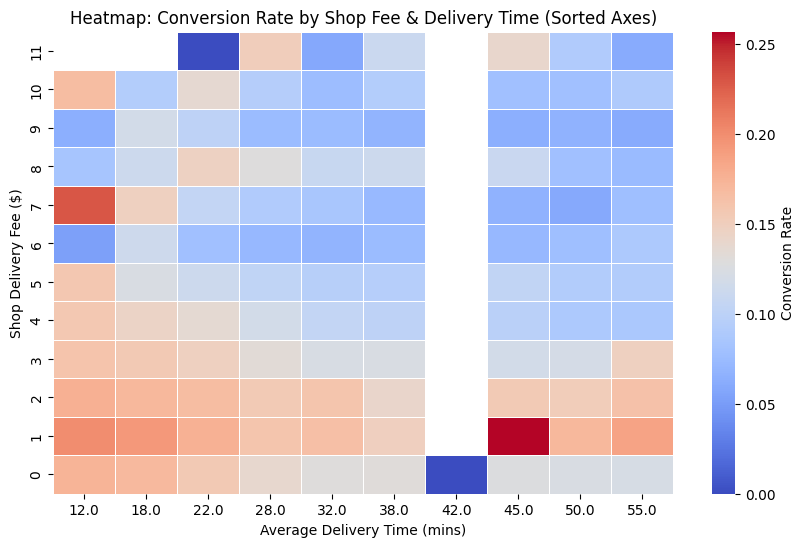

In [ ]:
# Ensure index (Y-axis: Delivery Time) and columns (X-axis: Shop Fee) are sorted in the correct order
heatmap_data = heatmap_data.sort_index(ascending=False)  # Sort Delivery Time (Y-axis) in descending order
heatmap_data = heatmap_data.sort_index(axis=1, ascending=True)  # Sort Shop Fee (X-axis) in ascending order

# Plot heatmap again with corrected axis ordering
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False, linewidths=0.5, cbar_kws={'label': 'Conversion Rate'})
plt.xlabel("Average Delivery Time (mins)")  # X-axis represents Shop Fee
plt.ylabel("Shop Delivery Fee ($)")  # Y-axis represents Delivery Time
plt.title("Heatmap: Conversion Rate by Shop Fee & Delivery Time (Sorted Axes)")
plt.show()


In [ ]:
listings_df.columns

Index(['dh_platform', 'global_entity_id', 'platform', 'session_key', 'shopId',
       'eventTimestamp', 'locationLat', 'locationLon',
       'promisedDeliveryTimeRangeUpper', 'promisedDeliveryTimeRangeLower',
       'locationCountry', 'locationCity', 'shopDeliveryFee', 'serviceFee',
       'shopMinimumOrderValue', 'shopSponsoring', 'shopPosition',
       'perseusClientId', 'pageType', 'userId', 'eventAction',
       'shopRatingQuality', 'rn', 'vertical_type', 'chain_id', 'chain_name',
       'vendor_name', 'latitude', 'longitude', 'session_key_details',
       'shopId_details', 'timestamp_details', 'rn_details', 'distance_km',
       'average_delivery_time', 'log_delivery_fee', 'log_promised_time',
       'click'],
      dtype='object')

In [ ]:
df_session

session_key shopId  conversions  shop_fee  \
0        +++b0H7fIGqLENadjkvesQ==   lv3w            0      5.49   
1        ++0B4qQM4ms6wCHwK9HqpQ==   v2bu            0      5.49   
2        ++17LRnS46b9xDXOdMQn/g==   aod7            0      1.99   
3        ++17LRnS46b9xDXOdMQn/g==   qkwv            0      4.99   
4        ++17LRnS46b9xDXOdMQn/g==   s2rj            0      2.99   
...                           ...    ...          ...       ...   
2413585  zzyouJB8HSNXzJmasr7VQw==   ws1i            0      4.49   
2413586  zzzOsph/9MDXTOAJ1E9TbQ==   s3br            0      5.79   
2413587  zzze2qeZur9ZLdsbcL1ZWw==   wmx9            0      3.79   
2413588  zzzg1GUgydPRRN6lbyh4/w==   v5cb            0      5.79   
2413589  zzzscnDZFwiPNf1f1pFYAA==   s0kn            0      1.99   

         delivery_time  distance_km  log_shop_fee  log_delivery_time  \
0                 18.0     2.008263      1.870263           2.944439   
1                 22.0     2.531617      1.870263           3.135494   
2                 12.0     0.497068      1.095273           2.564949   
3                 22.0     1.796913      1.790091           3.135494   
4                 22.0     0.720644      1.383791           3.135494   
...                ...          ...           ...                ...   
2413585           22.0     1.587483      1.702928           3.135494   
2413586           12.0     2.710330      1.915451           2.564949   
2413587           12.0     1.239496      1.566530           2.564949   
2413588           22.0     3.800552      1.915451           3.135494   
2413589           28.0     0.160695      1.095273           3.367296   

         log_distance_km  log_fee_x_time  log_shop_fee_sq  
0               1.101363        5.506874         3.497882  
1               1.261756        5.864197         3.497882  
2               0.403509        2.809321         1.199624  
3               1.028516        5.612821         3.204427  
4               0.542698        4.338869         1.914878  
...                  ...             ...              ...  
2413585         0.950686        5.339522         2.899965  
2413586         1.311121        4.913035         3.668952  
2413587         0.806251        4.018071         2.454018  
2413588         1.568731        6.005885         3.668952  
2413589         0.149019        3.688110         1.199624  

[2413590 rows x 11 columns]

In [ ]:
import numpy as np
import statsmodels.formula.api as smf

# Aggregate number of conversions per session
df_session = filtered_df.groupby(["session_key", "shopId"]).agg(
    conversions=("click", "sum"),
    shop_fee=("shopDeliveryFee", "max"),
    delivery_time=("average_delivery_time", "first"),
    distance_km=("distance_km", "first")  # Include distance
).reset_index()

# Log transform shop fee, delivery time, and distance
df_session["log_shop_fee"] = np.log1p(df_session["shop_fee"])
df_session["log_delivery_time"] = np.log1p(df_session["delivery_time"])
df_session["log_distance_km"] = np.log1p(df_session["distance_km"])  # New transformation

# Poisson Regression with Fixed Effects
model = smf.poisson("conversions ~ log_shop_fee + log_delivery_time + log_distance_km", data=df_session).fit()

print(model.summary())


NameError: name 'filtered_df' is not defined

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Aggregate number of conversions per session
df_session = filtered_df.groupby(["session_key", "shopId"]).agg(
    conversions=("click", "sum"),
    shop_fee=("shopDeliveryFee", "max"),
    delivery_time=("average_delivery_time", "first"),
).reset_index()

# Log transform shop fee and delivery time
df_session["log_shop_fee"] = np.log1p(df_session["shop_fee"])
df_session["log_delivery_time"] = np.log1p(df_session["delivery_time"])

# Poisson Regression with Fixed Effects
model = smf.poisson("conversions ~ log_shop_fee + log_delivery_time", data=df_session).fit()

print(model.summary())

NameError: name 'filtered_df' is not defined

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np


# Fractional Logit (Using GLM with Binomial family)
model = smf.glm(
    "conversions ~ log_shop_fee + log_delivery_time", 
    data=df_session, 
    family=sm.families.Binomial()
).fit()

print(model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            conversions   No. Observations:              6161191
Model:                            GLM   Df Residuals:                  6161188
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3741e+06
Date:                Sat, 15 Mar 2025   Deviance:                   4.7481e+06
Time:                        02:18:51   Pearson chi2:                 6.16e+06
No. Iterations:                     5   Pseudo R-squ. (CS):           0.006570
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2300      0.01

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

df_session["log_fee_x_time"] = df_session["log_shop_fee"] * df_session["log_delivery_time"]
df_session["log_shop_fee_sq"] = df_session["log_shop_fee"] ** 2
df_session["log_fee_x_distance"] = df_session["log_shop_fee"] * df_session["log_distance_km"]

model_nb = smf.glm(
    "conversions ~ log_shop_fee + log_shop_fee_sq + log_delivery_time + log_distance_km",  
    data=df_session,
    family=sm.families.NegativeBinomial()
).fit()

# model_nb = smf.glm(
#     "conversions ~ log_shop_fee + log_shop_fee_sq + log_delivery_time + log_fee_x_time + log_distance_km + log_fee_x_distance",  
#     data=df_session,
#     family=sm.families.NegativeBinomial()
# ).fit()

print(model_nb.summary())

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:            conversions   No. Observations:              6161191
Model:                            GLM   Df Residuals:                  6161186
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4743e+06
Date:                Sat, 15 Mar 2025   Deviance:                   2.7077e+06
Time:                        12:15:05   Pearson chi2:                 4.73e+06
No. Iterations:                     6   Pseudo R-squ. (CS):           0.008541
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.9403      0.01

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Model 1: Without interactions
model_without_interactions = smf.glm(
    "conversions ~ log_shop_fee + log_shop_fee_sq + log_delivery_time + log_distance_km",
    data=df_session,
    family=sm.families.NegativeBinomial()
).fit()

# Model 2: With interactions
model_with_interactions = smf.glm(
    "conversions ~ log_shop_fee + log_shop_fee_sq + log_delivery_time + log_distance_km + log_fee_x_time + log_fee_x_distance",
    data=df_session,
    family=sm.families.NegativeBinomial()
).fit()

import scipy.stats as stats

# Compute AIC and BIC for both models
aic_without = model_without_interactions.aic
bic_without = model_without_interactions.bic
aic_with = model_with_interactions.aic
bic_with = model_with_interactions.bic

# Likelihood Ratio Test (LRT)
lr_stat = 2 * (model_with_interactions.llf - model_without_interactions.llf)
df_diff = model_with_interactions.df_model - model_without_interactions.df_model
p_value = stats.chi2.sf(lr_stat, df_diff)  # Corrected way to compute p-value

# Display results
results = {
    "AIC Without Interactions": aic_without,
    "AIC With Interactions": aic_with,
    "BIC Without Interactions": bic_without,
    "BIC With Interactions": bic_with,
    "Likelihood Ratio Test Statistic": lr_stat,
    "p-value (LRT)": p_value
}

results


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this mes

{'AIC Without Interactions': 4948560.76719061,
 'AIC With Interactions': 4947695.044267173,
 'BIC Without Interactions': -93614938.6527914,
 'BIC With Interactions': -93615777.1081535,
 'Likelihood Ratio Test Statistic': 869.7229234371334,
 'p-value (LRT)': 1.386969092402039e-189}

In [ ]:
print(model_with_interactions.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            conversions   No. Observations:              6161191
Model:                            GLM   Df Residuals:                  6161184
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4738e+06
Date:                Sat, 15 Mar 2025   Deviance:                   2.7068e+06
Time:                        12:23:19   Pearson chi2:                 4.73e+06
No. Iterations:                     6   Pseudo R-squ. (CS):           0.008681
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.2403      0

In [ ]:
# Ensure squared terms exist in the dataset
df_session["log_shop_fee_sq"] = df_session["log_shop_fee"] ** 2
df_session["log_delivery_time_sq"] = df_session["log_delivery_time"] ** 2

# Create interaction terms for non-linear relationships
df_session["log_fee_x_distance"] = df_session["log_shop_fee"] * df_session["log_distance_km"]
df_session["log_time_x_distance"] = df_session["log_delivery_time"] * df_session["log_distance_km"]

# Fit the non-linear model with quadratic terms and interactions
nonlinear_model = smf.glm(
    "conversions ~ log_shop_fee + log_shop_fee_sq + log_delivery_time + log_delivery_time_sq + log_distance_km + log_fee_x_distance + log_time_x_distance",
    data=df_session,
    family=sm.families.NegativeBinomial()
).fit()

# Display model summary
nonlinear_model.summary()


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            conversions   No. Observations:              6161191
Model:                            GLM   Df Residuals:                  6161183
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4739e+06
Date:                Sat, 15 Mar 2025   Deviance:                   2.7069e+06
Time:                        12:44:33   Pearson chi2:                 4.73e+06
No. Iterations:                     6   Pseudo R-squ. (CS):           0.008665
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.6544      0.097     -6.764      0.000      -0.844      -0.465
log_shop_fee            -0.0165      0.008     -2.102      0.036      -0.032      -0.001
log_shop_fee_sq          0.0837      0.006     13.938      0.000       0.072       0.095
log_delivery_time       -0.4654      0.067     -6.981      0.000      -0.596      -0.335
log_delivery_time_sq     0.0483      0.012      4.183      0.000       0.026       0.071
log_distance_km         -0.2048      0.031     -6.560      0.000      -0.266      -0.144
log_fee_x_distance      -0.1130      0.005    -23.684      0.000      -0.122      -0.104
log_time_x_distance     -0.0456      0.010     -4.573      0.000      -0.065      -0.026
========================================================================================
"""

In [ ]:
!pip3 install pymc --no-deps

ModuleNotFoundError: No module named 'pty'

In [ ]:
import pymc as pm
import numpy as np
import pandas as pd

# Select key variables
data = df_session[["log_shop_fee", "log_delivery_time", "log_distance_km", "conversions", "shopId"]]

# Standardize continuous variables (Bayesian models work better with normalized data)
data["log_shop_fee_scaled"] = (data["log_shop_fee"] - data["log_shop_fee"].mean()) / data["log_shop_fee"].std()
data["log_delivery_time_scaled"] = (data["log_delivery_time"] - data["log_delivery_time"].mean()) / data["log_delivery_time"].std()
data["log_distance_km_scaled"] = (data["log_distance_km"] - data["log_distance_km"].mean()) / data["log_distance_km"].std()

# Unique shops
shop_ids = data["shopId"].unique()
shop_idx = pd.factorize(data["shopId"])[0]  # Convert shop IDs to integer indices

# Bayesian Model
with pm.Model() as hierarchical_model:
    # Global Intercept
    beta_0 = pm.Normal("beta_0", mu=0, sigma=1)

    # Global Effects (Fixed Effects)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=1)  # Effect of fee
    beta_2 = pm.Normal("beta_2", mu=0, sigma=1)  # Effect of delivery time
    beta_3 = pm.Normal("beta_3", mu=0, sigma=1)  # Effect of distance

    # Shop-Specific Random Effects
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=1)
    alpha_shop = pm.Normal("alpha_shop", mu=0, sigma=sigma_alpha, shape=len(shop_ids))

    # Expected conversions (log-linear model)
    lambda_ = pm.math.exp(
        beta_0
        + beta_1 * data["log_shop_fee_scaled"]
        + beta_2 * data["log_delivery_time_scaled"]
        + beta_3 * data["log_distance_km_scaled"]
        + alpha_shop[shop_idx]  # Shop-specific effect
    )

    # Negative Binomial Likelihood (to model count data)
    conversions = pm.NegativeBinomial("conversions", mu=lambda_, alpha=2, observed=data["conversions"])

    # Sample from posterior distribution
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

# Summary of Bayesian estimates
print(pm.summary(trace))


ModuleNotFoundError: No module named 'pymc'

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix
import pandas as pd

# Generate spline basis functions for log_shop_fee and log_delivery_time
df_spline_fee = dmatrix("bs(log_shop_fee, df=4, degree=3) - 1", data=df_session, return_type='dataframe')
df_spline_time = dmatrix("bs(log_delivery_time, df=4, degree=3) - 1", data=df_session, return_type='dataframe')

# Rename columns to prevent conflicts
df_spline_fee.columns = [f"log_shop_fee_spline_{i}" for i in range(df_spline_fee.shape[1])]
df_spline_time.columns = [f"log_delivery_time_spline_{i}" for i in range(df_spline_time.shape[1])]

# Merge spline features into the original dataset
df_session = pd.concat([df_session, df_spline_fee, df_spline_time], axis=1)

# Construct the model formula using all spline columns
gam_formula = "conversions ~ " + " + ".join(df_spline_fee.columns) + " + " + " + ".join(df_spline_time.columns) + " + log_distance_km"

# Fit the model using a Negative Binomial family
gam_model = smf.glm(gam_formula, data=df_session, family=sm.families.NegativeBinomial()).fit()

# Display model summary
print(gam_model.summary())


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:            conversions   No. Observations:              6161191
Model:                            GLM   Df Residuals:                  6161181
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4742e+06
Date:                Sat, 15 Mar 2025   Deviance:                   2.7075e+06
Time:                        13:18:08   Pearson chi2:                 4.70e+06
No. Iterations:                   100   Pseudo R-squ. (CS):           0.008571
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

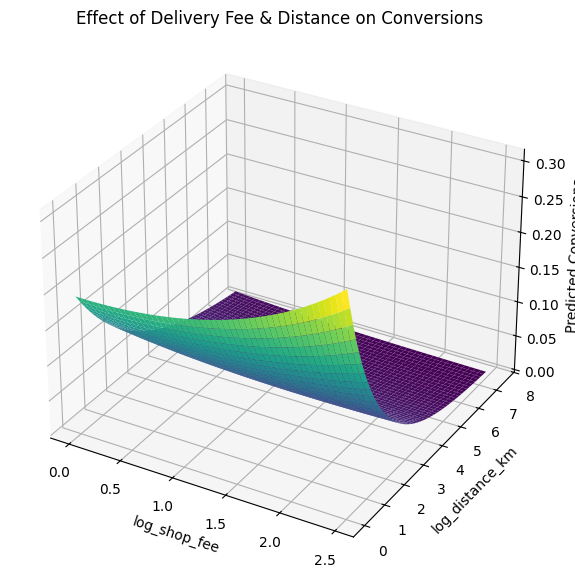

ValueError: Cannot set a DataFrame with multiple columns to the single column log_shop_fee_spline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

### 1️⃣ Visualizing Combined Effects in a 3D Surface Plot ###

# Define grid ranges
log_shop_fee_range = np.linspace(df_session["log_shop_fee"].min(), df_session["log_shop_fee"].max(), 50)
log_delivery_time_range = np.linspace(df_session["log_delivery_time"].min(), df_session["log_delivery_time"].max(), 50)
log_distance_km_range = np.linspace(df_session["log_distance_km"].min(), df_session["log_distance_km"].max(), 50)

# Create mesh grid for fee vs. distance (keeping delivery time fixed)
log_shop_fee_grid, log_distance_km_grid = np.meshgrid(log_shop_fee_range, log_distance_km_range)
log_delivery_time_fixed = np.mean(df_session["log_delivery_time"])

# Create dataframe for predictions
df_pdp_fee_distance = pd.DataFrame({
    "log_shop_fee": log_shop_fee_grid.ravel(),
    "log_shop_fee_sq": log_shop_fee_grid.ravel() ** 2,
    "log_delivery_time": log_delivery_time_fixed,
    "log_delivery_time_sq": log_delivery_time_fixed ** 2,
    "log_distance_km": log_distance_km_grid.ravel(),
    "log_fee_x_distance": (log_shop_fee_grid * log_distance_km_grid).ravel(),
    "log_time_x_distance": (log_delivery_time_fixed * log_distance_km_grid).ravel(),
})

# Predict conversions
predicted_conversions_fee_distance = nonlinear_model.predict(df_pdp_fee_distance).values.reshape(log_shop_fee_grid.shape)

# 3D Plot: Fee vs. Distance
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(log_shop_fee_grid, log_distance_km_grid, predicted_conversions_fee_distance, cmap="viridis")

ax.set_xlabel("log_shop_fee")
ax.set_ylabel("log_distance_km")
ax.set_zlabel("Predicted Conversions")
ax.set_title("Effect of Delivery Fee & Distance on Conversions")

plt.show()

### 2️⃣ Fit a Non-Linear Model Using Splines ###

# Generate spline basis functions for fee and delivery time
df_session["log_shop_fee_spline"] = dmatrix("bs(log_shop_fee, df=4, degree=3)", data=df_session, return_type='dataframe')
df_session["log_delivery_time_spline"] = dmatrix("bs(log_delivery_time, df=4, degree=3)", data=df_session, return_type='dataframe')

# Fit the spline-based model
spline_model = smf.glm(
    "conversions ~ log_shop_fee_spline + log_delivery_time_spline + log_distance_km + log_fee_x_distance + log_time_x_distance",
    data=df_session,
    family=sm.families.NegativeBinomial()
).fit()

# Display summary
spline_model.summary()


In [ ]:
from patsy import dmatrix

# Generate spline basis functions for log_shop_fee and log_delivery_time
df_spline_fee = dmatrix("bs(log_shop_fee, df=4, degree=3) - 1", data=df_session, return_type='dataframe')
df_spline_time = dmatrix("bs(log_delivery_time, df=4, degree=3) - 1", data=df_session, return_type='dataframe')

# Rename columns to avoid conflicts
df_spline_fee.columns = [f"log_shop_fee_spline_{i}" for i in range(df_spline_fee.shape[1])]
df_spline_time.columns = [f"log_delivery_time_spline_{i}" for i in range(df_spline_time.shape[1])]

# Merge spline features into the original dataset
df_session = pd.concat([df_session, df_spline_fee, df_spline_time], axis=1)

# Manually construct the formula
spline_model_formula = "conversions ~ " + " + ".join(df_spline_fee.columns) + " + " + " + ".join(df_spline_time.columns) + " + log_distance_km + log_fee_x_distance + log_time_x_distance"

# Fit the model
spline_model = smf.glm(
    spline_model_formula,
    data=df_session,
    family=sm.families.NegativeBinomial()
).fit()

# Display summary
spline_model.summary()


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            conversions   No. Observations:              6161191
Model:                            GLM   Df Residuals:                  6161179
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4738e+06
Date:                Sat, 15 Mar 2025   Deviance:                   2.7068e+06
Time:                        12:49:47   Pearson chi2:                 4.73e+06
No. Iterations:                     6   Pseudo R-squ. (CS):           0.008692
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.5696      0.007   -227.013      0.000      -1.583      -1.556
log_shop_fee_spline_0          0.0536      0.013      4.135      0.000       0.028       0.079
log_shop_fee_spline_1          0.0503      0.013      3.803      0.000       0.024       0.076
log_shop_fee_spline_2          0.4152      0.023     17.705      0.000       0.369       0.461
log_shop_fee_spline_3          0.5779      0.031     18.924      0.000       0.518       0.638
log_delivery_time_spline_0     0.0190      0.009      2.079      0.038       0.001       0.037
log_delivery_time_spline_1    -0.1387      0.013    -10.675      0.000      -0.164      -0.113
log_delivery_time_spline_2    -0.1724      0.017    -10.087      0.000      -0.206      -0.139
log_delivery_time_spline_3    -0.0943      0.022     -4.290      0.000      -0.137      -0.051
log_distance_km               -0.1042      0.033     -3.161      0.002      -0.169      -0.040
log_fee_x_distance            -0.1240      0.005    -23.612      0.000      -0.134      -0.114
log_time_x_distance           -0.0726      0.010     -7.033      0.000      -0.093      -0.052
==============================================================================================
"""

In [ ]:
# Ensure squared terms exist in the dataset
df_session["log_shop_fee_sq"] = df_session["log_shop_fee"] ** 2
df_session["log_delivery_time_sq"] = df_session["log_delivery_time"] ** 2

# Create interaction terms for non-linear relationships
df_session["log_fee_x_distance"] = df_session["log_shop_fee"] * df_session["log_distance_km"]
df_session["log_time_x_distance"] = df_session["log_delivery_time"] * df_session["log_distance_km"]

# Fit the quadratic model again
nonlinear_model = smf.glm(
    "conversions ~ log_shop_fee + log_shop_fee_sq + log_delivery_time + log_delivery_time_sq + log_distance_km + log_fee_x_distance + log_time_x_distance",
    data=df_session,
    family=sm.families.NegativeBinomial()
).fit()


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [ ]:
import scipy.stats as stats

# Compute AIC and BIC for both models
aic_nonlinear = nonlinear_model.aic  # Quadratic model
bic_nonlinear = nonlinear_model.bic

aic_spline = spline_model.aic  # Spline-based model
bic_spline = spline_model.bic

# Likelihood Ratio Test (LRT)
lr_stat = 2 * (spline_model.llf - nonlinear_model.llf)
df_diff = spline_model.df_model - nonlinear_model.df_model
p_value = stats.chi2.sf(lr_stat, df_diff)  # Compute p-value

# Display results
model_comparison = {
    "AIC (Quadratic Model)": aic_nonlinear,
    "AIC (Spline Model)": aic_spline,
    "BIC (Quadratic Model)": bic_nonlinear,
    "BIC (Spline Model)": bic_spline,
    "Likelihood Ratio Test Statistic": lr_stat,
    "p-value (LRT)": p_value
}

model_comparison


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


{'AIC (Quadratic Model)': 4947801.272613223,
 'AIC (Spline Model)': 4947641.001076529,
 'BIC (Quadratic Model)': -93615657.24602678,
 'BIC (Spline Model)': -93615762.98244084,
 'Likelihood Ratio Test Statistic': 168.27153669390827,
 'p-value (LRT)': 2.45703948718773e-35}

In [ ]:
%pip install pymc

ModuleNotFoundError: No module named 'pty'

In [ ]:
%pip install XGBRegressor

ModuleNotFoundError: No module named 'pty'

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Select features and target
X = df_session[["log_shop_fee", "log_delivery_time", "log_distance_km"]]
y = df_session["conversions"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred = xgb_model.predict(X_test)

# Evaluate performance
from sklearn.metrics import mean_squared_error
print("MSE:", mean_squared_error(y_test, y_pred))


ModuleNotFoundError: No module named 'xgboost'

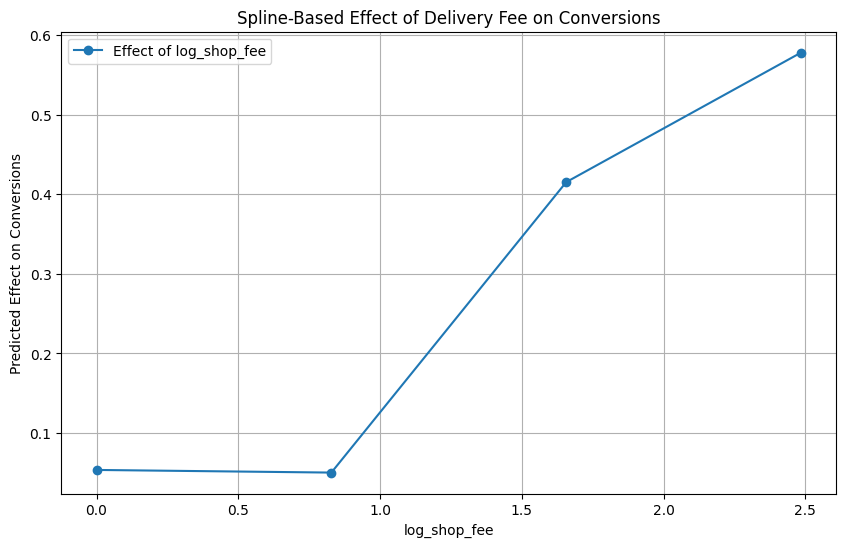

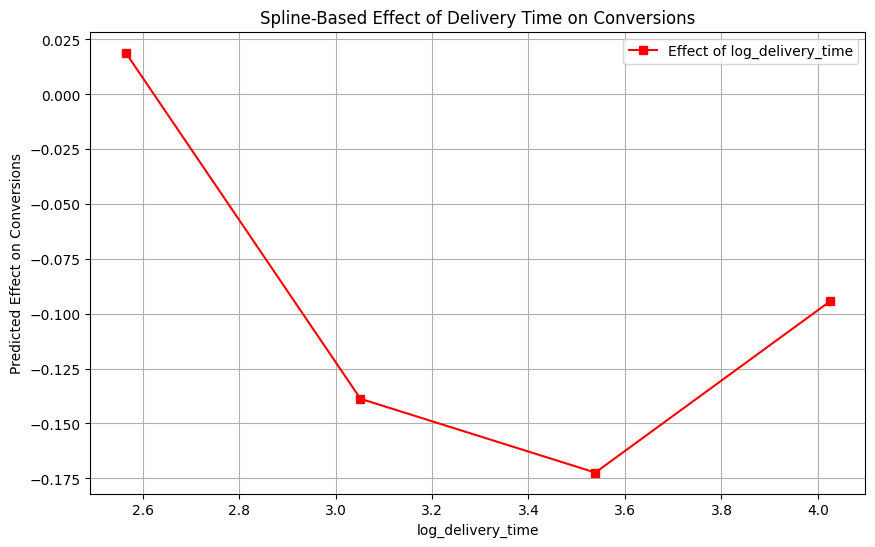

In [ ]:
import matplotlib.pyplot as plt

# Extract predicted spline effects for log_shop_fee
spline_fee_effects = spline_model.params.filter(like="log_shop_fee_spline_")
spline_fee_range = np.linspace(df_session["log_shop_fee"].min(), df_session["log_shop_fee"].max(), len(spline_fee_effects))

# Extract predicted spline effects for log_delivery_time
spline_time_effects = spline_model.params.filter(like="log_delivery_time_spline_")
spline_time_range = np.linspace(df_session["log_delivery_time"].min(), df_session["log_delivery_time"].max(), len(spline_time_effects))

# Plot the effect of log_shop_fee splines
plt.figure(figsize=(10, 6))
plt.plot(spline_fee_range, spline_fee_effects.values, marker="o", label="Effect of log_shop_fee")
plt.xlabel("log_shop_fee")
plt.ylabel("Predicted Effect on Conversions")
plt.title("Spline-Based Effect of Delivery Fee on Conversions")
plt.legend()
plt.grid()

# Plot the effect of log_delivery_time splines
plt.figure(figsize=(10, 6))
plt.plot(spline_time_range, spline_time_effects.values, marker="s", color="red", label="Effect of log_delivery_time")
plt.xlabel("log_delivery_time")
plt.ylabel("Predicted Effect on Conversions")
plt.title("Spline-Based Effect of Delivery Time on Conversions")
plt.legend()
plt.grid()

plt.show()


In [ ]:
!pip install numpy scipy cython
#!pip install pygam

ModuleNotFoundError: No module named 'pty'

In [ ]:
from pygam import LinearGAM, s, f

# Prepare data for GAM model
X = df_session[["log_shop_fee", "log_delivery_time", "log_distance_km"]].values
y = df_session["conversions"].values

# Fit a Generalized Additive Model (GAM) with spline smoothing for non-linear relationships
gam_model = LinearGAM(s(0) + s(1) + s(2) + f(0)).fit(X, y)

# Generate predictions for visualization
XX = gam_model.generate_X_grid(term=0)  # Generate grid for log_shop_fee
predictions_fee = gam_model.partial_dependence(term=0, X=XX)  # Effect of log_shop_fee

XX_time = gam_model.generate_X_grid(term=1)  # Generate grid for log_delivery_time
predictions_time = gam_model.partial_dependence(term=1, X=XX_time)  # Effect of log_delivery_time

XX_distance = gam_model.generate_X_grid(term=2)  # Generate grid for log_distance_km
predictions_distance = gam_model.partial_dependence(term=2, X=XX_distance)  # Effect of log_distance_km

# Plot the GAM smoothed effects

# Effect of Delivery Fee
plt.figure(figsize=(10, 6))
plt.plot(XX[:, 0], predictions_fee, color="blue", label="Effect of log_shop_fee")
plt.xlabel("log_shop_fee")
plt.ylabel("Effect on Conversions")
plt.title("GAM-Based Effect of Delivery Fee on Conversions")
plt.legend()
plt.grid()

# Effect of Delivery Time
plt.figure(figsize=(10, 6))
plt.plot(XX_time[:, 0], predictions_time, color="red", label="Effect of log_delivery_time")
plt.xlabel("log_delivery_time")
plt.ylabel("Effect on Conversions")
plt.title("GAM-Based Effect of Delivery Time on Conversions")
plt.legend()
plt.grid()

# Effect of Distance
plt.figure(figsize=(10, 6))
plt.plot(XX_distance[:, 0], predictions_distance, color="green", label="Effect of log_distance_km")
plt.xlabel("log_distance_km")
plt.ylabel("Effect on Conversions")
plt.title("GAM-Based Effect of Distance on Conversions")
plt.legend()
plt.grid()

plt.show()


ModuleNotFoundError: No module named 'pygam'

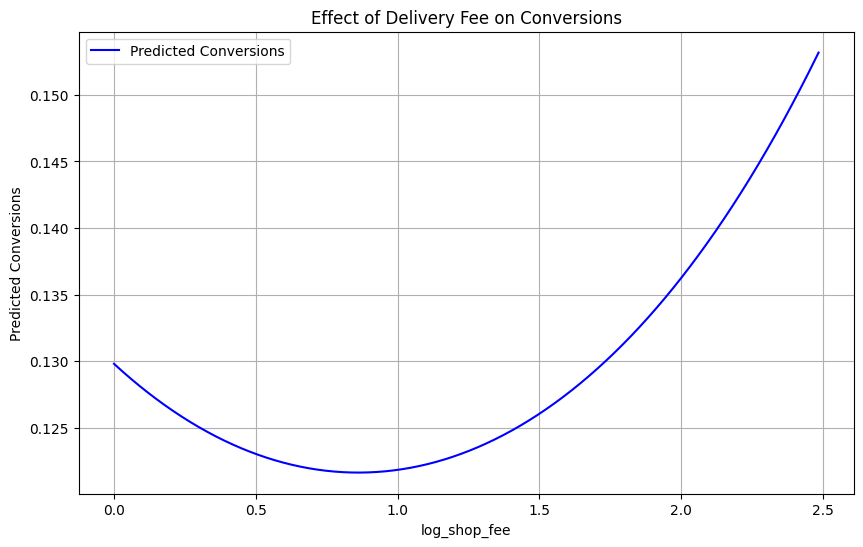

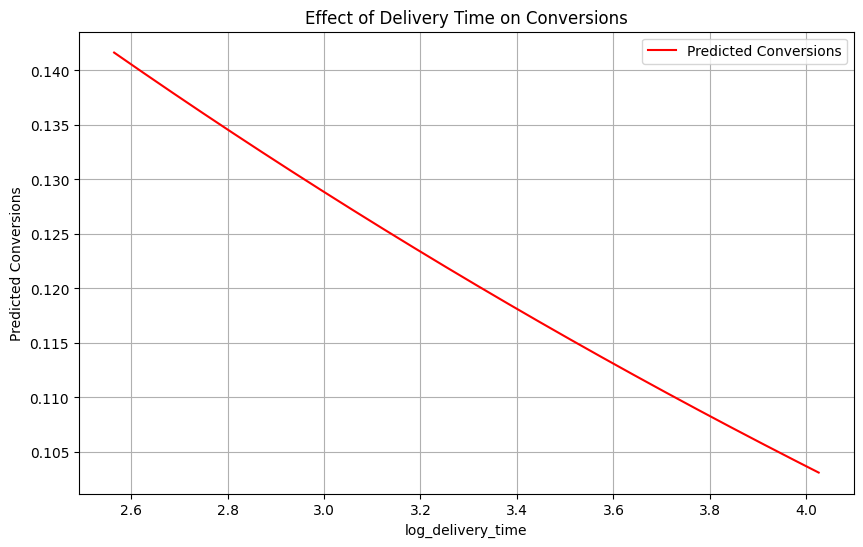

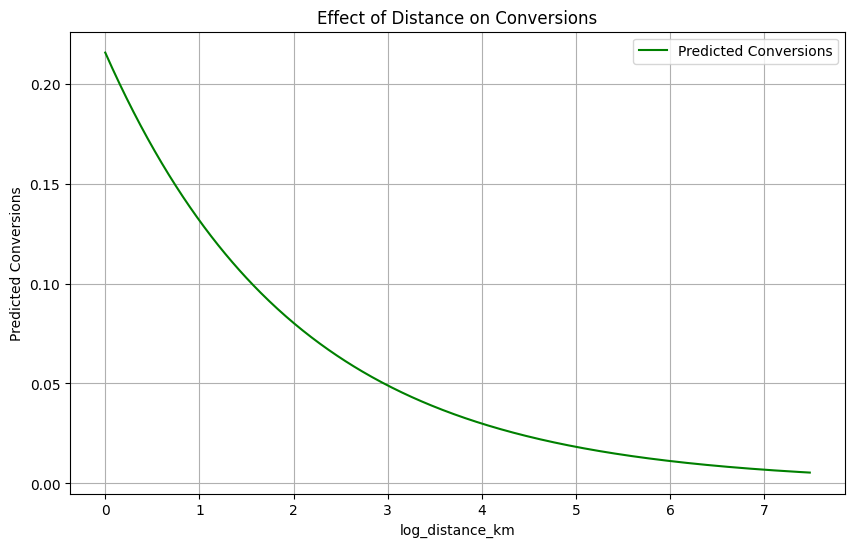

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Ensure squared term exists
df_session["log_shop_fee_sq"] = df_session["log_shop_fee"] ** 2

# Define mean values for other predictors
mean_shop_fee = df_session["log_shop_fee"].mean()
mean_delivery_time = df_session["log_delivery_time"].mean()
mean_distance = df_session["log_distance_km"].mean()

# Generate ranges for variables
log_shop_fee_range = np.linspace(df_session["log_shop_fee"].min(), df_session["log_shop_fee"].max(), 500)
log_delivery_time_range = np.linspace(df_session["log_delivery_time"].min(), df_session["log_delivery_time"].max(), 500)
log_distance_km_range = np.linspace(df_session["log_distance_km"].min(), df_session["log_distance_km"].max(), 500)

# Convert to DataFrames with matching dimensions
df_fee = pd.DataFrame({
    "log_shop_fee": log_shop_fee_range,
    "log_shop_fee_sq": log_shop_fee_range ** 2,
    "log_delivery_time": mean_delivery_time,
    "log_distance_km": mean_distance,
    "log_fee_x_time": log_shop_fee_range * mean_delivery_time,
    "log_fee_x_distance": log_shop_fee_range * mean_distance
})

df_time = pd.DataFrame({
    "log_shop_fee": mean_shop_fee,
    "log_shop_fee_sq": mean_shop_fee ** 2,
    "log_delivery_time": log_delivery_time_range,
    "log_distance_km": mean_distance,
    "log_fee_x_time": mean_shop_fee * log_delivery_time_range,
    "log_fee_x_distance": mean_shop_fee * mean_distance
})

df_distance = pd.DataFrame({
    "log_shop_fee": mean_shop_fee,
    "log_shop_fee_sq": mean_shop_fee ** 2,
    "log_delivery_time": mean_delivery_time,
    "log_distance_km": log_distance_km_range,
    "log_fee_x_time": mean_shop_fee * mean_delivery_time,
    "log_fee_x_distance": mean_shop_fee * log_distance_km_range
})

# Predict conversions for each case
fee_predictions = model_with_interactions.predict(df_fee)
time_predictions = model_with_interactions.predict(df_time)
distance_predictions = model_with_interactions.predict(df_distance)

# Plot Effect of Delivery Fee
plt.figure(figsize=(10, 6))
plt.plot(log_shop_fee_range, fee_predictions, label="Predicted Conversions", color="blue")
plt.xlabel("log_shop_fee")
plt.ylabel("Predicted Conversions")
plt.title("Effect of Delivery Fee on Conversions")
plt.legend()
plt.grid()

# Plot Effect of Delivery Time
plt.figure(figsize=(10, 6))
plt.plot(log_delivery_time_range, time_predictions, label="Predicted Conversions", color="red")
plt.xlabel("log_delivery_time")
plt.ylabel("Predicted Conversions")
plt.title("Effect of Delivery Time on Conversions")
plt.legend()
plt.grid()

# Plot Effect of Distance
plt.figure(figsize=(10, 6))
plt.plot(log_distance_km_range, distance_predictions, label="Predicted Conversions", color="green")
plt.xlabel("log_distance_km")
plt.ylabel("Predicted Conversions")
plt.title("Effect of Distance on Conversions")
plt.legend()
plt.grid()

plt.show()


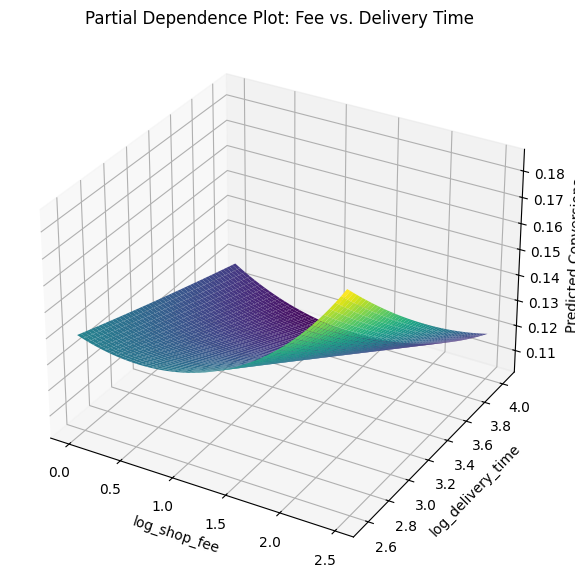

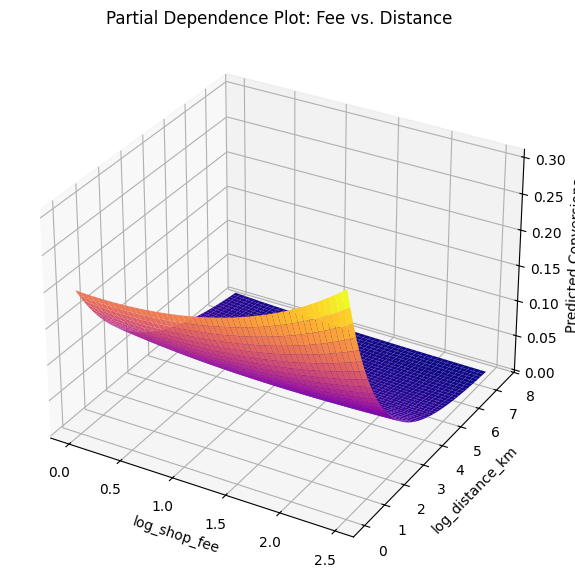

In [311]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Generate a grid of values for fee, delivery time, and distance
log_shop_fee_range = np.linspace(df_session["log_shop_fee"].min(), df_session["log_shop_fee"].max(), 50)
log_delivery_time_range = np.linspace(df_session["log_delivery_time"].min(), df_session["log_delivery_time"].max(), 50)
log_distance_km_range = np.linspace(df_session["log_distance_km"].min(), df_session["log_distance_km"].max(), 50)

# Create a mesh grid for 3D visualization
log_shop_fee_grid, log_delivery_time_grid = np.meshgrid(log_shop_fee_range, log_delivery_time_range)
log_distance_km_grid = np.mean(df_session["log_distance_km"])  # Keep distance fixed

# Create a DataFrame for prediction
df_pdp_fee_time = pd.DataFrame({
    "log_shop_fee": log_shop_fee_grid.ravel(),
    "log_shop_fee_sq": log_shop_fee_grid.ravel() ** 2,
    "log_delivery_time": log_delivery_time_grid.ravel(),
    "log_distance_km": log_distance_km_grid,
    "log_fee_x_time": (log_shop_fee_grid * log_delivery_time_grid).ravel(),
    "log_fee_x_distance": (log_shop_fee_grid * log_distance_km_grid).ravel(),
})

# Predict conversions
predicted_conversions_fee_time = model_with_interactions.predict(df_pdp_fee_time).values.reshape(log_shop_fee_grid.shape)

# 3D Plot: Fee vs. Delivery Time
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(log_shop_fee_grid, log_delivery_time_grid, predicted_conversions_fee_time, cmap="viridis")

ax.set_xlabel("log_shop_fee")
ax.set_ylabel("log_delivery_time")
ax.set_zlabel("Predicted Conversions")
ax.set_title("Partial Dependence Plot: Fee vs. Delivery Time")

plt.show()

# Now create a grid for Fee vs. Distance
log_shop_fee_grid, log_distance_km_grid = np.meshgrid(log_shop_fee_range, log_distance_km_range)
log_delivery_time_grid = np.mean(df_session["log_delivery_time"])  # Keep delivery time fixed

df_pdp_fee_distance = pd.DataFrame({
    "log_shop_fee": log_shop_fee_grid.ravel(),
    "log_shop_fee_sq": log_shop_fee_grid.ravel() ** 2,
    "log_delivery_time": log_delivery_time_grid,
    "log_distance_km": log_distance_km_grid.ravel(),
    "log_fee_x_time": (log_shop_fee_grid * log_delivery_time_grid).ravel(),
    "log_fee_x_distance": (log_shop_fee_grid * log_distance_km_grid).ravel(),
})

# Predict conversions
predicted_conversions_fee_distance = model_with_interactions.predict(df_pdp_fee_distance).values.reshape(log_shop_fee_grid.shape)

# 3D Plot: Fee vs. Distance
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(log_shop_fee_grid, log_distance_km_grid, predicted_conversions_fee_distance, cmap="plasma")

ax.set_xlabel("log_shop_fee")
ax.set_ylabel("log_distance_km")
ax.set_zlabel("Predicted Conversions")
ax.set_title("Partial Dependence Plot: Fee vs. Distance")

plt.show()


In [195]:
# Define distance groups
listings_df['distance_group'] = pd.cut(listings_df['distance_km'], bins=[0, 2, 5, 10, 20], labels=["0-2km", "2-5km", "5-10km", "10-20km"])

# Run separate regressions for each distance group
for group in listings_df['distance_group'].unique():
    subset = listings_df[listings_df['distance_group'] == group]
    subset = subset.dropna(subset=['shopDeliveryFee', 'average_delivery_time', 'click'])


    X = subset[['shopDeliveryFee', 'average_delivery_time']]
    X = sm.add_constant(X)
    y = subset['click']
    
    model = sm.OLS(y, X).fit()
    
    print(f"Regression results for distance group: {group}")
    print(model.summary())
    print("\n" + "-"*80 + "\n")


Regression results for distance group: 2-5km
                            OLS Regression Results                            
Dep. Variable:                  click   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     324.1
Date:                Sat, 15 Mar 2025   Prob (F-statistic):          2.04e-141
Time:                        00:31:13   Log-Likelihood:            -2.1984e+05
No. Observations:              871423   AIC:                         4.397e+05
Df Residuals:                  871420   BIC:                         4.397e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

ValueError: zero-size array to reduction operation maximum which has no identity

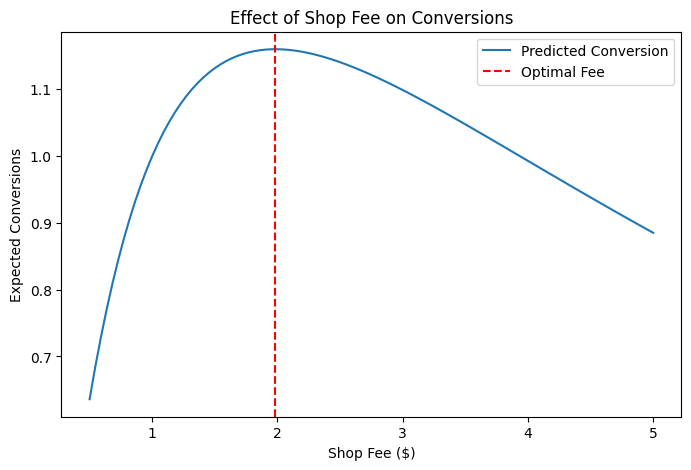

In [136]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate values for shop fee
shop_fees = np.linspace(0.5, 5, 100)  # Adjust range based on your data
log_shop_fees = np.log(shop_fees)

# Compute predicted effect
predicted_conversion = 0.4336 * log_shop_fees - 0.3165 * (log_shop_fees ** 2)

# Plot
plt.figure(figsize=(8,5))
plt.plot(shop_fees, np.exp(predicted_conversion), label="Predicted Conversion")
plt.axvline(x=np.exp(0.685), color='r', linestyle="--", label="Optimal Fee")
plt.xlabel("Shop Fee ($)")
plt.ylabel("Expected Conversions")
plt.title("Effect of Shop Fee on Conversions")
plt.legend()
plt.show()


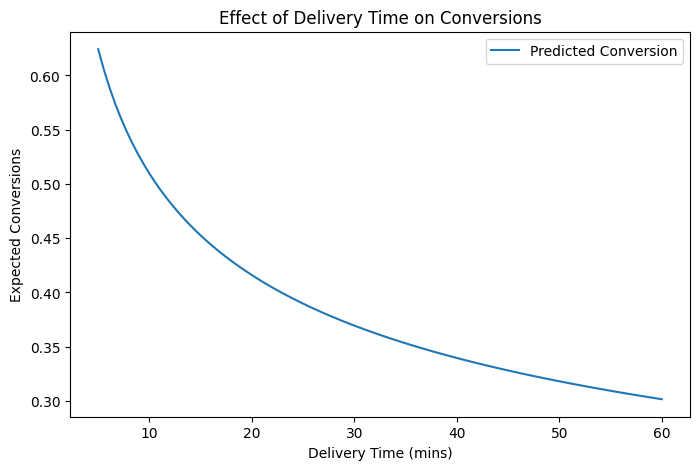

In [137]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate values for delivery time
delivery_times = np.linspace(5, 60, 100)  # Adjust range based on your data
log_delivery_times = np.log(delivery_times)

# Compute predicted effect using coefficient from model
predicted_conversion = -0.2928 * log_delivery_times  # No quadratic term

# Plot
plt.figure(figsize=(8,5))
plt.plot(delivery_times, np.exp(predicted_conversion), label="Predicted Conversion")
plt.xlabel("Delivery Time (mins)")
plt.ylabel("Expected Conversions")
plt.title("Effect of Delivery Time on Conversions")
plt.legend()
plt.show()


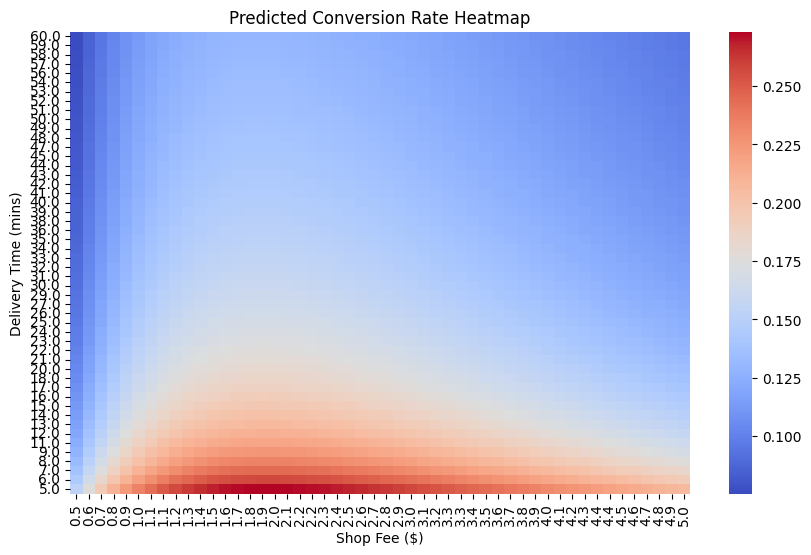

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define ranges for shop fee and delivery time
shop_fees = np.linspace(0.5, 5, 50)  # Adjust range based on your data
delivery_times = np.linspace(5, 60, 50)  # Adjust range based on your data

# Create meshgrid for plotting
shop_fee_grid, delivery_time_grid = np.meshgrid(shop_fees, np.sort(delivery_times))  # Ensure delivery_time is sorted

# Compute log values
log_shop_fee_grid = np.log(shop_fee_grid)
log_delivery_time_grid = np.log(delivery_time_grid)

# Compute predicted log conversion
predicted_log_conversion = (
    -0.9633 + 
    0.4336 * log_shop_fee_grid - 
    0.3165 * (log_shop_fee_grid ** 2) - 
    0.2928 * log_delivery_time_grid - 
    0.0102 * (log_shop_fee_grid * log_delivery_time_grid)
)

# Convert log conversion to actual predicted conversion rates
predicted_conversion = np.exp(predicted_log_conversion)

# Ensure Y-axis (delivery time) is sorted correctly in the heatmap
plt.figure(figsize=(10,6))
ax = sns.heatmap(predicted_conversion, 
                 xticklabels=np.round(shop_fees, 1), 
                 yticklabels=np.round(np.sort(delivery_times), 0),  # Sorted delivery times
                 cmap="coolwarm", 
                 annot=False)

# Invert Y-axis to have lowest delivery time at the bottom (if needed)
ax.invert_yaxis()  

plt.xlabel("Shop Fee ($)")
plt.ylabel("Delivery Time (mins)")
plt.title("Predicted Conversion Rate Heatmap")
plt.show()


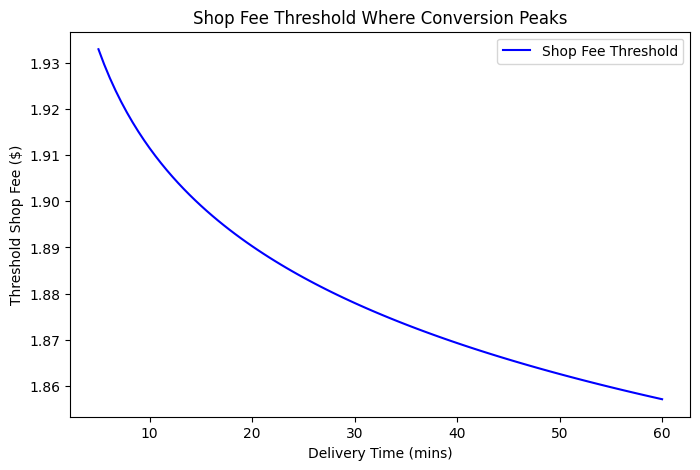

In [140]:
import numpy as np
import matplotlib.pyplot as plt

# Define a range of delivery times
delivery_times = np.linspace(5, 60, 100)  # Adjust range as needed
log_delivery_times = np.log(delivery_times)

# Compute threshold shop fee for each delivery time
threshold_shop_fees = np.exp((0.4336 - 0.0102 * log_delivery_times) / (2 * 0.3165))

# Plot threshold fee vs delivery time
plt.figure(figsize=(8, 5))
plt.plot(delivery_times, threshold_shop_fees, label="Shop Fee Threshold", color="blue")
plt.xlabel("Delivery Time (mins)")
plt.ylabel("Threshold Shop Fee ($)")
plt.title("Shop Fee Threshold Where Conversion Peaks")
plt.legend()
plt.show()

In [52]:
# Aggregate conversion rate by (delivery_time, delivery_fee)
agg_df = listings_df.groupby(['average_delivery_time', 'shopDeliveryFee']).agg(
    conversion_rate=('click', 'sum'),
    total_shops=('shopId', 'count')
).reset_index()

# # Create a grid for interpolation
# grid_x, grid_y = np.meshgrid(
#     np.linspace(agg_df['delivery_time'].min(), agg_df['delivery_time'].max(), 100),
#     np.linspace(agg_df['delivery_fee'].min(), agg_df['delivery_fee'].max(), 100)
# )

# # Interpolate using griddata
# grid_z = griddata(
#     (agg_df['delivery_time'], agg_df['delivery_fee']), 
#     agg_df['conversion_rate'], 
#     (grid_x, grid_y), method='cubic'
# )

# # Apply Gaussian smoothing
# grid_z_smooth = ndimage.gaussian_filter(grid_z, sigma=1.5)

# # Plot the smoothed heatmap
# plt.figure(figsize=(10, 6))
# plt.contourf(grid_x, grid_y, grid_z_smooth, levels=15, cmap='coolwarm')
# plt.colorbar(label='Conversion Rate')
# plt.xlabel("Delivery Time (mins)")
# plt.ylabel("Delivery Fee ($)")
# plt.title("Smoothed Conversion Rate by Delivery Time & Fee")
# plt.show()

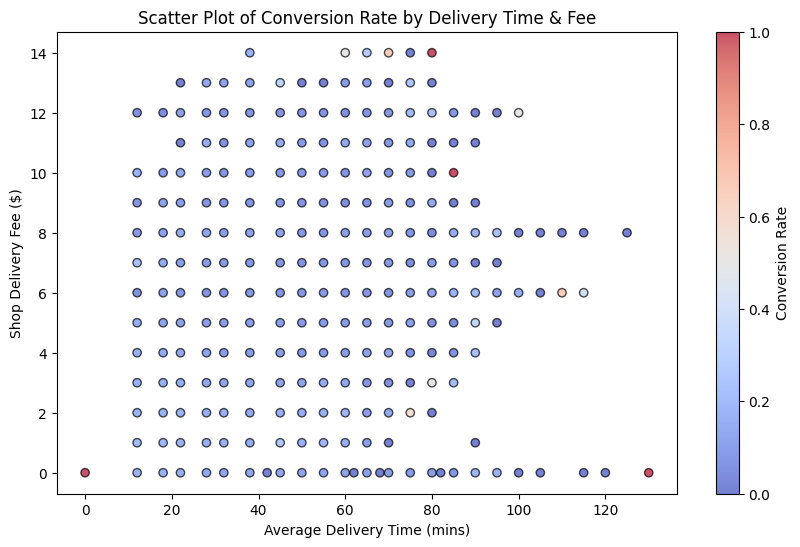

In [53]:

import matplotlib.pyplot as plt
agg_df = agg_df[agg_df['shopDeliveryFee'] < 15]

# Compute conversion rate
agg_df['conversion_rate'] = agg_df['conversion_rate'] / agg_df['total_shops']

# Plot scatter chart of conversion rate by delivery time and delivery fee
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    agg_df['average_delivery_time'], agg_df['shopDeliveryFee'], 
    c=agg_df['conversion_rate'], cmap='coolwarm', alpha=0.7, edgecolors='k'
)
plt.colorbar(scatter, label='Conversion Rate')
plt.xlabel("Average Delivery Time (mins)")
plt.ylabel("Shop Delivery Fee ($)")
plt.title("Scatter Plot of Conversion Rate by Delivery Time & Fee")
plt.show()

In [35]:
agg_df['conversion_rate'] < agg_df['total_shops']

0      False
1      False
2      False
3      False
4      False
       ...  
346    False
347    False
348    False
349    False
350    False
Length: 351, dtype: bool

In [41]:
import pandas as pd
import statsmodels.api as sm

# Aggregate the data at the session level
session_df = listings_df.groupby(['session_key','locationCity']).agg(
    avg_delivery_fee = ('shopDeliveryFee', 'mean'),
    avg_delivery_time = ('average_delivery_time', 'mean'),
    click_rate = ('click', 'mean'),    # proportion of shops clicked per session
    num_exposures = ('session_key', 'count')  # number of shops viewed in the session
).reset_index()

# For log-transformation, add a small constant to avoid log(0)
epsilon = 1e-6
session_df['log_avg_delivery_fee'] = np.log(session_df['avg_delivery_fee'] + epsilon)
session_df['log_avg_delivery_time'] = np.log(session_df['avg_delivery_time'] + epsilon)

print(session_df.head())


# Create dummy variables for locationCity, dropping the first category
location_dummies = pd.get_dummies(session_df['locationCity'], prefix='locationCity', drop_first=True)

# Combine numeric predictors with the dummy variables
X = pd.concat([session_df[['log_avg_delivery_fee', 'log_avg_delivery_time']], location_dummies], axis=1)
X = sm.add_constant(X)  # Adds the intercept term

# Define the dependent variable
y = session_df['click_rate']

# Debug: Print data types before conversion
print("Before conversion, X dtypes:")
print(X.dtypes)
print("\nBefore conversion, y dtype:")
print(y.dtype)

# Convert all columns to numeric, coercing errors to NaN
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Debug: Check data types again
print("\nAfter pd.to_numeric, X dtypes:")
print(X.dtypes)
print("\nAfter pd.to_numeric, y dtype:")
print(y.dtype)

# Force conversion to float if needed
X = X.astype(float)
y = y.astype(float)

# Optionally, drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Debug: Check shapes and dtypes one more time
print("\nFinal X dtypes:")
print(X.dtypes)
print("\nFinal X shape:", X.shape)
print("Final y shape:", y.shape)

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                session_key locationCity  avg_delivery_fee  avg_delivery_time  \
0  +++b0H7fIGqLENadjkvesQ==        Rauma          5.000000          18.000000   
1  ++0B4qQM4ms6wCHwK9HqpQ==    Seinäjoki          5.000000          22.000000   
2  ++17LRnS46b9xDXOdMQn/g==     Helsinki          2.181818          18.727273   
3  ++1CcXWGS5BkY/OeswqK4g==         Kemi          2.714286          16.857143   
4  ++1KRKw3b2Q/46I8V8LrXw==     Helsinki          0.000000          22.000000   

   click_rate  num_exposures  log_avg_delivery_fee  log_avg_delivery_time  
0         1.0              1              1.609438               2.890372  
1         1.0              1              1.609438               3.091042  
2         1.0             11              0.780159               2.929981  
3         1.0              7              0.998529               2.824775  
4         1.0              1            -13.815511               3.091042  
Before conversion, X dtypes:
const                       

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [ ]:
import statsmodels.api as sm

# Define the formula: add additional covariates as needed.
formula = "click ~ log_delivery_fee + log_promised_time"

# Fit a GEE model clustering on session_id
gee_model = sm.GEE.from_formula(formula,
                                groups="session_key",
                                data=listings_df,
                                family=sm.families.Binomial())
gee_result = gee_model.fit()

print(gee_result.summary())

In [ ]:
# Create design matrices for fixed effects using patsy.
formula = "click ~ log_delivery_fee + log_promised_time"
y, X = patsy.dmatrices(formula, data, return_type='dataframe')

# Create a variance components design matrix for the random intercept by session.
vc_formula = "0 + C(session_key)"
vc_matrix = patsy.dmatrix(vc_formula, data, return_type='dataframe')
vc = {"session": vc_matrix}

# Fit the BinomialBayesMixedGLM model using variational Bayes
model = BinomialBayesMixedGLM(endog=y, exog=X, exog_vc=vc)
fit_result = model.fit_vb()

print(fit_result.summary())